# Recommend movies

## Background and Motivation

Recommendation system is widely used in our daily life, from shopping to entertainment. Here we are building a recommendation system for movies, based on:
- user's rating to movies
- user features: occupation, gender, age
- movie features: year, genre

## 1. set up Spark environment and read data

In [1]:
import pyspark as ps
import pandas as pd
from pyspark.ml.recommendation import ALS
from datetime import datetime

spark = (
        ps.sql.SparkSession.builder 
        .master("local[4]") 
        .appName("lecture") 
        .getOrCreate()
        )
sc = spark.sparkContext

request_data = pd.read_csv('data/requests.csv')
train_data = pd.read_csv('data/training.csv')
train_data['ts'] = train_data.timestamp.apply(lambda ts: datetime.fromtimestamp(ts))


df_f = spark.createDataFrame(train_data) 
df_re = spark.createDataFrame(request_data)


In [117]:
from sklearn.decomposition import NMF

## 2. EDA

In [ ]:
pd.sca

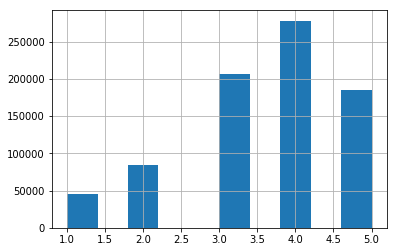

In [115]:
train_data.rating.hist()

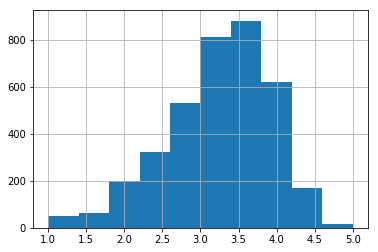

In [114]:
train_data.groupby('movie')['rating'].apply(np.mean).hist()

In [116]:
train_data.groupby('movie')['rating'].apply(lambda x:np.percentile(x,90,axis=0))

movie
1       5.0
2       4.0
3       4.0
4       4.0
5       4.0
6       5.0
7       5.0
8       4.0
9       4.0
10      5.0
11      5.0
12      4.0
13      4.5
14      5.0
15      4.0
16      5.0
17      5.0
18      5.0
19      4.0
20      4.0
21      5.0
22      4.8
23      4.0
24      4.0
25      5.0
26      5.0
27      4.0
28      5.0
29      5.0
30      5.0
       ... 
3923    4.0
3924    4.0
3925    5.0
3926    4.0
3927    5.0
3928    5.0
3929    5.0
3930    4.0
3931    3.1
3932    5.0
3933    4.0
3934    4.6
3935    4.0
3936    5.0
3937    4.0
3938    3.4
3939    4.0
3940    2.8
3941    4.0
3942    4.0
3943    4.0
3944    3.8
3945    2.5
3946    4.0
3947    5.0
3948    5.0
3949    5.0
3950    4.6
3951    5.0
3952    5.0
Name: rating, Length: 3662, dtype: float64

### NMF

In [125]:
nmf = NMF(n_components=18, random_state=1,alpha=.1, l1_ratio=.5)
U = nmf.fit(ratings_as_mat)
V = nmf.components_.T

In [124]:
U.dot(V.T)

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [5.72454362e-01, 3.93312317e-02, 3.64783535e-02, ...,
        2.09112459e-04, 2.11591263e-03, 6.69626493e-03],
       [2.06950513e+00, 5.76532407e-01, 1.18310707e-01, ...,
        2.85711498e-02, 0.00000000e+00, 1.82449516e-03],
       [1.27747265e+00, 8.07680280e-02, 7.01429645e-03, ...,
        2.28096149e-02, 8.69379344e-02, 2.99992995e-01]])

In [126]:
nmf.transform()

ValueError: Array with wrong shape passed to NMF (input H). Expected (18, 2), but got (18, 3952) 

### ALS - grid search and cross validation

In [77]:
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
als = ALS()
pipeline = Pipeline(stages=[als])
paramGrid = ParamGridBuilder() \
    .addGrid(als.regParam, [0.1, 0.3]) \
    .addGrid(als.rank, [18,25]) \
    .build()

In [80]:
crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=ClusteringEvaluator(),
                          numFolds=2)  # use 3+ folds in practice
cvModel = crossval.fit(df_f)
prediction = cvModel.transform(df_re)

IllegalArgumentException: 'Field "item" does not exist.'

In [ ]:
pred_request_pd = prediction.toPandas()

In [2]:
als_model_f = ALS(
    itemCol='movie',
    userCol='user',
    ratingCol='rating',
    nonnegative=True,    
    regParam=0.2,
    rank=18) 
recommender_f = als_model_f.fit(df_f)
pred_request = recommender_f.transform(df_re)
pred_request_pd = pred_request.toPandas()

In [4]:
pred_request_pd.to_csv('out.csv',index=False)

In [19]:
import numpy as np
np.mean(train_data.ts > pd.to_datetime('2000-08-01'))

0.71464375

In [25]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

In [ ]:
train_data

AttributeError: 'Figure' object has no attribute 'save'

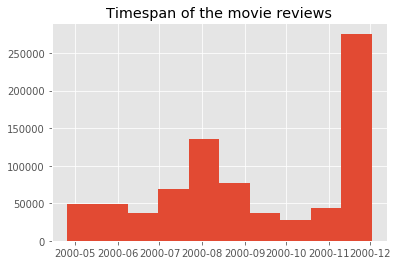

In [28]:
train_data.ts.dt.date.hist();
plt.title('Timespan of the movie reviews')
# fig = plt.gcf()
# figure.save('time distribution.png')

In [ ]:
train_data.ts > pd.to_datetime('2000-08-01')

In [29]:
mask_NANs = pred_request_pd.prediction.isnull()

In [3]:
na_users = pred_request_pd[pred_request_pd.prediction.isnull()].user

In [8]:
dft.shape

(95770, 1)

In [5]:
dft = pd.DataFrame(na_users)

In [7]:
dft.to_csv('na_users.csv',index=False)

In [ ]:
user_mask = na_users.apply(lambda x: train_data.user == x) #True : new movie; False: new user

In [166]:
mask_NANs.value_counts()

False    104439
True      95770
Name: prediction, dtype: int64

In [ ]:
user_mask.value_counts()

In [169]:
53 in train_data.user

True

In [171]:
train_data.user == 53

0         False
1         False
2         False
3         False
4         False
5         False
6         False
7         False
8         False
9         False
10        False
11        False
12        False
13        False
14        False
15        False
16        False
17        False
18        False
19        False
20        False
21        False
22        False
23        False
24        False
25        False
26        False
27        False
28        False
29        False
          ...  
799970    False
799971    False
799972    False
799973    False
799974    False
799975    False
799976    False
799977    False
799978    False
799979    False
799980    False
799981    False
799982    False
799983    False
799984    False
799985    False
799986    False
799987    False
799988    False
799989    False
799990    False
799991    False
799992    False
799993    False
799994    False
799995    False
799996    False
799997    False
799998    False
799999    False
Name: user, Length: 8000

In [83]:
out1 = pred_request_pd.fillna(1)

In [84]:
out1 = out1.rename(columns={'prediction':'rating'})

In [85]:
out1.to_csv('out1.csv',index=False)

In [94]:
import numpy as np
from sklearn.base import BaseEstimator,TransformerMixin
class ImputeNaNbythird(BaseEstimator, TransformerMixin):

    groupBy_colComp_colOn = [('movie', 'rating','prediction')]
#     ('Enclosure', 'near_price','near_price'),
#      ('ProductSize', 'near_price','near_price')]

    def fit(self, X):
        d = {}
        if self.groupBy_colComp_colOn:
            for groupby, col_comp, col_on in self.groupBy_colComp_colOn:
                d[groupby]=X.groupby(groupby)[col_comp].apply(np.mean).to_dict()
        self.d = d
        return self

    def transform(self, X):
        if self.groupBy_colComp_colOn:
            for groupby, col_comp, col_on in self.groupBy_colComp_colOn:
                X[col_on] = X[[groupby,col_on]].apply(lambda x: x[[col_on]].fillna(
                        self.d[groupby].get(x[groupby], np.nan)), axis=1)
        return X

In [95]:
I = ImputeNaNbythird()

In [96]:
m = I.fit(train_data)

In [105]:
len(m.d['movie'].keys())

3662

In [107]:
out2 = m.transform(pred_request_pd)

In [110]:
out2 = out2.rename(columns={'prediction':'rating'})
out2.to_csv('out2.csv',index=False)

In [ ]:
out3 = pred_request_pd
out3 = out3.rename(columns={'prediction':'rating'})
out3.to_csv('out3.csv',index=False)

In [23]:
users = pd.read_table('data/users.dat',sep='::',header=None)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.


In [33]:
users['gender']=pd.get_dummies(users[1],drop_first=True)

In [36]:
users = users.drop(1,axis=1)

In [38]:
users = users.drop(4,axis=1)


In [81]:
users

,age,occupation,gender
0,1,10,0
1,56,16,1
2,25,15,1
3,45,7,1
4,25,20,1
5,50,9,0
6,35,1,1
7,25,12,1
8,25,17,1
9,35,1,0


In [39]:
def make_cos_sim_and_neighborhoods(ratings_mat, neighborhood_size):
    '''
    Accepts a 2 dimensional matrix ratings_mat, and an integer neighborhood_size.
    Returns a tuple containing:
        - items_cos_sim, an item-item matrix where each element is the
        cosine_similarity of the items at the corresponding row and column. This
        is a square matrix where the length of each dimension equals the number
        of columns in ratings_mat.
        - neighborhood, a 2-dimensional matrix where each row is the neighborhood
        for that item. The elements are the indices of the n (neighborhood_size)
        most similar items. Most similar items are at the end of the row.
    '''
    items_cos_sim = cosine_similarity(ratings_mat.T)
    least_to_most_sim_indexes = np.argsort(items_cos_sim, 1)
    neighborhood = least_to_most_sim_indexes[:, -neighborhood_size:]
    return items_cos_sim, neighborhood

In [55]:
import numpy as np
import pandas as pd
from scipy import sparse
from sklearn.metrics.pairwise import cosine_similarity



items_cos_sim, neighborhood = make_cos_sim_and_neighborhoods(users,10)

In [42]:
def pred_one_user(items_cos_sim, neighborhoods, ratings_mat, user_id):
    '''
    Returns the predicted ratings for all items for a given user.
    '''
    n_items = ratings_mat.shape[1]
    items_rated_by_this_user = ratings_mat[user_id].nonzero()[1]
    # Just initializing so we have somewhere to put rating preds
    output = np.zeros(n_items)
    for item_to_rate in range(n_items):
        relevant_items = np.intersect1d(neighborhoods[item_to_rate],
                                        items_rated_by_this_user,
                                        assume_unique=True)
                                    # assume_unique speeds up intersection op
        # note: ratings_mat has data type `sparse_lil_matrix`, while
        # items_cos_sim is a numpy array. Luckily for us, multiplication
        # between these two classes is defined, and even more luckily,
        # it is defined to as the dot product. So the numerator
        # in the following expression is an array of a single float
        # (not an array of elementwise products as you would expect
        #  if both things were numpy arrays)
        output[item_to_rate] = (ratings_mat[user_id, relevant_items] * items_cos_sim[item_to_rate, relevant_items]/(items_cos_sim[item_to_rate, relevant_items].sum()))
    return output

In [43]:
def get_ratings_data(ratings_contents):
    '''
    Returns a tuple containing:
        - a dataframe of ratings
        - a sparse matrix where rows correspond to users and columns correspond
        to movies. Each element is the user's rating for that movie.
    '''
    highest_user_id = ratings_contents.user.max()
    highest_movie_id = ratings_contents.movie.max()
    ratings_as_mat = sparse.lil_matrix((highest_user_id, highest_movie_id))
    for _, row in ratings_contents.iterrows():
        # subtract 1 from id's due to match 0 indexing
        ratings_as_mat[row.user - 1, row.movie - 1] = row.rating
    return ratings_contents, ratings_as_mat


In [45]:
ratings_contents, ratings_as_mat = get_ratings_data(train_data)

In [57]:
pred_one_user(items_cos_sim,neighborhood,ratings_as_mat,216)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide


IndexError: index 4 is out of bounds for axis 0 with size 4

In [53]:
neighborhood

array([[2, 3, 1, 0],
       [2, 3, 0, 1],
       [0, 3, 1, 2],
       [2, 0, 1, 3]])

In [51]:
na_users

0           53
5          216
6          482
8          424
11          26
12         319
13         202
15         331
16         524
20         392
21         516
22        1265
24         588
25          78
30         406
31         587
32          26
35         409
38         319
39         157
40         232
41         539
44         132
45         386
46         146
49         631
50         442
56         402
57         415
59         425
          ... 
200110     284
200111     566
200113     118
200115     475
200118      36
200119     393
200122     623
200126    1265
200133    1877
200135     225
200140     206
200141     442
200143     308
200162     229
200164     173
200166      59
200170     629
200171     136
200175     524
200178     361
200179     527
200184     390
200185     214
200188     195
200191     622
200192     151
200195     454
200197     131
200198     149
200202     281
Name: user, Length: 95770, dtype: int64

In [63]:
users = users.drop(0,axis=1)

In [65]:
users = users.rename(columns={2:'age',3:'occupation'})

In [67]:
make_cos_sim_and_neighborhoods(users,10)

(array([[1.        , 0.74338555, 0.77826994],
        [0.74338555, 1.        , 0.71882111],
        [0.77826994, 0.71882111, 1.        ]]), array([[1, 2, 0],
        [2, 0, 1],
        [1, 0, 2]]))

In [71]:
items_cos_sim = cosine_similarity(users).shape

In [72]:
least_to_most_sim_indexes = np.argsort(items_cos_sim, 1)

AxisError: axis 1 is out of bounds for array of dimension 1

In [128]:
import os
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from collections import Counter
from scipy.spatial.distance import pdist, squareform
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, dendrogram


In [213]:
kmeans = KMeans(n_clusters=5)
kmeans.fit(users.values)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=5, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [214]:
print(kmeans.cluster_centers_)

[[3.10912829e+01 8.26809211e+00 7.45888158e-01 7.38569079e+00
  4.21250000e+03]
 [3.06341667e+01 8.33166667e+00 7.27500000e-01 7.10250000e+00
  1.79650000e+03]
 [3.06548013e+01 8.29966887e+00 7.29304636e-01 7.38576159e+00
  3.00050000e+03]
 [3.04942623e+01 7.78442623e+00 6.63934426e-01 7.42459016e+00
  5.43050000e+03]
 [3.03168896e+01 8.05351171e+00 7.19063545e-01 7.21739130e+00
  5.98500000e+02]]


In [215]:
assigned_cluster = kmeans.transform(users.values).argmin(axis=1)

In [216]:
users['cluster'] = pd.Series(assigned_cluster)

In [217]:
users['userid']= users.index+1

In [218]:
users.head()

,age,occupation,gender,cluster,userid
0,1,10,0,4,1
1,56,16,1,4,2
2,25,15,1,4,3
3,45,7,1,4,4
4,25,20,1,4,5


In [155]:
u = pd.DataFrame(na_users)

In [161]:
for na_id in u.user:
    print(users[users.userid == na_id].cluster)

53    2
Name: cluster, dtype: int64
216    1
Name: cluster, dtype: int64
482    9
Name: cluster, dtype: int64
424    3
Name: cluster, dtype: int64
26    3
Name: cluster, dtype: int64
319    6
Name: cluster, dtype: int64
202    1
Name: cluster, dtype: int64
331    2
Name: cluster, dtype: int64
524    6
Name: cluster, dtype: int64
392    0
Name: cluster, dtype: int64
516    3
Name: cluster, dtype: int64
1265    11
Name: cluster, dtype: int64
588    1
Name: cluster, dtype: int64
78    2
Name: cluster, dtype: int64
406    9
Name: cluster, dtype: int64
587    3
Name: cluster, dtype: int64
26    3
Name: cluster, dtype: int64
409    7
Name: cluster, dtype: int64
319    6
Name: cluster, dtype: int64
157    14
Name: cluster, dtype: int64
232    16
Name: cluster, dtype: int64
539    1
Name: cluster, dtype: int64
132    7
Name: cluster, dtype: int64
386    6
Name: cluster, dtype: int64
146    1
Name: cluster, dtype: int64
631    16
Name: cluster, dtype: int64
442    7
Name: cluster, dtype: int64


Name: cluster, dtype: int64
175    1
Name: cluster, dtype: int64
583    7
Name: cluster, dtype: int64
610    12
Name: cluster, dtype: int64
456    1
Name: cluster, dtype: int64
441    7
Name: cluster, dtype: int64
229    2
Name: cluster, dtype: int64
326    0
Name: cluster, dtype: int64
301    1
Name: cluster, dtype: int64
494    9
Name: cluster, dtype: int64
59    2
Name: cluster, dtype: int64
445    2
Name: cluster, dtype: int64
8    10
Name: cluster, dtype: int64
100    1
Name: cluster, dtype: int64
450    15
Name: cluster, dtype: int64
495    1
Name: cluster, dtype: int64
23    11
Name: cluster, dtype: int64
49    7
Name: cluster, dtype: int64
380    0
Name: cluster, dtype: int64
7    3
Name: cluster, dtype: int64
162    1
Name: cluster, dtype: int64
514    7
Name: cluster, dtype: int64
549    8
Name: cluster, dtype: int64
130    1
Name: cluster, dtype: int64
624    13
Name: cluster, dtype: int64
453    10
Name: cluster, dtype: int64
314    14
Name: cluster, dtype: int64
565    10


Name: cluster, dtype: int64
494    9
Name: cluster, dtype: int64
629    13
Name: cluster, dtype: int64
343    13
Name: cluster, dtype: int64
438    13
Name: cluster, dtype: int64
509    9
Name: cluster, dtype: int64
528    13
Name: cluster, dtype: int64
550    0
Name: cluster, dtype: int64
352    6
Name: cluster, dtype: int64
75    6
Name: cluster, dtype: int64
536    16
Name: cluster, dtype: int64
424    3
Name: cluster, dtype: int64
284    12
Name: cluster, dtype: int64
18    5
Name: cluster, dtype: int64
148    7
Name: cluster, dtype: int64
392    0
Name: cluster, dtype: int64
31    7
Name: cluster, dtype: int64
516    3
Name: cluster, dtype: int64
53    2
Name: cluster, dtype: int64
588    1
Name: cluster, dtype: int64
296    1
Name: cluster, dtype: int64
193    5
Name: cluster, dtype: int64
44    16
Name: cluster, dtype: int64
271    1
Name: cluster, dtype: int64
360    3
Name: cluster, dtype: int64
476    13
Name: cluster, dtype: int64
556    14
Name: cluster, dtype: int64
305   

230    7
Name: cluster, dtype: int64
225    12
Name: cluster, dtype: int64
57    7
Name: cluster, dtype: int64
398    6
Name: cluster, dtype: int64
2947    9
Name: cluster, dtype: int64
173    10
Name: cluster, dtype: int64
136    8
Name: cluster, dtype: int64
411    13
Name: cluster, dtype: int64
149    6
Name: cluster, dtype: int64
53    2
Name: cluster, dtype: int64
211    10
Name: cluster, dtype: int64
115    10
Name: cluster, dtype: int64
501    6
Name: cluster, dtype: int64
190    1
Name: cluster, dtype: int64
618    1
Name: cluster, dtype: int64
139    12
Name: cluster, dtype: int64
117    0
Name: cluster, dtype: int64
2910    11
Name: cluster, dtype: int64
461    9
Name: cluster, dtype: int64
278    3
Name: cluster, dtype: int64
514    7
Name: cluster, dtype: int64
549    8
Name: cluster, dtype: int64
565    10
Name: cluster, dtype: int64
543    13
Name: cluster, dtype: int64
245    1
Name: cluster, dtype: int64
482    9
Name: cluster, dtype: int64
390    16
Name: cluster, dtyp

Name: cluster, dtype: int64
520    14
Name: cluster, dtype: int64
549    8
Name: cluster, dtype: int64
453    10
Name: cluster, dtype: int64
524    6
Name: cluster, dtype: int64
312    1
Name: cluster, dtype: int64
509    9
Name: cluster, dtype: int64
10    7
Name: cluster, dtype: int64
102    8
Name: cluster, dtype: int64
240    0
Name: cluster, dtype: int64
591    1
Name: cluster, dtype: int64
62    1
Name: cluster, dtype: int64
411    13
Name: cluster, dtype: int64
558    11
Name: cluster, dtype: int64
550    0
Name: cluster, dtype: int64
33    1
Name: cluster, dtype: int64
424    3
Name: cluster, dtype: int64
123    14
Name: cluster, dtype: int64
466    12
Name: cluster, dtype: int64
2    10
Name: cluster, dtype: int64
529    7
Name: cluster, dtype: int64
302    11
Name: cluster, dtype: int64
67    1
Name: cluster, dtype: int64
407    3
Name: cluster, dtype: int64
148    7
Name: cluster, dtype: int64
392    0
Name: cluster, dtype: int64
516    3
Name: cluster, dtype: int64
137    9

543    13
Name: cluster, dtype: int64
524    6
Name: cluster, dtype: int64
533    10
Name: cluster, dtype: int64
239    4
Name: cluster, dtype: int64
509    9
Name: cluster, dtype: int64
10    7
Name: cluster, dtype: int64
518    13
Name: cluster, dtype: int64
293    8
Name: cluster, dtype: int64
404    14
Name: cluster, dtype: int64
216    1
Name: cluster, dtype: int64
38    1
Name: cluster, dtype: int64
261    7
Name: cluster, dtype: int64
82    7
Name: cluster, dtype: int64
181    1
Name: cluster, dtype: int64
249    0
Name: cluster, dtype: int64
167    2
Name: cluster, dtype: int64
80    7
Name: cluster, dtype: int64
245    1
Name: cluster, dtype: int64
237    8
Name: cluster, dtype: int64
24    1
Name: cluster, dtype: int64
62    1
Name: cluster, dtype: int64
396    0
Name: cluster, dtype: int64
156    0
Name: cluster, dtype: int64
480    8
Name: cluster, dtype: int64
143    10
Name: cluster, dtype: int64
411    13
Name: cluster, dtype: int64
482    9
Name: cluster, dtype: int64
5

608    11
Name: cluster, dtype: int64
272    1
Name: cluster, dtype: int64
204    13
Name: cluster, dtype: int64
147    4
Name: cluster, dtype: int64
302    11
Name: cluster, dtype: int64
405    10
Name: cluster, dtype: int64
148    7
Name: cluster, dtype: int64
463    1
Name: cluster, dtype: int64
471    12
Name: cluster, dtype: int64
496    10
Name: cluster, dtype: int64
243    8
Name: cluster, dtype: int64
392    0
Name: cluster, dtype: int64
623    7
Name: cluster, dtype: int64
31    7
Name: cluster, dtype: int64
516    3
Name: cluster, dtype: int64
251    3
Name: cluster, dtype: int64
65    10
Name: cluster, dtype: int64
53    2
Name: cluster, dtype: int64
255    16
Name: cluster, dtype: int64
481    3
Name: cluster, dtype: int64
588    1
Name: cluster, dtype: int64
133    7
Name: cluster, dtype: int64
513    7
Name: cluster, dtype: int64
613    12
Name: cluster, dtype: int64
633    5
Name: cluster, dtype: int64
108    16
Name: cluster, dtype: int64
34    2
Name: cluster, dtype: i

Name: cluster, dtype: int64
391    1
Name: cluster, dtype: int64
97    6
Name: cluster, dtype: int64
62    1
Name: cluster, dtype: int64
335    1
Name: cluster, dtype: int64
454    12
Name: cluster, dtype: int64
117    0
Name: cluster, dtype: int64
137    9
Name: cluster, dtype: int64
53    2
Name: cluster, dtype: int64
296    1
Name: cluster, dtype: int64
513    7
Name: cluster, dtype: int64
321    15
Name: cluster, dtype: int64
44    16
Name: cluster, dtype: int64
192    16
Name: cluster, dtype: int64
223    1
Name: cluster, dtype: int64
601    14
Name: cluster, dtype: int64
556    14
Name: cluster, dtype: int64
305    1
Name: cluster, dtype: int64
355    15
Name: cluster, dtype: int64
206    3
Name: cluster, dtype: int64
631    16
Name: cluster, dtype: int64
139    12
Name: cluster, dtype: int64
570    8
Name: cluster, dtype: int64
452    1
Name: cluster, dtype: int64
268    7
Name: cluster, dtype: int64
19    3
Name: cluster, dtype: int64
117    0
Name: cluster, dtype: int64
41    

70    3
Name: cluster, dtype: int64
95    10
Name: cluster, dtype: int64
411    13
Name: cluster, dtype: int64
528    13
Name: cluster, dtype: int64
492    8
Name: cluster, dtype: int64
75    6
Name: cluster, dtype: int64
151    1
Name: cluster, dtype: int64
608    11
Name: cluster, dtype: int64
145    0
Name: cluster, dtype: int64
200    12
Name: cluster, dtype: int64
272    1
Name: cluster, dtype: int64
376    10
Name: cluster, dtype: int64
488    1
Name: cluster, dtype: int64
611    8
Name: cluster, dtype: int64
14    11
Name: cluster, dtype: int64
424    3
Name: cluster, dtype: int64
123    14
Name: cluster, dtype: int64
199    1
Name: cluster, dtype: int64
135    1
Name: cluster, dtype: int64
499    1
Name: cluster, dtype: int64
119    3
Name: cluster, dtype: int64
466    12
Name: cluster, dtype: int64
149    6
Name: cluster, dtype: int64
365    4
Name: cluster, dtype: int64
302    11
Name: cluster, dtype: int64
186    2
Name: cluster, dtype: int64
628    5
Name: cluster, dtype: i

Name: cluster, dtype: int64
439    14
Name: cluster, dtype: int64
51    1
Name: cluster, dtype: int64
194    3
Name: cluster, dtype: int64
277    16
Name: cluster, dtype: int64
331    2
Name: cluster, dtype: int64
428    1
Name: cluster, dtype: int64
438    13
Name: cluster, dtype: int64
129    0
Name: cluster, dtype: int64
166    3
Name: cluster, dtype: int64
97    6
Name: cluster, dtype: int64
543    13
Name: cluster, dtype: int64
524    6
Name: cluster, dtype: int64
533    10
Name: cluster, dtype: int64
239    4
Name: cluster, dtype: int64
264    6
Name: cluster, dtype: int64
389    11
Name: cluster, dtype: int64
403    1
Name: cluster, dtype: int64
509    9
Name: cluster, dtype: int64
10    7
Name: cluster, dtype: int64
589    6
Name: cluster, dtype: int64
518    13
Name: cluster, dtype: int64
293    8
Name: cluster, dtype: int64
45    9
Name: cluster, dtype: int64
216    1
Name: cluster, dtype: int64
261    7
Name: cluster, dtype: int64
181    1
Name: cluster, dtype: int64
249    

329    14
Name: cluster, dtype: int64
225    12
Name: cluster, dtype: int64
5    8
Name: cluster, dtype: int64
426    13
Name: cluster, dtype: int64
149    6
Name: cluster, dtype: int64
148    7
Name: cluster, dtype: int64
40    1
Name: cluster, dtype: int64
461    9
Name: cluster, dtype: int64
552    7
Name: cluster, dtype: int64
533    10
Name: cluster, dtype: int64
261    7
Name: cluster, dtype: int64
167    2
Name: cluster, dtype: int64
195    6
Name: cluster, dtype: int64
272    1
Name: cluster, dtype: int64
392    0
Name: cluster, dtype: int64
588    1
Name: cluster, dtype: int64
498    7
Name: cluster, dtype: int64
229    2
Name: cluster, dtype: int64
173    10
Name: cluster, dtype: int64
59    2
Name: cluster, dtype: int64
635    9
Name: cluster, dtype: int64
408    9
Name: cluster, dtype: int64
622    10
Name: cluster, dtype: int64
630    0
Name: cluster, dtype: int64
151    1
Name: cluster, dtype: int64
147    4
Name: cluster, dtype: int64
424    3
Name: cluster, dtype: int64

Name: cluster, dtype: int64
545    7
Name: cluster, dtype: int64
48    9
Name: cluster, dtype: int64
163    15
Name: cluster, dtype: int64
202    1
Name: cluster, dtype: int64
494    9
Name: cluster, dtype: int64
445    2
Name: cluster, dtype: int64
438    13
Name: cluster, dtype: int64
63    1
Name: cluster, dtype: int64
569    11
Name: cluster, dtype: int64
352    6
Name: cluster, dtype: int64
75    6
Name: cluster, dtype: int64
272    1
Name: cluster, dtype: int64
116    10
Name: cluster, dtype: int64
123    14
Name: cluster, dtype: int64
399    1
Name: cluster, dtype: int64
187    15
Name: cluster, dtype: int64
78    2
Name: cluster, dtype: int64
321    15
Name: cluster, dtype: int64
155    8
Name: cluster, dtype: int64
26    3
Name: cluster, dtype: int64
44    16
Name: cluster, dtype: int64
192    16
Name: cluster, dtype: int64
222    10
Name: cluster, dtype: int64
274    7
Name: cluster, dtype: int64
218    11
Name: cluster, dtype: int64
235    11
Name: cluster, dtype: int64
163 

Name: cluster, dtype: int64
214    13
Name: cluster, dtype: int64
323    0
Name: cluster, dtype: int64
550    0
Name: cluster, dtype: int64
338    8
Name: cluster, dtype: int64
352    6
Name: cluster, dtype: int64
195    6
Name: cluster, dtype: int64
490    1
Name: cluster, dtype: int64
595    7
Name: cluster, dtype: int64
75    6
Name: cluster, dtype: int64
608    11
Name: cluster, dtype: int64
56    9
Name: cluster, dtype: int64
213    9
Name: cluster, dtype: int64
536    16
Name: cluster, dtype: int64
204    13
Name: cluster, dtype: int64
575    16
Name: cluster, dtype: int64
369    9
Name: cluster, dtype: int64
413    7
Name: cluster, dtype: int64
541    1
Name: cluster, dtype: int64
198    1
Name: cluster, dtype: int64
546    13
Name: cluster, dtype: int64
424    3
Name: cluster, dtype: int64
342    12
Name: cluster, dtype: int64
284    12
Name: cluster, dtype: int64
119    3
Name: cluster, dtype: int64
466    12
Name: cluster, dtype: int64
566    0
Name: cluster, dtype: int64
131

Name: cluster, dtype: int64
475    12
Name: cluster, dtype: int64
368    12
Name: cluster, dtype: int64
587    3
Name: cluster, dtype: int64
76    1
Name: cluster, dtype: int64
192    16
Name: cluster, dtype: int64
271    1
Name: cluster, dtype: int64
236    11
Name: cluster, dtype: int64
329    14
Name: cluster, dtype: int64
333    14
Name: cluster, dtype: int64
372    7
Name: cluster, dtype: int64
230    7
Name: cluster, dtype: int64
319    6
Name: cluster, dtype: int64
157    14
Name: cluster, dtype: int64
233    6
Name: cluster, dtype: int64
346    14
Name: cluster, dtype: int64
224    11
Name: cluster, dtype: int64
259    9
Name: cluster, dtype: int64
1    15
Name: cluster, dtype: int64
631    16
Name: cluster, dtype: int64
308    11
Name: cluster, dtype: int64
169    3
Name: cluster, dtype: int64
479    1
Name: cluster, dtype: int64
570    8
Name: cluster, dtype: int64
339    7
Name: cluster, dtype: int64
96    12
Name: cluster, dtype: int64
5    8
Name: cluster, dtype: int64
163

62    1
Name: cluster, dtype: int64
125    1
Name: cluster, dtype: int64
156    0
Name: cluster, dtype: int64
95    10
Name: cluster, dtype: int64
482    9
Name: cluster, dtype: int64
352    6
Name: cluster, dtype: int64
195    6
Name: cluster, dtype: int64
90    6
Name: cluster, dtype: int64
265    13
Name: cluster, dtype: int64
457    4
Name: cluster, dtype: int64
272    1
Name: cluster, dtype: int64
170    4
Name: cluster, dtype: int64
612    0
Name: cluster, dtype: int64
58    2
Name: cluster, dtype: int64
413    7
Name: cluster, dtype: int64
525    16
Name: cluster, dtype: int64
147    4
Name: cluster, dtype: int64
349    16
Name: cluster, dtype: int64
424    3
Name: cluster, dtype: int64
123    14
Name: cluster, dtype: int64
149    6
Name: cluster, dtype: int64
276    12
Name: cluster, dtype: int64
302    11
Name: cluster, dtype: int64
313    15
Name: cluster, dtype: int64
275    16
Name: cluster, dtype: int64
616    11
Name: cluster, dtype: int64
138    10
Name: cluster, dtype: 

Name: cluster, dtype: int64
265    13
Name: cluster, dtype: int64
392    0
Name: cluster, dtype: int64
346    14
Name: cluster, dtype: int64
386    6
Name: cluster, dtype: int64
48    9
Name: cluster, dtype: int64
268    7
Name: cluster, dtype: int64
461    9
Name: cluster, dtype: int64
629    13
Name: cluster, dtype: int64
465    11
Name: cluster, dtype: int64
438    13
Name: cluster, dtype: int64
509    9
Name: cluster, dtype: int64
569    11
Name: cluster, dtype: int64
216    1
Name: cluster, dtype: int64
528    13
Name: cluster, dtype: int64
302    11
Name: cluster, dtype: int64
153    4
Name: cluster, dtype: int64
18    5
Name: cluster, dtype: int64
517    13
Name: cluster, dtype: int64
148    7
Name: cluster, dtype: int64
476    13
Name: cluster, dtype: int64
556    14
Name: cluster, dtype: int64
308    11
Name: cluster, dtype: int64
54    13
Name: cluster, dtype: int64
48    9
Name: cluster, dtype: int64
629    13
Name: cluster, dtype: int64
549    8
Name: cluster, dtype: int64


Name: cluster, dtype: int64
173    10
Name: cluster, dtype: int64
241    1
Name: cluster, dtype: int64
23    11
Name: cluster, dtype: int64
49    7
Name: cluster, dtype: int64
514    7
Name: cluster, dtype: int64
549    8
Name: cluster, dtype: int64
130    1
Name: cluster, dtype: int64
624    13
Name: cluster, dtype: int64
453    10
Name: cluster, dtype: int64
438    13
Name: cluster, dtype: int64
532    3
Name: cluster, dtype: int64
129    0
Name: cluster, dtype: int64
543    13
Name: cluster, dtype: int64
524    6
Name: cluster, dtype: int64
533    10
Name: cluster, dtype: int64
264    6
Name: cluster, dtype: int64
509    9
Name: cluster, dtype: int64
10    7
Name: cluster, dtype: int64
216    1
Name: cluster, dtype: int64
418    1
Name: cluster, dtype: int64
181    1
Name: cluster, dtype: int64
73    13
Name: cluster, dtype: int64
245    1
Name: cluster, dtype: int64
62    1
Name: cluster, dtype: int64
121    1
Name: cluster, dtype: int64
125    1
Name: cluster, dtype: int64
477    

Name: cluster, dtype: int64
330    11
Name: cluster, dtype: int64
319    6
Name: cluster, dtype: int64
493    12
Name: cluster, dtype: int64
625    1
Name: cluster, dtype: int64
190    1
Name: cluster, dtype: int64
225    12
Name: cluster, dtype: int64
346    14
Name: cluster, dtype: int64
539    1
Name: cluster, dtype: int64
111    10
Name: cluster, dtype: int64
224    11
Name: cluster, dtype: int64
47    11
Name: cluster, dtype: int64
353    12
Name: cluster, dtype: int64
355    15
Name: cluster, dtype: int64
291    6
Name: cluster, dtype: int64
435    1
Name: cluster, dtype: int64
259    9
Name: cluster, dtype: int64
52    7
Name: cluster, dtype: int64
297    1
Name: cluster, dtype: int64
212    1
Name: cluster, dtype: int64
274    7
Name: cluster, dtype: int64
631    16
Name: cluster, dtype: int64
182    2
Name: cluster, dtype: int64
442    7
Name: cluster, dtype: int64
13    12
Name: cluster, dtype: int64
474    7
Name: cluster, dtype: int64
205    10
Name: cluster, dtype: int64
3

551    4
Name: cluster, dtype: int64
521    3
Name: cluster, dtype: int64
36    11
Name: cluster, dtype: int64
208    12
Name: cluster, dtype: int64
169    3
Name: cluster, dtype: int64
398    6
Name: cluster, dtype: int64
242    10
Name: cluster, dtype: int64
40    1
Name: cluster, dtype: int64
594    11
Name: cluster, dtype: int64
59    2
Name: cluster, dtype: int64
216    1
Name: cluster, dtype: int64
199    1
Name: cluster, dtype: int64
471    12
Name: cluster, dtype: int64
496    10
Name: cluster, dtype: int64
623    7
Name: cluster, dtype: int64
516    3
Name: cluster, dtype: int64
451    4
Name: cluster, dtype: int64
1265    11
Name: cluster, dtype: int64
53    2
Name: cluster, dtype: int64
588    1
Name: cluster, dtype: int64
472    1
Name: cluster, dtype: int64
513    7
Name: cluster, dtype: int64
613    12
Name: cluster, dtype: int64
193    5
Name: cluster, dtype: int64
81    10
Name: cluster, dtype: int64
406    9
Name: cluster, dtype: int64
412    3
Name: cluster, dtype: in

Name: cluster, dtype: int64
314    14
Name: cluster, dtype: int64
627    12
Name: cluster, dtype: int64
343    13
Name: cluster, dtype: int64
439    14
Name: cluster, dtype: int64
438    13
Name: cluster, dtype: int64
166    3
Name: cluster, dtype: int64
543    13
Name: cluster, dtype: int64
524    6
Name: cluster, dtype: int64
264    6
Name: cluster, dtype: int64
403    1
Name: cluster, dtype: int64
509    9
Name: cluster, dtype: int64
10    7
Name: cluster, dtype: int64
518    13
Name: cluster, dtype: int64
216    1
Name: cluster, dtype: int64
181    1
Name: cluster, dtype: int64
249    0
Name: cluster, dtype: int64
2980    8
Name: cluster, dtype: int64
245    1
Name: cluster, dtype: int64
591    1
Name: cluster, dtype: int64
24    1
Name: cluster, dtype: int64
62    1
Name: cluster, dtype: int64
396    0
Name: cluster, dtype: int64
411    13
Name: cluster, dtype: int64
482    9
Name: cluster, dtype: int64
528    13
Name: cluster, dtype: int64
558    11
Name: cluster, dtype: int64
55

193    5
Name: cluster, dtype: int64
368    12
Name: cluster, dtype: int64
300    1
Name: cluster, dtype: int64
412    3
Name: cluster, dtype: int64
332    12
Name: cluster, dtype: int64
44    16
Name: cluster, dtype: int64
192    16
Name: cluster, dtype: int64
271    1
Name: cluster, dtype: int64
606    7
Name: cluster, dtype: int64
253    0
Name: cluster, dtype: int64
236    11
Name: cluster, dtype: int64
329    14
Name: cluster, dtype: int64
223    1
Name: cluster, dtype: int64
333    14
Name: cluster, dtype: int64
157    14
Name: cluster, dtype: int64
225    12
Name: cluster, dtype: int64
232    16
Name: cluster, dtype: int64
246    10
Name: cluster, dtype: int64
476    13
Name: cluster, dtype: int64
519    0
Name: cluster, dtype: int64
47    11
Name: cluster, dtype: int64
132    7
Name: cluster, dtype: int64
444    16
Name: cluster, dtype: int64
291    6
Name: cluster, dtype: int64
386    6
Name: cluster, dtype: int64
581    1
Name: cluster, dtype: int64
146    1
Name: cluster, dt

587    3
Name: cluster, dtype: int64
26    3
Name: cluster, dtype: int64
27    7
Name: cluster, dtype: int64
577    9
Name: cluster, dtype: int64
44    16
Name: cluster, dtype: int64
159    6
Name: cluster, dtype: int64
192    16
Name: cluster, dtype: int64
271    1
Name: cluster, dtype: int64
236    11
Name: cluster, dtype: int64
329    14
Name: cluster, dtype: int64
12    2
Name: cluster, dtype: int64
223    1
Name: cluster, dtype: int64
409    7
Name: cluster, dtype: int64
333    14
Name: cluster, dtype: int64
222    10
Name: cluster, dtype: int64
601    14
Name: cluster, dtype: int64
22    12
Name: cluster, dtype: int64
330    11
Name: cluster, dtype: int64
372    7
Name: cluster, dtype: int64
604    1
Name: cluster, dtype: int64
122    6
Name: cluster, dtype: int64
230    7
Name: cluster, dtype: int64
319    6
Name: cluster, dtype: int64
493    12
Name: cluster, dtype: int64
93    10
Name: cluster, dtype: int64
157    14
Name: cluster, dtype: int64
225    12
Name: cluster, dtype: 

Name: cluster, dtype: int64
424    3
Name: cluster, dtype: int64
242    10
Name: cluster, dtype: int64
284    12
Name: cluster, dtype: int64
42    3
Name: cluster, dtype: int64
566    0
Name: cluster, dtype: int64
302    11
Name: cluster, dtype: int64
296    1
Name: cluster, dtype: int64
476    13
Name: cluster, dtype: int64
563    2
Name: cluster, dtype: int64
17    1
Name: cluster, dtype: int64
424    3
Name: cluster, dtype: int64
34    2
Name: cluster, dtype: int64
16    2
Name: cluster, dtype: int64
429    9
Name: cluster, dtype: int64
582    7
Name: cluster, dtype: int64
19    3
Name: cluster, dtype: int64
92    10
Name: cluster, dtype: int64
531    11
Name: cluster, dtype: int64
569    11
Name: cluster, dtype: int64
528    13
Name: cluster, dtype: int64
119    3
Name: cluster, dtype: int64
588    1
Name: cluster, dtype: int64
183    7
Name: cluster, dtype: int64
26    3
Name: cluster, dtype: int64
319    6
Name: cluster, dtype: int64
444    16
Name: cluster, dtype: int64
291    6

68    7
Name: cluster, dtype: int64
198    1
Name: cluster, dtype: int64
546    13
Name: cluster, dtype: int64
123    14
Name: cluster, dtype: int64
342    12
Name: cluster, dtype: int64
454    12
Name: cluster, dtype: int64
466    12
Name: cluster, dtype: int64
566    0
Name: cluster, dtype: int64
149    6
Name: cluster, dtype: int64
118    5
Name: cluster, dtype: int64
302    11
Name: cluster, dtype: int64
628    5
Name: cluster, dtype: int64
18    5
Name: cluster, dtype: int64
134    1
Name: cluster, dtype: int64
407    3
Name: cluster, dtype: int64
187    15
Name: cluster, dtype: int64
392    0
Name: cluster, dtype: int64
53    2
Name: cluster, dtype: int64
255    16
Name: cluster, dtype: int64
481    3
Name: cluster, dtype: int64
133    7
Name: cluster, dtype: int64
321    15
Name: cluster, dtype: int64
300    1
Name: cluster, dtype: int64
406    9
Name: cluster, dtype: int64
26    3
Name: cluster, dtype: int64
27    7
Name: cluster, dtype: int64
329    14
Name: cluster, dtype: in

Name: cluster, dtype: int64
197    3
Name: cluster, dtype: int64
531    11
Name: cluster, dtype: int64
263    12
Name: cluster, dtype: int64
374    7
Name: cluster, dtype: int64
231    10
Name: cluster, dtype: int64
609    11
Name: cluster, dtype: int64
398    6
Name: cluster, dtype: int64
175    1
Name: cluster, dtype: int64
498    7
Name: cluster, dtype: int64
583    7
Name: cluster, dtype: int64
594    11
Name: cluster, dtype: int64
610    12
Name: cluster, dtype: int64
2947    9
Name: cluster, dtype: int64
456    1
Name: cluster, dtype: int64
307    7
Name: cluster, dtype: int64
326    0
Name: cluster, dtype: int64
173    10
Name: cluster, dtype: int64
220    7
Name: cluster, dtype: int64
445    2
Name: cluster, dtype: int64
161    1
Name: cluster, dtype: int64
549    8
Name: cluster, dtype: int64
238    9
Name: cluster, dtype: int64
624    13
Name: cluster, dtype: int64
136    8
Name: cluster, dtype: int64
453    10
Name: cluster, dtype: int64
314    14
Name: cluster, dtype: int64

Name: cluster, dtype: int64
456    1
Name: cluster, dtype: int64
173    10
Name: cluster, dtype: int64
4    10
Name: cluster, dtype: int64
59    2
Name: cluster, dtype: int64
130    1
Name: cluster, dtype: int64
624    13
Name: cluster, dtype: int64
87    2
Name: cluster, dtype: int64
438    13
Name: cluster, dtype: int64
129    0
Name: cluster, dtype: int64
543    13
Name: cluster, dtype: int64
524    6
Name: cluster, dtype: int64
533    10
Name: cluster, dtype: int64
264    6
Name: cluster, dtype: int64
10    7
Name: cluster, dtype: int64
518    13
Name: cluster, dtype: int64
216    1
Name: cluster, dtype: int64
289    10
Name: cluster, dtype: int64
245    1
Name: cluster, dtype: int64
408    9
Name: cluster, dtype: int64
125    1
Name: cluster, dtype: int64
411    13
Name: cluster, dtype: int64
477    4
Name: cluster, dtype: int64
482    9
Name: cluster, dtype: int64
526    7
Name: cluster, dtype: int64
335    1
Name: cluster, dtype: int64
352    6
Name: cluster, dtype: int64
195   

524    6
Name: cluster, dtype: int64
424    3
Name: cluster, dtype: int64
566    0
Name: cluster, dtype: int64
31    7
Name: cluster, dtype: int64
53    2
Name: cluster, dtype: int64
481    3
Name: cluster, dtype: int64
588    1
Name: cluster, dtype: int64
613    12
Name: cluster, dtype: int64
577    9
Name: cluster, dtype: int64
329    14
Name: cluster, dtype: int64
285    7
Name: cluster, dtype: int64
319    6
Name: cluster, dtype: int64
157    14
Name: cluster, dtype: int64
146    1
Name: cluster, dtype: int64
280    12
Name: cluster, dtype: int64
6    12
Name: cluster, dtype: int64
402    1
Name: cluster, dtype: int64
54    13
Name: cluster, dtype: int64
579    5
Name: cluster, dtype: int64
461    9
Name: cluster, dtype: int64
505    10
Name: cluster, dtype: int64
538    7
Name: cluster, dtype: int64
498    7
Name: cluster, dtype: int64
35    7
Name: cluster, dtype: int64
594    11
Name: cluster, dtype: int64
326    0
Name: cluster, dtype: int64
59    2
Name: cluster, dtype: int64


Name: cluster, dtype: int64
225    12
Name: cluster, dtype: int64
476    13
Name: cluster, dtype: int64
539    1
Name: cluster, dtype: int64
206    3
Name: cluster, dtype: int64
205    10
Name: cluster, dtype: int64
139    12
Name: cluster, dtype: int64
295    8
Name: cluster, dtype: int64
57    7
Name: cluster, dtype: int64
570    8
Name: cluster, dtype: int64
235    11
Name: cluster, dtype: int64
48    9
Name: cluster, dtype: int64
163    15
Name: cluster, dtype: int64
415    16
Name: cluster, dtype: int64
117    0
Name: cluster, dtype: int64
563    2
Name: cluster, dtype: int64
179    16
Name: cluster, dtype: int64
17    1
Name: cluster, dtype: int64
173    10
Name: cluster, dtype: int64
445    2
Name: cluster, dtype: int64
8    10
Name: cluster, dtype: int64
23    11
Name: cluster, dtype: int64
49    7
Name: cluster, dtype: int64
549    8
Name: cluster, dtype: int64
624    13
Name: cluster, dtype: int64
585    13
Name: cluster, dtype: int64
438    13
Name: cluster, dtype: int64
510

Name: cluster, dtype: int64
109    7
Name: cluster, dtype: int64
378    12
Name: cluster, dtype: int64
213    9
Name: cluster, dtype: int64
228    9
Name: cluster, dtype: int64
426    13
Name: cluster, dtype: int64
354    1
Name: cluster, dtype: int64
536    16
Name: cluster, dtype: int64
611    8
Name: cluster, dtype: int64
370    1
Name: cluster, dtype: int64
11    3
Name: cluster, dtype: int64
204    13
Name: cluster, dtype: int64
575    16
Name: cluster, dtype: int64
83    1
Name: cluster, dtype: int64
150    10
Name: cluster, dtype: int64
369    9
Name: cluster, dtype: int64
413    7
Name: cluster, dtype: int64
541    1
Name: cluster, dtype: int64
68    7
Name: cluster, dtype: int64
147    4
Name: cluster, dtype: int64
198    1
Name: cluster, dtype: int64
546    13
Name: cluster, dtype: int64
344    3
Name: cluster, dtype: int64
424    3
Name: cluster, dtype: int64
123    14
Name: cluster, dtype: int64
284    12
Name: cluster, dtype: int64
135    1
Name: cluster, dtype: int64
119 

424    3
Name: cluster, dtype: int64
337    6
Name: cluster, dtype: int64
392    0
Name: cluster, dtype: int64
53    2
Name: cluster, dtype: int64
78    2
Name: cluster, dtype: int64
44    16
Name: cluster, dtype: int64
271    1
Name: cluster, dtype: int64
329    14
Name: cluster, dtype: int64
556    14
Name: cluster, dtype: int64
305    1
Name: cluster, dtype: int64
355    15
Name: cluster, dtype: int64
442    7
Name: cluster, dtype: int64
6    12
Name: cluster, dtype: int64
470    6
Name: cluster, dtype: int64
500    7
Name: cluster, dtype: int64
92    10
Name: cluster, dtype: int64
117    0
Name: cluster, dtype: int64
563    2
Name: cluster, dtype: int64
35    7
Name: cluster, dtype: int64
114    10
Name: cluster, dtype: int64
629    13
Name: cluster, dtype: int64
549    8
Name: cluster, dtype: int64
624    13
Name: cluster, dtype: int64
136    8
Name: cluster, dtype: int64
438    13
Name: cluster, dtype: int64
166    3
Name: cluster, dtype: int64
543    13
Name: cluster, dtype: int

Name: cluster, dtype: int64
496    10
Name: cluster, dtype: int64
392    0
Name: cluster, dtype: int64
31    7
Name: cluster, dtype: int64
516    3
Name: cluster, dtype: int64
137    9
Name: cluster, dtype: int64
65    10
Name: cluster, dtype: int64
53    2
Name: cluster, dtype: int64
255    16
Name: cluster, dtype: int64
481    3
Name: cluster, dtype: int64
133    7
Name: cluster, dtype: int64
78    2
Name: cluster, dtype: int64
155    8
Name: cluster, dtype: int64
34    2
Name: cluster, dtype: int64
497    0
Name: cluster, dtype: int64
596    13
Name: cluster, dtype: int64
412    3
Name: cluster, dtype: int64
587    3
Name: cluster, dtype: int64
26    3
Name: cluster, dtype: int64
577    9
Name: cluster, dtype: int64
44    16
Name: cluster, dtype: int64
192    16
Name: cluster, dtype: int64
329    14
Name: cluster, dtype: int64
223    1
Name: cluster, dtype: int64
409    7
Name: cluster, dtype: int64
22    12
Name: cluster, dtype: int64
319    6
Name: cluster, dtype: int64
346    14


397    10
Name: cluster, dtype: int64
92    10
Name: cluster, dtype: int64
415    16
Name: cluster, dtype: int64
579    5
Name: cluster, dtype: int64
309    1
Name: cluster, dtype: int64
425    1
Name: cluster, dtype: int64
43    16
Name: cluster, dtype: int64
37    1
Name: cluster, dtype: int64
461    9
Name: cluster, dtype: int64
502    13
Name: cluster, dtype: int64
523    1
Name: cluster, dtype: int64
88    15
Name: cluster, dtype: int64
531    11
Name: cluster, dtype: int64
202    1
Name: cluster, dtype: int64
263    12
Name: cluster, dtype: int64
9    12
Name: cluster, dtype: int64
231    10
Name: cluster, dtype: int64
175    1
Name: cluster, dtype: int64
387    7
Name: cluster, dtype: int64
498    7
Name: cluster, dtype: int64
594    11
Name: cluster, dtype: int64
610    12
Name: cluster, dtype: int64
2947    9
Name: cluster, dtype: int64
310    1
Name: cluster, dtype: int64
326    0
Name: cluster, dtype: int64
220    7
Name: cluster, dtype: int64
59    2
Name: cluster, dtype: i

Name: cluster, dtype: int64
238    9
Name: cluster, dtype: int64
314    14
Name: cluster, dtype: int64
10    7
Name: cluster, dtype: int64
518    13
Name: cluster, dtype: int64
216    1
Name: cluster, dtype: int64
62    1
Name: cluster, dtype: int64
411    13
Name: cluster, dtype: int64
558    11
Name: cluster, dtype: int64
550    0
Name: cluster, dtype: int64
256    9
Name: cluster, dtype: int64
109    7
Name: cluster, dtype: int64
546    13
Name: cluster, dtype: int64
123    14
Name: cluster, dtype: int64
148    7
Name: cluster, dtype: int64
300    1
Name: cluster, dtype: int64
117    0
Name: cluster, dtype: int64
549    8
Name: cluster, dtype: int64
424    3
Name: cluster, dtype: int64
123    14
Name: cluster, dtype: int64
148    7
Name: cluster, dtype: int64
471    12
Name: cluster, dtype: int64
496    10
Name: cluster, dtype: int64
623    7
Name: cluster, dtype: int64
516    3
Name: cluster, dtype: int64
1265    11
Name: cluster, dtype: int64
458    1
Name: cluster, dtype: int64
3

33    1
Name: cluster, dtype: int64
106    16
Name: cluster, dtype: int64
424    3
Name: cluster, dtype: int64
379    7
Name: cluster, dtype: int64
499    1
Name: cluster, dtype: int64
302    11
Name: cluster, dtype: int64
551    4
Name: cluster, dtype: int64
148    7
Name: cluster, dtype: int64
471    12
Name: cluster, dtype: int64
496    10
Name: cluster, dtype: int64
540    1
Name: cluster, dtype: int64
516    3
Name: cluster, dtype: int64
137    9
Name: cluster, dtype: int64
251    3
Name: cluster, dtype: int64
362    9
Name: cluster, dtype: int64
101    0
Name: cluster, dtype: int64
300    1
Name: cluster, dtype: int64
192    16
Name: cluster, dtype: int64
103    3
Name: cluster, dtype: int64
329    14
Name: cluster, dtype: int64
336    9
Name: cluster, dtype: int64
350    1
Name: cluster, dtype: int64
602    11
Name: cluster, dtype: int64
222    10
Name: cluster, dtype: int64
604    1
Name: cluster, dtype: int64
93    10
Name: cluster, dtype: int64
157    14
Name: cluster, dtype:

166    3
Name: cluster, dtype: int64
543    13
Name: cluster, dtype: int64
524    6
Name: cluster, dtype: int64
264    6
Name: cluster, dtype: int64
509    9
Name: cluster, dtype: int64
10    7
Name: cluster, dtype: int64
293    8
Name: cluster, dtype: int64
569    11
Name: cluster, dtype: int64
245    1
Name: cluster, dtype: int64
591    1
Name: cluster, dtype: int64
528    13
Name: cluster, dtype: int64
214    13
Name: cluster, dtype: int64
550    0
Name: cluster, dtype: int64
195    6
Name: cluster, dtype: int64
90    6
Name: cluster, dtype: int64
621    7
Name: cluster, dtype: int64
608    11
Name: cluster, dtype: int64
424    3
Name: cluster, dtype: int64
284    12
Name: cluster, dtype: int64
337    6
Name: cluster, dtype: int64
302    11
Name: cluster, dtype: int64
293    8
Name: cluster, dtype: int64
392    0
Name: cluster, dtype: int64
451    4
Name: cluster, dtype: int64
588    1
Name: cluster, dtype: int64
513    7
Name: cluster, dtype: int64
183    7
Name: cluster, dtype: in

502    13
Name: cluster, dtype: int64
531    11
Name: cluster, dtype: int64
202    1
Name: cluster, dtype: int64
301    1
Name: cluster, dtype: int64
494    9
Name: cluster, dtype: int64
514    7
Name: cluster, dtype: int64
549    8
Name: cluster, dtype: int64
453    10
Name: cluster, dtype: int64
273    1
Name: cluster, dtype: int64
438    13
Name: cluster, dtype: int64
524    6
Name: cluster, dtype: int64
403    1
Name: cluster, dtype: int64
569    11
Name: cluster, dtype: int64
216    1
Name: cluster, dtype: int64
261    7
Name: cluster, dtype: int64
245    1
Name: cluster, dtype: int64
408    9
Name: cluster, dtype: int64
482    9
Name: cluster, dtype: int64
214    13
Name: cluster, dtype: int64
352    6
Name: cluster, dtype: int64
90    6
Name: cluster, dtype: int64
457    4
Name: cluster, dtype: int64
608    11
Name: cluster, dtype: int64
487    3
Name: cluster, dtype: int64
11    3
Name: cluster, dtype: int64
198    1
Name: cluster, dtype: int64
349    16
Name: cluster, dtype: i

544    0
Name: cluster, dtype: int64
279    8
Name: cluster, dtype: int64
430    9
Name: cluster, dtype: int64
425    1
Name: cluster, dtype: int64
327    13
Name: cluster, dtype: int64
615    11
Name: cluster, dtype: int64
366    4
Name: cluster, dtype: int64
461    9
Name: cluster, dtype: int64
523    1
Name: cluster, dtype: int64
107    3
Name: cluster, dtype: int64
202    1
Name: cluster, dtype: int64
619    1
Name: cluster, dtype: int64
505    10
Name: cluster, dtype: int64
35    7
Name: cluster, dtype: int64
594    11
Name: cluster, dtype: int64
485    14
Name: cluster, dtype: int64
437    9
Name: cluster, dtype: int64
456    1
Name: cluster, dtype: int64
307    7
Name: cluster, dtype: int64
326    0
Name: cluster, dtype: int64
537    15
Name: cluster, dtype: int64
173    10
Name: cluster, dtype: int64
494    9
Name: cluster, dtype: int64
161    1
Name: cluster, dtype: int64
520    14
Name: cluster, dtype: int64
549    8
Name: cluster, dtype: int64
624    13
Name: cluster, dtype:

Name: cluster, dtype: int64
501    6
Name: cluster, dtype: int64
1877    5
Name: cluster, dtype: int64
548    11
Name: cluster, dtype: int64
601    14
Name: cluster, dtype: int64
22    12
Name: cluster, dtype: int64
319    6
Name: cluster, dtype: int64
599    0
Name: cluster, dtype: int64
224    11
Name: cluster, dtype: int64
444    16
Name: cluster, dtype: int64
146    1
Name: cluster, dtype: int64
512    7
Name: cluster, dtype: int64
297    1
Name: cluster, dtype: int64
212    1
Name: cluster, dtype: int64
631    16
Name: cluster, dtype: int64
442    7
Name: cluster, dtype: int64
308    11
Name: cluster, dtype: int64
429    9
Name: cluster, dtype: int64
169    3
Name: cluster, dtype: int64
295    8
Name: cluster, dtype: int64
94    2
Name: cluster, dtype: int64
377    1
Name: cluster, dtype: int64
339    7
Name: cluster, dtype: int64
235    11
Name: cluster, dtype: int64
452    1
Name: cluster, dtype: int64
266    16
Name: cluster, dtype: int64
507    3
Name: cluster, dtype: int64
5 

Name: cluster, dtype: int64
192    16
Name: cluster, dtype: int64
604    1
Name: cluster, dtype: int64
93    10
Name: cluster, dtype: int64
163    15
Name: cluster, dtype: int64
117    0
Name: cluster, dtype: int64
309    1
Name: cluster, dtype: int64
563    2
Name: cluster, dtype: int64
461    9
Name: cluster, dtype: int64
202    1
Name: cluster, dtype: int64
445    2
Name: cluster, dtype: int64
23    11
Name: cluster, dtype: int64
543    13
Name: cluster, dtype: int64
524    6
Name: cluster, dtype: int64
73    13
Name: cluster, dtype: int64
245    1
Name: cluster, dtype: int64
477    4
Name: cluster, dtype: int64
335    1
Name: cluster, dtype: int64
352    6
Name: cluster, dtype: int64
195    6
Name: cluster, dtype: int64
272    1
Name: cluster, dtype: int64
508    7
Name: cluster, dtype: int64
260    10
Name: cluster, dtype: int64
123    14
Name: cluster, dtype: int64
199    1
Name: cluster, dtype: int64
284    12
Name: cluster, dtype: int64
302    11
Name: cluster, dtype: int64
134

Name: cluster, dtype: int64
412    3
Name: cluster, dtype: int64
76    1
Name: cluster, dtype: int64
1877    5
Name: cluster, dtype: int64
601    14
Name: cluster, dtype: int64
230    7
Name: cluster, dtype: int64
319    6
Name: cluster, dtype: int64
225    12
Name: cluster, dtype: int64
120    6
Name: cluster, dtype: int64
235    11
Name: cluster, dtype: int64
537    15
Name: cluster, dtype: int64
173    10
Name: cluster, dtype: int64
220    7
Name: cluster, dtype: int64
555    11
Name: cluster, dtype: int64
624    13
Name: cluster, dtype: int64
524    6
Name: cluster, dtype: int64
382    11
Name: cluster, dtype: int64
515    15
Name: cluster, dtype: int64
303    7
Name: cluster, dtype: int64
138    10
Name: cluster, dtype: int64
134    1
Name: cluster, dtype: int64
516    3
Name: cluster, dtype: int64
165    1
Name: cluster, dtype: int64
343    13
Name: cluster, dtype: int64
411    13
Name: cluster, dtype: int64
546    13
Name: cluster, dtype: int64
616    11
Name: cluster, dtype: in

Name: cluster, dtype: int64
224    11
Name: cluster, dtype: int64
177    15
Name: cluster, dtype: int64
556    14
Name: cluster, dtype: int64
355    15
Name: cluster, dtype: int64
291    6
Name: cluster, dtype: int64
435    1
Name: cluster, dtype: int64
146    1
Name: cluster, dtype: int64
631    16
Name: cluster, dtype: int64
442    7
Name: cluster, dtype: int64
13    12
Name: cluster, dtype: int64
218    11
Name: cluster, dtype: int64
348    5
Name: cluster, dtype: int64
440    12
Name: cluster, dtype: int64
6    12
Name: cluster, dtype: int64
86    3
Name: cluster, dtype: int64
474    7
Name: cluster, dtype: int64
205    10
Name: cluster, dtype: int64
3    8
Name: cluster, dtype: int64
178    7
Name: cluster, dtype: int64
308    11
Name: cluster, dtype: int64
40    1
Name: cluster, dtype: int64
429    9
Name: cluster, dtype: int64
470    6
Name: cluster, dtype: int64
169    3
Name: cluster, dtype: int64
139    12
Name: cluster, dtype: int64
359    0
Name: cluster, dtype: int64
479  

498    7
Name: cluster, dtype: int64
610    12
Name: cluster, dtype: int64
307    7
Name: cluster, dtype: int64
161    1
Name: cluster, dtype: int64
238    9
Name: cluster, dtype: int64
453    10
Name: cluster, dtype: int64
312    1
Name: cluster, dtype: int64
518    13
Name: cluster, dtype: int64
95    10
Name: cluster, dtype: int64
550    0
Name: cluster, dtype: int64
195    6
Name: cluster, dtype: int64
287    3
Name: cluster, dtype: int64
150    10
Name: cluster, dtype: int64
454    12
Name: cluster, dtype: int64
131    10
Name: cluster, dtype: int64
281    10
Name: cluster, dtype: int64
148    7
Name: cluster, dtype: int64
211    10
Name: cluster, dtype: int64
368    12
Name: cluster, dtype: int64
412    3
Name: cluster, dtype: int64
268    7
Name: cluster, dtype: int64
533    10
Name: cluster, dtype: int64
62    1
Name: cluster, dtype: int64
528    13
Name: cluster, dtype: int64
338    8
Name: cluster, dtype: int64
203    11
Name: cluster, dtype: int64
424    3
Name: cluster, dty

Name: cluster, dtype: int64
352    6
Name: cluster, dtype: int64
195    6
Name: cluster, dtype: int64
536    16
Name: cluster, dtype: int64
33    1
Name: cluster, dtype: int64
424    3
Name: cluster, dtype: int64
123    14
Name: cluster, dtype: int64
36    11
Name: cluster, dtype: int64
524    6
Name: cluster, dtype: int64
137    9
Name: cluster, dtype: int64
155    8
Name: cluster, dtype: int64
34    2
Name: cluster, dtype: int64
26    3
Name: cluster, dtype: int64
192    16
Name: cluster, dtype: int64
319    6
Name: cluster, dtype: int64
355    15
Name: cluster, dtype: int64
86    3
Name: cluster, dtype: int64
432    8
Name: cluster, dtype: int64
48    9
Name: cluster, dtype: int64
163    15
Name: cluster, dtype: int64
347    8
Name: cluster, dtype: int64
37    1
Name: cluster, dtype: int64
531    11
Name: cluster, dtype: int64
301    1
Name: cluster, dtype: int64
136    8
Name: cluster, dtype: int64
331    2
Name: cluster, dtype: int64
509    9
Name: cluster, dtype: int64
569    11


203    11
Name: cluster, dtype: int64
612    0
Name: cluster, dtype: int64
561    0
Name: cluster, dtype: int64
454    12
Name: cluster, dtype: int64
242    10
Name: cluster, dtype: int64
302    11
Name: cluster, dtype: int64
405    10
Name: cluster, dtype: int64
605    5
Name: cluster, dtype: int64
153    4
Name: cluster, dtype: int64
187    15
Name: cluster, dtype: int64
89    15
Name: cluster, dtype: int64
401    3
Name: cluster, dtype: int64
392    0
Name: cluster, dtype: int64
255    16
Name: cluster, dtype: int64
588    1
Name: cluster, dtype: int64
513    7
Name: cluster, dtype: int64
368    12
Name: cluster, dtype: int64
329    14
Name: cluster, dtype: int64
22    12
Name: cluster, dtype: int64
230    7
Name: cluster, dtype: int64
319    6
Name: cluster, dtype: int64
355    15
Name: cluster, dtype: int64
386    6
Name: cluster, dtype: int64
48    9
Name: cluster, dtype: int64
553    3
Name: cluster, dtype: int64
461    9
Name: cluster, dtype: int64
531    11
Name: cluster, dtyp

343    13
Name: cluster, dtype: int64
391    1
Name: cluster, dtype: int64
438    13
Name: cluster, dtype: int64
543    13
Name: cluster, dtype: int64
533    10
Name: cluster, dtype: int64
264    6
Name: cluster, dtype: int64
509    9
Name: cluster, dtype: int64
245    1
Name: cluster, dtype: int64
411    13
Name: cluster, dtype: int64
528    13
Name: cluster, dtype: int64
550    0
Name: cluster, dtype: int64
352    6
Name: cluster, dtype: int64
58    2
Name: cluster, dtype: int64
424    3
Name: cluster, dtype: int64
123    14
Name: cluster, dtype: int64
342    12
Name: cluster, dtype: int64
148    7
Name: cluster, dtype: int64
476    13
Name: cluster, dtype: int64
556    14
Name: cluster, dtype: int64
48    9
Name: cluster, dtype: int64
560    9
Name: cluster, dtype: int64
117    0
Name: cluster, dtype: int64
563    2
Name: cluster, dtype: int64
165    1
Name: cluster, dtype: int64
383    3
Name: cluster, dtype: int64
445    2
Name: cluster, dtype: int64
245    1
Name: cluster, dtype:

Name: cluster, dtype: int64
219    3
Name: cluster, dtype: int64
95    10
Name: cluster, dtype: int64
528    13
Name: cluster, dtype: int64
558    11
Name: cluster, dtype: int64
214    13
Name: cluster, dtype: int64
352    6
Name: cluster, dtype: int64
492    8
Name: cluster, dtype: int64
195    6
Name: cluster, dtype: int64
371    1
Name: cluster, dtype: int64
621    7
Name: cluster, dtype: int64
457    4
Name: cluster, dtype: int64
151    1
Name: cluster, dtype: int64
608    11
Name: cluster, dtype: int64
145    0
Name: cluster, dtype: int64
272    1
Name: cluster, dtype: int64
426    13
Name: cluster, dtype: int64
370    1
Name: cluster, dtype: int64
58    2
Name: cluster, dtype: int64
188    1
Name: cluster, dtype: int64
33    1
Name: cluster, dtype: int64
575    16
Name: cluster, dtype: int64
83    1
Name: cluster, dtype: int64
150    10
Name: cluster, dtype: int64
541    1
Name: cluster, dtype: int64
68    7
Name: cluster, dtype: int64
71    2
Name: cluster, dtype: int64
198    1

Name: cluster, dtype: int64
566    0
Name: cluster, dtype: int64
131    10
Name: cluster, dtype: int64
149    6
Name: cluster, dtype: int64
573    10
Name: cluster, dtype: int64
281    10
Name: cluster, dtype: int64
30    14
Name: cluster, dtype: int64
302    11
Name: cluster, dtype: int64
186    2
Name: cluster, dtype: int64
252    3
Name: cluster, dtype: int64
551    4
Name: cluster, dtype: int64
138    10
Name: cluster, dtype: int64
148    7
Name: cluster, dtype: int64
392    0
Name: cluster, dtype: int64
516    3
Name: cluster, dtype: int64
137    9
Name: cluster, dtype: int64
321    15
Name: cluster, dtype: int64
597    6
Name: cluster, dtype: int64
368    12
Name: cluster, dtype: int64
210    16
Name: cluster, dtype: int64
412    3
Name: cluster, dtype: int64
26    3
Name: cluster, dtype: int64
329    14
Name: cluster, dtype: int64
601    14
Name: cluster, dtype: int64
372    7
Name: cluster, dtype: int64
604    1
Name: cluster, dtype: int64
93    10
Name: cluster, dtype: int64
3

53    2
Name: cluster, dtype: int64
481    3
Name: cluster, dtype: int64
588    1
Name: cluster, dtype: int64
513    7
Name: cluster, dtype: int64
155    8
Name: cluster, dtype: int64
530    9
Name: cluster, dtype: int64
28    6
Name: cluster, dtype: int64
183    7
Name: cluster, dtype: int64
406    9
Name: cluster, dtype: int64
412    3
Name: cluster, dtype: int64
192    16
Name: cluster, dtype: int64
236    11
Name: cluster, dtype: int64
329    14
Name: cluster, dtype: int64
409    7
Name: cluster, dtype: int64
285    7
Name: cluster, dtype: int64
230    7
Name: cluster, dtype: int64
319    6
Name: cluster, dtype: int64
157    14
Name: cluster, dtype: int64
225    12
Name: cluster, dtype: int64
232    16
Name: cluster, dtype: int64
224    11
Name: cluster, dtype: int64
47    11
Name: cluster, dtype: int64
435    1
Name: cluster, dtype: int64
297    1
Name: cluster, dtype: int64
274    7
Name: cluster, dtype: int64
348    5
Name: cluster, dtype: int64
308    11
Name: cluster, dtype: i

Name: cluster, dtype: int64
137    9
Name: cluster, dtype: int64
1265    11
Name: cluster, dtype: int64
78    2
Name: cluster, dtype: int64
368    12
Name: cluster, dtype: int64
412    3
Name: cluster, dtype: int64
587    3
Name: cluster, dtype: int64
26    3
Name: cluster, dtype: int64
192    16
Name: cluster, dtype: int64
271    1
Name: cluster, dtype: int64
606    7
Name: cluster, dtype: int64
329    14
Name: cluster, dtype: int64
223    1
Name: cluster, dtype: int64
409    7
Name: cluster, dtype: int64
601    14
Name: cluster, dtype: int64
372    7
Name: cluster, dtype: int64
319    6
Name: cluster, dtype: int64
346    14
Name: cluster, dtype: int64
355    15
Name: cluster, dtype: int64
325    8
Name: cluster, dtype: int64
386    6
Name: cluster, dtype: int64
182    2
Name: cluster, dtype: int64
442    7
Name: cluster, dtype: int64
474    7
Name: cluster, dtype: int64
308    11
Name: cluster, dtype: int64
169    3
Name: cluster, dtype: int64
402    1
Name: cluster, dtype: int64
432

Name: cluster, dtype: int64
64    13
Name: cluster, dtype: int64
117    0
Name: cluster, dtype: int64
2910    11
Name: cluster, dtype: int64
563    2
Name: cluster, dtype: int64
165    1
Name: cluster, dtype: int64
179    16
Name: cluster, dtype: int64
202    1
Name: cluster, dtype: int64
263    12
Name: cluster, dtype: int64
17    1
Name: cluster, dtype: int64
552    7
Name: cluster, dtype: int64
398    6
Name: cluster, dtype: int64
381    0
Name: cluster, dtype: int64
326    0
Name: cluster, dtype: int64
173    10
Name: cluster, dtype: int64
278    3
Name: cluster, dtype: int64
449    2
Name: cluster, dtype: int64
23    11
Name: cluster, dtype: int64
49    7
Name: cluster, dtype: int64
514    7
Name: cluster, dtype: int64
549    8
Name: cluster, dtype: int64
130    1
Name: cluster, dtype: int64
84    1
Name: cluster, dtype: int64
136    8
Name: cluster, dtype: int64
453    10
Name: cluster, dtype: int64
87    2
Name: cluster, dtype: int64
585    13
Name: cluster, dtype: int64
438    

524    6
Name: cluster, dtype: int64
533    10
Name: cluster, dtype: int64
264    6
Name: cluster, dtype: int64
403    1
Name: cluster, dtype: int64
509    9
Name: cluster, dtype: int64
293    8
Name: cluster, dtype: int64
45    9
Name: cluster, dtype: int64
216    1
Name: cluster, dtype: int64
73    13
Name: cluster, dtype: int64
62    1
Name: cluster, dtype: int64
482    9
Name: cluster, dtype: int64
528    13
Name: cluster, dtype: int64
558    11
Name: cluster, dtype: int64
338    8
Name: cluster, dtype: int64
487    3
Name: cluster, dtype: int64
612    0
Name: cluster, dtype: int64
204    13
Name: cluster, dtype: int64
369    9
Name: cluster, dtype: int64
198    1
Name: cluster, dtype: int64
424    3
Name: cluster, dtype: int64
342    12
Name: cluster, dtype: int64
242    10
Name: cluster, dtype: int64
499    1
Name: cluster, dtype: int64
566    0
Name: cluster, dtype: int64
201    1
Name: cluster, dtype: int64
302    11
Name: cluster, dtype: int64
410    2
Name: cluster, dtype: in

261    7
Name: cluster, dtype: int64
82    7
Name: cluster, dtype: int64
245    1
Name: cluster, dtype: int64
62    1
Name: cluster, dtype: int64
396    0
Name: cluster, dtype: int64
156    0
Name: cluster, dtype: int64
482    9
Name: cluster, dtype: int64
558    11
Name: cluster, dtype: int64
550    0
Name: cluster, dtype: int64
338    8
Name: cluster, dtype: int64
352    6
Name: cluster, dtype: int64
195    6
Name: cluster, dtype: int64
90    6
Name: cluster, dtype: int64
151    1
Name: cluster, dtype: int64
58    2
Name: cluster, dtype: int64
204    13
Name: cluster, dtype: int64
150    10
Name: cluster, dtype: int64
413    7
Name: cluster, dtype: int64
546    13
Name: cluster, dtype: int64
424    3
Name: cluster, dtype: int64
123    14
Name: cluster, dtype: int64
454    12
Name: cluster, dtype: int64
199    1
Name: cluster, dtype: int64
566    0
Name: cluster, dtype: int64
2    10
Name: cluster, dtype: int64
131    10
Name: cluster, dtype: int64
149    6
Name: cluster, dtype: int64

223    1
Name: cluster, dtype: int64
388    11
Name: cluster, dtype: int64
409    7
Name: cluster, dtype: int64
601    14
Name: cluster, dtype: int64
230    7
Name: cluster, dtype: int64
319    6
Name: cluster, dtype: int64
225    12
Name: cluster, dtype: int64
346    14
Name: cluster, dtype: int64
140    13
Name: cluster, dtype: int64
291    6
Name: cluster, dtype: int64
146    1
Name: cluster, dtype: int64
1    15
Name: cluster, dtype: int64
274    7
Name: cluster, dtype: int64
631    16
Name: cluster, dtype: int64
442    7
Name: cluster, dtype: int64
3    8
Name: cluster, dtype: int64
308    11
Name: cluster, dtype: int64
169    3
Name: cluster, dtype: int64
479    1
Name: cluster, dtype: int64
94    2
Name: cluster, dtype: int64
582    7
Name: cluster, dtype: int64
306    4
Name: cluster, dtype: int64
339    7
Name: cluster, dtype: int64
559    16
Name: cluster, dtype: int64
96    12
Name: cluster, dtype: int64
545    7
Name: cluster, dtype: int64
19    3
Name: cluster, dtype: int6

319    6
Name: cluster, dtype: int64
225    12
Name: cluster, dtype: int64
52    7
Name: cluster, dtype: int64
442    7
Name: cluster, dtype: int64
474    7
Name: cluster, dtype: int64
429    9
Name: cluster, dtype: int64
163    15
Name: cluster, dtype: int64
23    11
Name: cluster, dtype: int64
543    13
Name: cluster, dtype: int64
524    6
Name: cluster, dtype: int64
261    7
Name: cluster, dtype: int64
352    6
Name: cluster, dtype: int64
203    11
Name: cluster, dtype: int64
457    4
Name: cluster, dtype: int64
272    1
Name: cluster, dtype: int64
303    7
Name: cluster, dtype: int64
424    3
Name: cluster, dtype: int64
199    1
Name: cluster, dtype: int64
337    6
Name: cluster, dtype: int64
149    6
Name: cluster, dtype: int64
18    5
Name: cluster, dtype: int64
187    15
Name: cluster, dtype: int64
590    7
Name: cluster, dtype: int64
549    8
Name: cluster, dtype: int64
524    6
Name: cluster, dtype: int64
411    13
Name: cluster, dtype: int64
515    15
Name: cluster, dtype: in

Name: cluster, dtype: int64
409    7
Name: cluster, dtype: int64
319    6
Name: cluster, dtype: int64
225    12
Name: cluster, dtype: int64
258    7
Name: cluster, dtype: int64
531    11
Name: cluster, dtype: int64
202    1
Name: cluster, dtype: int64
398    6
Name: cluster, dtype: int64
331    2
Name: cluster, dtype: int64
509    9
Name: cluster, dtype: int64
62    1
Name: cluster, dtype: int64
482    9
Name: cluster, dtype: int64
338    8
Name: cluster, dtype: int64
352    6
Name: cluster, dtype: int64
457    4
Name: cluster, dtype: int64
424    3
Name: cluster, dtype: int64
123    14
Name: cluster, dtype: int64
573    10
Name: cluster, dtype: int64
180    9
Name: cluster, dtype: int64
53    2
Name: cluster, dtype: int64
481    3
Name: cluster, dtype: int64
588    1
Name: cluster, dtype: int64
78    2
Name: cluster, dtype: int64
593    15
Name: cluster, dtype: int64
385    7
Name: cluster, dtype: int64
412    3
Name: cluster, dtype: int64
587    3
Name: cluster, dtype: int64
333    1

Name: cluster, dtype: int64
533    10
Name: cluster, dtype: int64
240    0
Name: cluster, dtype: int64
245    1
Name: cluster, dtype: int64
550    0
Name: cluster, dtype: int64
352    6
Name: cluster, dtype: int64
424    3
Name: cluster, dtype: int64
284    12
Name: cluster, dtype: int64
566    0
Name: cluster, dtype: int64
18    5
Name: cluster, dtype: int64
315    15
Name: cluster, dtype: int64
148    7
Name: cluster, dtype: int64
516    3
Name: cluster, dtype: int64
137    9
Name: cluster, dtype: int64
368    12
Name: cluster, dtype: int64
412    3
Name: cluster, dtype: int64
26    3
Name: cluster, dtype: int64
159    6
Name: cluster, dtype: int64
223    1
Name: cluster, dtype: int64
372    7
Name: cluster, dtype: int64
604    1
Name: cluster, dtype: int64
319    6
Name: cluster, dtype: int64
346    14
Name: cluster, dtype: int64
416    7
Name: cluster, dtype: int64
274    7
Name: cluster, dtype: int64
218    11
Name: cluster, dtype: int64
16    2
Name: cluster, dtype: int64
283    

372    7
Name: cluster, dtype: int64
319    6
Name: cluster, dtype: int64
157    14
Name: cluster, dtype: int64
476    13
Name: cluster, dtype: int64
556    14
Name: cluster, dtype: int64
581    1
Name: cluster, dtype: int64
603    16
Name: cluster, dtype: int64
146    1
Name: cluster, dtype: int64
631    16
Name: cluster, dtype: int64
442    7
Name: cluster, dtype: int64
440    12
Name: cluster, dtype: int64
474    7
Name: cluster, dtype: int64
308    11
Name: cluster, dtype: int64
402    1
Name: cluster, dtype: int64
570    8
Name: cluster, dtype: int64
48    9
Name: cluster, dtype: int64
163    15
Name: cluster, dtype: int64
430    9
Name: cluster, dtype: int64
425    1
Name: cluster, dtype: int64
347    8
Name: cluster, dtype: int64
15    12
Name: cluster, dtype: int64
366    4
Name: cluster, dtype: int64
531    11
Name: cluster, dtype: int64
202    1
Name: cluster, dtype: int64
387    7
Name: cluster, dtype: int64
594    11
Name: cluster, dtype: int64
310    1
Name: cluster, dtype

Name: cluster, dtype: int64
73    13
Name: cluster, dtype: int64
245    1
Name: cluster, dtype: int64
427    1
Name: cluster, dtype: int64
237    8
Name: cluster, dtype: int64
24    1
Name: cluster, dtype: int64
160    16
Name: cluster, dtype: int64
125    1
Name: cluster, dtype: int64
156    0
Name: cluster, dtype: int64
219    3
Name: cluster, dtype: int64
411    13
Name: cluster, dtype: int64
482    9
Name: cluster, dtype: int64
226    0
Name: cluster, dtype: int64
528    13
Name: cluster, dtype: int64
558    11
Name: cluster, dtype: int64
214    13
Name: cluster, dtype: int64
550    0
Name: cluster, dtype: int64
338    8
Name: cluster, dtype: int64
352    6
Name: cluster, dtype: int64
98    5
Name: cluster, dtype: int64
195    6
Name: cluster, dtype: int64
90    6
Name: cluster, dtype: int64
382    11
Name: cluster, dtype: int64
630    0
Name: cluster, dtype: int64
265    13
Name: cluster, dtype: int64
457    4
Name: cluster, dtype: int64
141    11
Name: cluster, dtype: int64
341  

177    15
Name: cluster, dtype: int64
556    14
Name: cluster, dtype: int64
132    7
Name: cluster, dtype: int64
152    5
Name: cluster, dtype: int64
355    15
Name: cluster, dtype: int64
386    6
Name: cluster, dtype: int64
146    1
Name: cluster, dtype: int64
1    15
Name: cluster, dtype: int64
297    1
Name: cluster, dtype: int64
363    12
Name: cluster, dtype: int64
212    1
Name: cluster, dtype: int64
631    16
Name: cluster, dtype: int64
442    7
Name: cluster, dtype: int64
13    12
Name: cluster, dtype: int64
205    10
Name: cluster, dtype: int64
3    8
Name: cluster, dtype: int64
178    7
Name: cluster, dtype: int64
308    11
Name: cluster, dtype: int64
40    1
Name: cluster, dtype: int64
470    6
Name: cluster, dtype: int64
169    3
Name: cluster, dtype: int64
500    7
Name: cluster, dtype: int64
139    12
Name: cluster, dtype: int64
479    1
Name: cluster, dtype: int64
295    8
Name: cluster, dtype: int64
340    15
Name: cluster, dtype: int64
431    16
Name: cluster, dtype: i

284    12
Name: cluster, dtype: int64
18    5
Name: cluster, dtype: int64
475    12
Name: cluster, dtype: int64
1265    11
Name: cluster, dtype: int64
321    15
Name: cluster, dtype: int64
5    8
Name: cluster, dtype: int64
229    2
Name: cluster, dtype: int64
331    2
Name: cluster, dtype: int64
195    6
Name: cluster, dtype: int64
595    7
Name: cluster, dtype: int64
148    7
Name: cluster, dtype: int64
471    12
Name: cluster, dtype: int64
496    10
Name: cluster, dtype: int64
623    7
Name: cluster, dtype: int64
516    3
Name: cluster, dtype: int64
137    9
Name: cluster, dtype: int64
1265    11
Name: cluster, dtype: int64
65    10
Name: cluster, dtype: int64
53    2
Name: cluster, dtype: int64
255    16
Name: cluster, dtype: int64
481    3
Name: cluster, dtype: int64
321    15
Name: cluster, dtype: int64
101    0
Name: cluster, dtype: int64
436    0
Name: cluster, dtype: int64
300    1
Name: cluster, dtype: int64
406    9
Name: cluster, dtype: int64
412    3
Name: cluster, dtype: 

Name: cluster, dtype: int64
4867    0
Name: cluster, dtype: int64
3285    6
Name: cluster, dtype: int64
2106    7
Name: cluster, dtype: int64
862    11
Name: cluster, dtype: int64
1164    3
Name: cluster, dtype: int64
1211    2
Name: cluster, dtype: int64
5331    1
Name: cluster, dtype: int64
624    13
Name: cluster, dtype: int64
1317    9
Name: cluster, dtype: int64
1755    7
Name: cluster, dtype: int64
1173    9
Name: cluster, dtype: int64
5458    5
Name: cluster, dtype: int64
1851    3
Name: cluster, dtype: int64
496    10
Name: cluster, dtype: int64
392    0
Name: cluster, dtype: int64
516    3
Name: cluster, dtype: int64
85    5
Name: cluster, dtype: int64
137    9
Name: cluster, dtype: int64
1265    11
Name: cluster, dtype: int64
53    2
Name: cluster, dtype: int64
255    16
Name: cluster, dtype: int64
133    7
Name: cluster, dtype: int64
321    15
Name: cluster, dtype: int64
28    6
Name: cluster, dtype: int64
300    1
Name: cluster, dtype: int64
406    9
Name: cluster, dtype: i

Name: cluster, dtype: int64
67    1
Name: cluster, dtype: int64
551    4
Name: cluster, dtype: int64
18    5
Name: cluster, dtype: int64
271    1
Name: cluster, dtype: int64
163    15
Name: cluster, dtype: int64
257    11
Name: cluster, dtype: int64
301    1
Name: cluster, dtype: int64
543    13
Name: cluster, dtype: int64
195    6
Name: cluster, dtype: int64
133    7
Name: cluster, dtype: int64
62    1
Name: cluster, dtype: int64
451    4
Name: cluster, dtype: int64
513    7
Name: cluster, dtype: int64
333    14
Name: cluster, dtype: int64
146    1
Name: cluster, dtype: int64
169    3
Name: cluster, dtype: int64
235    11
Name: cluster, dtype: int64
327    13
Name: cluster, dtype: int64
461    9
Name: cluster, dtype: int64
107    3
Name: cluster, dtype: int64
307    7
Name: cluster, dtype: int64
537    15
Name: cluster, dtype: int64
173    10
Name: cluster, dtype: int64
161    1
Name: cluster, dtype: int64
391    1
Name: cluster, dtype: int64
97    6
Name: cluster, dtype: int64
635   

Name: cluster, dtype: int64
631    16
Name: cluster, dtype: int64
442    7
Name: cluster, dtype: int64
235    11
Name: cluster, dtype: int64
415    16
Name: cluster, dtype: int64
117    0
Name: cluster, dtype: int64
347    8
Name: cluster, dtype: int64
88    15
Name: cluster, dtype: int64
387    7
Name: cluster, dtype: int64
35    7
Name: cluster, dtype: int64
173    10
Name: cluster, dtype: int64
59    2
Name: cluster, dtype: int64
161    1
Name: cluster, dtype: int64
446    16
Name: cluster, dtype: int64
136    8
Name: cluster, dtype: int64
314    14
Name: cluster, dtype: int64
524    6
Name: cluster, dtype: int64
635    9
Name: cluster, dtype: int64
482    9
Name: cluster, dtype: int64
558    11
Name: cluster, dtype: int64
550    0
Name: cluster, dtype: int64
338    8
Name: cluster, dtype: int64
352    6
Name: cluster, dtype: int64
195    6
Name: cluster, dtype: int64
630    0
Name: cluster, dtype: int64
151    1
Name: cluster, dtype: int64
303    7
Name: cluster, dtype: int64
33   

Name: cluster, dtype: int64
326    0
Name: cluster, dtype: int64
537    15
Name: cluster, dtype: int64
114    10
Name: cluster, dtype: int64
173    10
Name: cluster, dtype: int64
445    2
Name: cluster, dtype: int64
241    1
Name: cluster, dtype: int64
450    15
Name: cluster, dtype: int64
23    11
Name: cluster, dtype: int64
514    7
Name: cluster, dtype: int64
549    8
Name: cluster, dtype: int64
244    0
Name: cluster, dtype: int64
624    13
Name: cluster, dtype: int64
453    10
Name: cluster, dtype: int64
314    14
Name: cluster, dtype: int64
585    13
Name: cluster, dtype: int64
438    13
Name: cluster, dtype: int64
166    3
Name: cluster, dtype: int64
97    6
Name: cluster, dtype: int64
524    6
Name: cluster, dtype: int64
533    10
Name: cluster, dtype: int64
216    1
Name: cluster, dtype: int64
181    1
Name: cluster, dtype: int64
510    2
Name: cluster, dtype: int64
245    1
Name: cluster, dtype: int64
408    9
Name: cluster, dtype: int64
480    8
Name: cluster, dtype: int64
4

134    1
Name: cluster, dtype: int64
392    0
Name: cluster, dtype: int64
155    8
Name: cluster, dtype: int64
329    14
Name: cluster, dtype: int64
476    13
Name: cluster, dtype: int64
355    15
Name: cluster, dtype: int64
308    11
Name: cluster, dtype: int64
48    9
Name: cluster, dtype: int64
531    11
Name: cluster, dtype: int64
202    1
Name: cluster, dtype: int64
310    1
Name: cluster, dtype: int64
494    9
Name: cluster, dtype: int64
629    13
Name: cluster, dtype: int64
549    8
Name: cluster, dtype: int64
343    13
Name: cluster, dtype: int64
438    13
Name: cluster, dtype: int64
524    6
Name: cluster, dtype: int64
509    9
Name: cluster, dtype: int64
45    9
Name: cluster, dtype: int64
216    1
Name: cluster, dtype: int64
245    1
Name: cluster, dtype: int64
550    0
Name: cluster, dtype: int64
352    6
Name: cluster, dtype: int64
195    6
Name: cluster, dtype: int64
75    6
Name: cluster, dtype: int64
424    3
Name: cluster, dtype: int64
302    11
Name: cluster, dtype: i

50    5
Name: cluster, dtype: int64
518    13
Name: cluster, dtype: int64
267    9
Name: cluster, dtype: int64
70    3
Name: cluster, dtype: int64
156    0
Name: cluster, dtype: int64
482    9
Name: cluster, dtype: int64
528    13
Name: cluster, dtype: int64
352    6
Name: cluster, dtype: int64
203    11
Name: cluster, dtype: int64
457    4
Name: cluster, dtype: int64
151    1
Name: cluster, dtype: int64
334    0
Name: cluster, dtype: int64
354    1
Name: cluster, dtype: int64
83    1
Name: cluster, dtype: int64
71    2
Name: cluster, dtype: int64
147    4
Name: cluster, dtype: int64
379    7
Name: cluster, dtype: int64
454    12
Name: cluster, dtype: int64
30    14
Name: cluster, dtype: int64
275    16
Name: cluster, dtype: int64
104    16
Name: cluster, dtype: int64
187    15
Name: cluster, dtype: int64
31    7
Name: cluster, dtype: int64
319    6
Name: cluster, dtype: int64
173    10
Name: cluster, dtype: int64
549    8
Name: cluster, dtype: int64
238    9
Name: cluster, dtype: int6

Name: cluster, dtype: int64
352    6
Name: cluster, dtype: int64
32    2
Name: cluster, dtype: int64
90    6
Name: cluster, dtype: int64
630    0
Name: cluster, dtype: int64
272    1
Name: cluster, dtype: int64
303    7
Name: cluster, dtype: int64
204    13
Name: cluster, dtype: int64
150    10
Name: cluster, dtype: int64
123    14
Name: cluster, dtype: int64
566    0
Name: cluster, dtype: int64
302    11
Name: cluster, dtype: int64
628    5
Name: cluster, dtype: int64
410    2
Name: cluster, dtype: int64
36    11
Name: cluster, dtype: int64
187    15
Name: cluster, dtype: int64
313    15
Name: cluster, dtype: int64
346    14
Name: cluster, dtype: int64
531    11
Name: cluster, dtype: int64
564    10
Name: cluster, dtype: int64
438    13
Name: cluster, dtype: int64
509    9
Name: cluster, dtype: int64
45    9
Name: cluster, dtype: int64
216    1
Name: cluster, dtype: int64
389    11
Name: cluster, dtype: int64
390    16
Name: cluster, dtype: int64
195    6
Name: cluster, dtype: int64
1

453    10
Name: cluster, dtype: int64
314    14
Name: cluster, dtype: int64
434    11
Name: cluster, dtype: int64
443    14
Name: cluster, dtype: int64
194    3
Name: cluster, dtype: int64
331    2
Name: cluster, dtype: int64
391    1
Name: cluster, dtype: int64
97    6
Name: cluster, dtype: int64
524    6
Name: cluster, dtype: int64
533    10
Name: cluster, dtype: int64
264    6
Name: cluster, dtype: int64
63    1
Name: cluster, dtype: int64
403    1
Name: cluster, dtype: int64
509    9
Name: cluster, dtype: int64
10    7
Name: cluster, dtype: int64
102    8
Name: cluster, dtype: int64
518    13
Name: cluster, dtype: int64
293    8
Name: cluster, dtype: int64
216    1
Name: cluster, dtype: int64
288    7
Name: cluster, dtype: int64
289    10
Name: cluster, dtype: int64
245    1
Name: cluster, dtype: int64
591    1
Name: cluster, dtype: int64
237    8
Name: cluster, dtype: int64
24    1
Name: cluster, dtype: int64
62    1
Name: cluster, dtype: int64
156    0
Name: cluster, dtype: int64

33    1
Name: cluster, dtype: int64
53    2
Name: cluster, dtype: int64
133    7
Name: cluster, dtype: int64
587    3
Name: cluster, dtype: int64
26    3
Name: cluster, dtype: int64
601    14
Name: cluster, dtype: int64
132    7
Name: cluster, dtype: int64
386    6
Name: cluster, dtype: int64
182    2
Name: cluster, dtype: int64
442    7
Name: cluster, dtype: int64
474    7
Name: cluster, dtype: int64
308    11
Name: cluster, dtype: int64
570    8
Name: cluster, dtype: int64
48    9
Name: cluster, dtype: int64
163    15
Name: cluster, dtype: int64
279    8
Name: cluster, dtype: int64
15    12
Name: cluster, dtype: int64
531    11
Name: cluster, dtype: int64
594    11
Name: cluster, dtype: int64
2947    9
Name: cluster, dtype: int64
301    1
Name: cluster, dtype: int64
380    0
Name: cluster, dtype: int64
549    8
Name: cluster, dtype: int64
331    2
Name: cluster, dtype: int64
166    3
Name: cluster, dtype: int64
533    10
Name: cluster, dtype: int64
239    4
Name: cluster, dtype: int6

Name: cluster, dtype: int64
630    0
Name: cluster, dtype: int64
265    13
Name: cluster, dtype: int64
515    15
Name: cluster, dtype: int64
109    7
Name: cluster, dtype: int64
58    2
Name: cluster, dtype: int64
33    1
Name: cluster, dtype: int64
204    13
Name: cluster, dtype: int64
413    7
Name: cluster, dtype: int64
546    13
Name: cluster, dtype: int64
349    16
Name: cluster, dtype: int64
424    3
Name: cluster, dtype: int64
123    14
Name: cluster, dtype: int64
379    7
Name: cluster, dtype: int64
499    1
Name: cluster, dtype: int64
466    12
Name: cluster, dtype: int64
2    10
Name: cluster, dtype: int64
131    10
Name: cluster, dtype: int64
149    6
Name: cluster, dtype: int64
529    7
Name: cluster, dtype: int64
302    11
Name: cluster, dtype: int64
67    1
Name: cluster, dtype: int64
186    2
Name: cluster, dtype: int64
551    4
Name: cluster, dtype: int64
483    5
Name: cluster, dtype: int64
584    1
Name: cluster, dtype: int64
148    7
Name: cluster, dtype: int64
31   

Name: cluster, dtype: int64
442    7
Name: cluster, dtype: int64
280    12
Name: cluster, dtype: int64
3    8
Name: cluster, dtype: int64
142    1
Name: cluster, dtype: int64
308    11
Name: cluster, dtype: int64
470    6
Name: cluster, dtype: int64
479    1
Name: cluster, dtype: int64
402    1
Name: cluster, dtype: int64
54    13
Name: cluster, dtype: int64
96    12
Name: cluster, dtype: int64
235    11
Name: cluster, dtype: int64
48    9
Name: cluster, dtype: int64
191    1
Name: cluster, dtype: int64
19    3
Name: cluster, dtype: int64
415    16
Name: cluster, dtype: int64
309    1
Name: cluster, dtype: int64
425    1
Name: cluster, dtype: int64
15    12
Name: cluster, dtype: int64
615    11
Name: cluster, dtype: int64
502    13
Name: cluster, dtype: int64
523    1
Name: cluster, dtype: int64
202    1
Name: cluster, dtype: int64
286    4
Name: cluster, dtype: int64
398    6
Name: cluster, dtype: int64
505    10
Name: cluster, dtype: int64
594    11
Name: cluster, dtype: int64
610   

Name: cluster, dtype: int64
284    12
Name: cluster, dtype: int64
566    0
Name: cluster, dtype: int64
571    1
Name: cluster, dtype: int64
184    2
Name: cluster, dtype: int64
302    11
Name: cluster, dtype: int64
18    5
Name: cluster, dtype: int64
475    12
Name: cluster, dtype: int64
587    3
Name: cluster, dtype: int64
339    7
Name: cluster, dtype: int64
35    7
Name: cluster, dtype: int64
238    9
Name: cluster, dtype: int64
524    6
Name: cluster, dtype: int64
267    9
Name: cluster, dtype: int64
550    0
Name: cluster, dtype: int64
192    16
Name: cluster, dtype: int64
305    1
Name: cluster, dtype: int64
278    3
Name: cluster, dtype: int64
390    16
Name: cluster, dtype: int64
53    2
Name: cluster, dtype: int64
296    1
Name: cluster, dtype: int64
560    9
Name: cluster, dtype: int64
327    13
Name: cluster, dtype: int64
278    3
Name: cluster, dtype: int64
424    3
Name: cluster, dtype: int64
148    7
Name: cluster, dtype: int64
193    5
Name: cluster, dtype: int64
333    

Name: cluster, dtype: int64
541    1
Name: cluster, dtype: int64
68    7
Name: cluster, dtype: int64
147    4
Name: cluster, dtype: int64
198    1
Name: cluster, dtype: int64
546    13
Name: cluster, dtype: int64
424    3
Name: cluster, dtype: int64
123    14
Name: cluster, dtype: int64
284    12
Name: cluster, dtype: int64
499    1
Name: cluster, dtype: int64
119    3
Name: cluster, dtype: int64
337    6
Name: cluster, dtype: int64
566    0
Name: cluster, dtype: int64
131    10
Name: cluster, dtype: int64
149    6
Name: cluster, dtype: int64
294    1
Name: cluster, dtype: int64
529    7
Name: cluster, dtype: int64
118    5
Name: cluster, dtype: int64
99    0
Name: cluster, dtype: int64
184    2
Name: cluster, dtype: int64
302    11
Name: cluster, dtype: int64
186    2
Name: cluster, dtype: int64
605    5
Name: cluster, dtype: int64
628    5
Name: cluster, dtype: int64
215    16
Name: cluster, dtype: int64
420    2
Name: cluster, dtype: int64
18    5
Name: cluster, dtype: int64
134    

Name: cluster, dtype: int64
631    16
Name: cluster, dtype: int64
442    7
Name: cluster, dtype: int64
308    11
Name: cluster, dtype: int64
402    1
Name: cluster, dtype: int64
5    8
Name: cluster, dtype: int64
553    3
Name: cluster, dtype: int64
415    16
Name: cluster, dtype: int64
531    11
Name: cluster, dtype: int64
263    12
Name: cluster, dtype: int64
23    11
Name: cluster, dtype: int64
380    0
Name: cluster, dtype: int64
136    8
Name: cluster, dtype: int64
509    9
Name: cluster, dtype: int64
267    9
Name: cluster, dtype: int64
45    9
Name: cluster, dtype: int64
216    1
Name: cluster, dtype: int64
396    0
Name: cluster, dtype: int64
323    0
Name: cluster, dtype: int64
550    0
Name: cluster, dtype: int64
352    6
Name: cluster, dtype: int64
265    13
Name: cluster, dtype: int64
151    1
Name: cluster, dtype: int64
272    1
Name: cluster, dtype: int64
303    7
Name: cluster, dtype: int64
546    13
Name: cluster, dtype: int64
466    12
Name: cluster, dtype: int64
302  

169    3
Name: cluster, dtype: int64
295    8
Name: cluster, dtype: int64
545    7
Name: cluster, dtype: int64
452    1
Name: cluster, dtype: int64
163    15
Name: cluster, dtype: int64
258    7
Name: cluster, dtype: int64
92    10
Name: cluster, dtype: int64
560    9
Name: cluster, dtype: int64
257    11
Name: cluster, dtype: int64
299    11
Name: cluster, dtype: int64
554    1
Name: cluster, dtype: int64
425    1
Name: cluster, dtype: int64
607    1
Name: cluster, dtype: int64
15    12
Name: cluster, dtype: int64
43    16
Name: cluster, dtype: int64
511    12
Name: cluster, dtype: int64
531    11
Name: cluster, dtype: int64
202    1
Name: cluster, dtype: int64
324    2
Name: cluster, dtype: int64
398    6
Name: cluster, dtype: int64
423    10
Name: cluster, dtype: int64
217    13
Name: cluster, dtype: int64
301    1
Name: cluster, dtype: int64
494    9
Name: cluster, dtype: int64
39    2
Name: cluster, dtype: int64
49    7
Name: cluster, dtype: int64
380    0
Name: cluster, dtype: in

Name: cluster, dtype: int64
2980    8
Name: cluster, dtype: int64
550    0
Name: cluster, dtype: int64
515    15
Name: cluster, dtype: int64
549    8
Name: cluster, dtype: int64
148    7
Name: cluster, dtype: int64
251    3
Name: cluster, dtype: int64
53    2
Name: cluster, dtype: int64
362    9
Name: cluster, dtype: int64
368    12
Name: cluster, dtype: int64
385    7
Name: cluster, dtype: int64
210    16
Name: cluster, dtype: int64
192    16
Name: cluster, dtype: int64
271    1
Name: cluster, dtype: int64
103    3
Name: cluster, dtype: int64
22    12
Name: cluster, dtype: int64
604    1
Name: cluster, dtype: int64
493    12
Name: cluster, dtype: int64
603    16
Name: cluster, dtype: int64
52    7
Name: cluster, dtype: int64
308    11
Name: cluster, dtype: int64
328    6
Name: cluster, dtype: int64
163    15
Name: cluster, dtype: int64
92    10
Name: cluster, dtype: int64
531    11
Name: cluster, dtype: int64
202    1
Name: cluster, dtype: int64
398    6
Name: cluster, dtype: int64
54

Name: cluster, dtype: int64
549    8
Name: cluster, dtype: int64
130    1
Name: cluster, dtype: int64
331    2
Name: cluster, dtype: int64
543    13
Name: cluster, dtype: int64
524    6
Name: cluster, dtype: int64
533    10
Name: cluster, dtype: int64
264    6
Name: cluster, dtype: int64
509    9
Name: cluster, dtype: int64
102    8
Name: cluster, dtype: int64
518    13
Name: cluster, dtype: int64
216    1
Name: cluster, dtype: int64
261    7
Name: cluster, dtype: int64
82    7
Name: cluster, dtype: int64
73    13
Name: cluster, dtype: int64
245    1
Name: cluster, dtype: int64
351    1
Name: cluster, dtype: int64
143    10
Name: cluster, dtype: int64
482    9
Name: cluster, dtype: int64
528    13
Name: cluster, dtype: int64
550    0
Name: cluster, dtype: int64
338    8
Name: cluster, dtype: int64
352    6
Name: cluster, dtype: int64
272    1
Name: cluster, dtype: int64
534    6
Name: cluster, dtype: int64
426    13
Name: cluster, dtype: int64
575    16
Name: cluster, dtype: int64
147 

Name: cluster, dtype: int64
543    13
Name: cluster, dtype: int64
533    10
Name: cluster, dtype: int64
264    6
Name: cluster, dtype: int64
527    9
Name: cluster, dtype: int64
216    1
Name: cluster, dtype: int64
181    1
Name: cluster, dtype: int64
249    0
Name: cluster, dtype: int64
73    13
Name: cluster, dtype: int64
245    1
Name: cluster, dtype: int64
24    1
Name: cluster, dtype: int64
396    0
Name: cluster, dtype: int64
411    13
Name: cluster, dtype: int64
482    9
Name: cluster, dtype: int64
528    13
Name: cluster, dtype: int64
550    0
Name: cluster, dtype: int64
630    0
Name: cluster, dtype: int64
151    1
Name: cluster, dtype: int64
433    2
Name: cluster, dtype: int64
58    2
Name: cluster, dtype: int64
369    9
Name: cluster, dtype: int64
349    16
Name: cluster, dtype: int64
424    3
Name: cluster, dtype: int64
123    14
Name: cluster, dtype: int64
270    1
Name: cluster, dtype: int64
284    12
Name: cluster, dtype: int64
466    12
Name: cluster, dtype: int64
149 

229    2
Name: cluster, dtype: int64
520    14
Name: cluster, dtype: int64
629    13
Name: cluster, dtype: int64
438    13
Name: cluster, dtype: int64
38    1
Name: cluster, dtype: int64
80    7
Name: cluster, dtype: int64
528    13
Name: cluster, dtype: int64
550    0
Name: cluster, dtype: int64
195    6
Name: cluster, dtype: int64
75    6
Name: cluster, dtype: int64
203    11
Name: cluster, dtype: int64
303    7
Name: cluster, dtype: int64
204    13
Name: cluster, dtype: int64
199    1
Name: cluster, dtype: int64
499    1
Name: cluster, dtype: int64
119    3
Name: cluster, dtype: int64
399    1
Name: cluster, dtype: int64
392    0
Name: cluster, dtype: int64
155    8
Name: cluster, dtype: int64
34    2
Name: cluster, dtype: int64
223    1
Name: cluster, dtype: int64
442    7
Name: cluster, dtype: int64
461    9
Name: cluster, dtype: int64
531    11
Name: cluster, dtype: int64
549    8
Name: cluster, dtype: int64
453    10
Name: cluster, dtype: int64
543    13
Name: cluster, dtype: in

45    9
Name: cluster, dtype: int64
216    1
Name: cluster, dtype: int64
38    1
Name: cluster, dtype: int64
249    0
Name: cluster, dtype: int64
245    1
Name: cluster, dtype: int64
237    8
Name: cluster, dtype: int64
396    0
Name: cluster, dtype: int64
156    0
Name: cluster, dtype: int64
411    13
Name: cluster, dtype: int64
482    9
Name: cluster, dtype: int64
528    13
Name: cluster, dtype: int64
558    11
Name: cluster, dtype: int64
323    0
Name: cluster, dtype: int64
550    0
Name: cluster, dtype: int64
352    6
Name: cluster, dtype: int64
195    6
Name: cluster, dtype: int64
595    7
Name: cluster, dtype: int64
90    6
Name: cluster, dtype: int64
382    11
Name: cluster, dtype: int64
151    1
Name: cluster, dtype: int64
272    1
Name: cluster, dtype: int64
56    9
Name: cluster, dtype: int64
213    9
Name: cluster, dtype: int64
303    7
Name: cluster, dtype: int64
11    3
Name: cluster, dtype: int64
369    9
Name: cluster, dtype: int64
106    16
Name: cluster, dtype: int64
1

131    10
Name: cluster, dtype: int64
601    14
Name: cluster, dtype: int64
235    11
Name: cluster, dtype: int64
5    8
Name: cluster, dtype: int64
136    8
Name: cluster, dtype: int64
453    10
Name: cluster, dtype: int64
166    3
Name: cluster, dtype: int64
63    1
Name: cluster, dtype: int64
102    8
Name: cluster, dtype: int64
145    0
Name: cluster, dtype: int64
187    15
Name: cluster, dtype: int64
155    8
Name: cluster, dtype: int64
34    2
Name: cluster, dtype: int64
442    7
Name: cluster, dtype: int64
461    9
Name: cluster, dtype: int64
531    11
Name: cluster, dtype: int64
549    8
Name: cluster, dtype: int64
543    13
Name: cluster, dtype: int64
293    8
Name: cluster, dtype: int64
216    1
Name: cluster, dtype: int64
528    13
Name: cluster, dtype: int64
123    14
Name: cluster, dtype: int64
302    11
Name: cluster, dtype: int64
475    12
Name: cluster, dtype: int64
516    3
Name: cluster, dtype: int64
458    1
Name: cluster, dtype: int64
53    2
Name: cluster, dtype: i

571    1
Name: cluster, dtype: int64
302    11
Name: cluster, dtype: int64
134    1
Name: cluster, dtype: int64
36    11
Name: cluster, dtype: int64
392    0
Name: cluster, dtype: int64
53    2
Name: cluster, dtype: int64
513    7
Name: cluster, dtype: int64
321    15
Name: cluster, dtype: int64
593    15
Name: cluster, dtype: int64
368    12
Name: cluster, dtype: int64
406    9
Name: cluster, dtype: int64
26    3
Name: cluster, dtype: int64
577    9
Name: cluster, dtype: int64
192    16
Name: cluster, dtype: int64
409    7
Name: cluster, dtype: int64
601    14
Name: cluster, dtype: int64
22    12
Name: cluster, dtype: int64
319    6
Name: cluster, dtype: int64
493    12
Name: cluster, dtype: int64
157    14
Name: cluster, dtype: int64
111    10
Name: cluster, dtype: int64
474    7
Name: cluster, dtype: int64
308    11
Name: cluster, dtype: int64
169    3
Name: cluster, dtype: int64
452    1
Name: cluster, dtype: int64
5    8
Name: cluster, dtype: int64
258    7
Name: cluster, dtype: i

528    13
Name: cluster, dtype: int64
550    0
Name: cluster, dtype: int64
352    6
Name: cluster, dtype: int64
151    1
Name: cluster, dtype: int64
426    13
Name: cluster, dtype: int64
204    13
Name: cluster, dtype: int64
260    10
Name: cluster, dtype: int64
147    4
Name: cluster, dtype: int64
424    3
Name: cluster, dtype: int64
199    1
Name: cluster, dtype: int64
365    4
Name: cluster, dtype: int64
184    2
Name: cluster, dtype: int64
302    11
Name: cluster, dtype: int64
134    1
Name: cluster, dtype: int64
401    3
Name: cluster, dtype: int64
623    7
Name: cluster, dtype: int64
451    4
Name: cluster, dtype: int64
588    1
Name: cluster, dtype: int64
81    10
Name: cluster, dtype: int64
412    3
Name: cluster, dtype: int64
27    7
Name: cluster, dtype: int64
329    14
Name: cluster, dtype: int64
601    14
Name: cluster, dtype: int64
157    14
Name: cluster, dtype: int64
146    1
Name: cluster, dtype: int64
631    16
Name: cluster, dtype: int64
442    7
Name: cluster, dtype:

Name: cluster, dtype: int64
213    9
Name: cluster, dtype: int64
369    9
Name: cluster, dtype: int64
349    16
Name: cluster, dtype: int64
199    1
Name: cluster, dtype: int64
499    1
Name: cluster, dtype: int64
149    6
Name: cluster, dtype: int64
365    4
Name: cluster, dtype: int64
118    5
Name: cluster, dtype: int64
302    11
Name: cluster, dtype: int64
605    5
Name: cluster, dtype: int64
36    11
Name: cluster, dtype: int64
451    4
Name: cluster, dtype: int64
1265    11
Name: cluster, dtype: int64
53    2
Name: cluster, dtype: int64
588    1
Name: cluster, dtype: int64
375    12
Name: cluster, dtype: int64
81    10
Name: cluster, dtype: int64
412    3
Name: cluster, dtype: int64
44    16
Name: cluster, dtype: int64
285    7
Name: cluster, dtype: int64
330    11
Name: cluster, dtype: int64
319    6
Name: cluster, dtype: int64
225    12
Name: cluster, dtype: int64
444    16
Name: cluster, dtype: int64
308    11
Name: cluster, dtype: int64
169    3
Name: cluster, dtype: int64
33

Name: cluster, dtype: int64
81    10
Name: cluster, dtype: int64
385    7
Name: cluster, dtype: int64
93    10
Name: cluster, dtype: int64
225    12
Name: cluster, dtype: int64
139    12
Name: cluster, dtype: int64
295    8
Name: cluster, dtype: int64
163    15
Name: cluster, dtype: int64
173    10
Name: cluster, dtype: int64
23    11
Name: cluster, dtype: int64
549    8
Name: cluster, dtype: int64
524    6
Name: cluster, dtype: int64
408    9
Name: cluster, dtype: int64
526    7
Name: cluster, dtype: int64
550    0
Name: cluster, dtype: int64
352    6
Name: cluster, dtype: int64
195    6
Name: cluster, dtype: int64
90    6
Name: cluster, dtype: int64
621    7
Name: cluster, dtype: int64
592    2
Name: cluster, dtype: int64
272    1
Name: cluster, dtype: int64
170    4
Name: cluster, dtype: int64
536    16
Name: cluster, dtype: int64
508    7
Name: cluster, dtype: int64
149    6
Name: cluster, dtype: int64
89    15
Name: cluster, dtype: int64
496    10
Name: cluster, dtype: int64
392  

482    9
Name: cluster, dtype: int64
199    1
Name: cluster, dtype: int64
302    11
Name: cluster, dtype: int64
481    3
Name: cluster, dtype: int64
296    1
Name: cluster, dtype: int64
230    7
Name: cluster, dtype: int64
305    1
Name: cluster, dtype: int64
348    5
Name: cluster, dtype: int64
117    0
Name: cluster, dtype: int64
136    8
Name: cluster, dtype: int64
102    8
Name: cluster, dtype: int64
245    1
Name: cluster, dtype: int64
411    13
Name: cluster, dtype: int64
482    9
Name: cluster, dtype: int64
195    6
Name: cluster, dtype: int64
424    3
Name: cluster, dtype: int64
284    12
Name: cluster, dtype: int64
81    10
Name: cluster, dtype: int64
192    16
Name: cluster, dtype: int64
185    1
Name: cluster, dtype: int64
355    15
Name: cluster, dtype: int64
173    10
Name: cluster, dtype: int64
130    1
Name: cluster, dtype: int64
453    10
Name: cluster, dtype: int64
524    6
Name: cluster, dtype: int64
569    11
Name: cluster, dtype: int64
216    1
Name: cluster, dtype:

Name: cluster, dtype: int64
603    16
Name: cluster, dtype: int64
218    11
Name: cluster, dtype: int64
429    9
Name: cluster, dtype: int64
402    1
Name: cluster, dtype: int64
306    4
Name: cluster, dtype: int64
235    11
Name: cluster, dtype: int64
327    13
Name: cluster, dtype: int64
590    7
Name: cluster, dtype: int64
127    14
Name: cluster, dtype: int64
531    11
Name: cluster, dtype: int64
310    1
Name: cluster, dtype: int64
568    1
Name: cluster, dtype: int64
326    0
Name: cluster, dtype: int64
173    10
Name: cluster, dtype: int64
445    2
Name: cluster, dtype: int64
555    11
Name: cluster, dtype: int64
520    14
Name: cluster, dtype: int64
629    13
Name: cluster, dtype: int64
549    8
Name: cluster, dtype: int64
524    6
Name: cluster, dtype: int64
361    0
Name: cluster, dtype: int64
518    13
Name: cluster, dtype: int64
293    8
Name: cluster, dtype: int64
249    0
Name: cluster, dtype: int64
167    2
Name: cluster, dtype: int64
408    9
Name: cluster, dtype: int64

Name: cluster, dtype: int64
420    2
Name: cluster, dtype: int64
208    12
Name: cluster, dtype: int64
392    0
Name: cluster, dtype: int64
1265    11
Name: cluster, dtype: int64
53    2
Name: cluster, dtype: int64
588    1
Name: cluster, dtype: int64
321    15
Name: cluster, dtype: int64
436    0
Name: cluster, dtype: int64
44    16
Name: cluster, dtype: int64
192    16
Name: cluster, dtype: int64
271    1
Name: cluster, dtype: int64
329    14
Name: cluster, dtype: int64
601    14
Name: cluster, dtype: int64
22    12
Name: cluster, dtype: int64
372    7
Name: cluster, dtype: int64
93    10
Name: cluster, dtype: int64
476    13
Name: cluster, dtype: int64
556    14
Name: cluster, dtype: int64
631    16
Name: cluster, dtype: int64
13    12
Name: cluster, dtype: int64
178    7
Name: cluster, dtype: int64
40    1
Name: cluster, dtype: int64
429    9
Name: cluster, dtype: int64
169    3
Name: cluster, dtype: int64
139    12
Name: cluster, dtype: int64
431    16
Name: cluster, dtype: int64


48    9
Name: cluster, dtype: int64
268    7
Name: cluster, dtype: int64
258    7
Name: cluster, dtype: int64
553    3
Name: cluster, dtype: int64
415    16
Name: cluster, dtype: int64
15    12
Name: cluster, dtype: int64
366    4
Name: cluster, dtype: int64
461    9
Name: cluster, dtype: int64
531    11
Name: cluster, dtype: int64
462    11
Name: cluster, dtype: int64
72    1
Name: cluster, dtype: int64
175    1
Name: cluster, dtype: int64
301    1
Name: cluster, dtype: int64
549    8
Name: cluster, dtype: int64
453    10
Name: cluster, dtype: int64
343    13
Name: cluster, dtype: int64
194    3
Name: cluster, dtype: int64
331    2
Name: cluster, dtype: int64
438    13
Name: cluster, dtype: int64
166    3
Name: cluster, dtype: int64
524    6
Name: cluster, dtype: int64
264    6
Name: cluster, dtype: int64
509    9
Name: cluster, dtype: int64
45    9
Name: cluster, dtype: int64
569    11
Name: cluster, dtype: int64
216    1
Name: cluster, dtype: int64
38    1
Name: cluster, dtype: int6

Name: cluster, dtype: int64
9    12
Name: cluster, dtype: int64
17    1
Name: cluster, dtype: int64
609    11
Name: cluster, dtype: int64
423    10
Name: cluster, dtype: int64
381    0
Name: cluster, dtype: int64
583    7
Name: cluster, dtype: int64
229    2
Name: cluster, dtype: int64
301    1
Name: cluster, dtype: int64
445    2
Name: cluster, dtype: int64
495    1
Name: cluster, dtype: int64
555    11
Name: cluster, dtype: int64
23    11
Name: cluster, dtype: int64
39    2
Name: cluster, dtype: int64
49    7
Name: cluster, dtype: int64
380    0
Name: cluster, dtype: int64
520    14
Name: cluster, dtype: int64
1287    0
Name: cluster, dtype: int64
7    3
Name: cluster, dtype: int64
162    1
Name: cluster, dtype: int64
549    8
Name: cluster, dtype: int64
130    1
Name: cluster, dtype: int64
244    0
Name: cluster, dtype: int64
453    10
Name: cluster, dtype: int64
87    2
Name: cluster, dtype: int64
565    10
Name: cluster, dtype: int64
273    1
Name: cluster, dtype: int64
343    13


Name: cluster, dtype: int64
388    11
Name: cluster, dtype: int64
601    14
Name: cluster, dtype: int64
476    13
Name: cluster, dtype: int64
402    1
Name: cluster, dtype: int64
117    0
Name: cluster, dtype: int64
498    7
Name: cluster, dtype: int64
583    7
Name: cluster, dtype: int64
326    0
Name: cluster, dtype: int64
549    8
Name: cluster, dtype: int64
293    8
Name: cluster, dtype: int64
216    1
Name: cluster, dtype: int64
411    13
Name: cluster, dtype: int64
550    0
Name: cluster, dtype: int64
151    1
Name: cluster, dtype: int64
433    2
Name: cluster, dtype: int64
123    14
Name: cluster, dtype: int64
517    13
Name: cluster, dtype: int64
148    7
Name: cluster, dtype: int64
53    2
Name: cluster, dtype: int64
255    16
Name: cluster, dtype: int64
368    12
Name: cluster, dtype: int64
192    16
Name: cluster, dtype: int64
103    3
Name: cluster, dtype: int64
329    14
Name: cluster, dtype: int64
336    9
Name: cluster, dtype: int64
372    7
Name: cluster, dtype: int64
9

Name: cluster, dtype: int64
303    7
Name: cluster, dtype: int64
426    13
Name: cluster, dtype: int64
370    1
Name: cluster, dtype: int64
11    3
Name: cluster, dtype: int64
83    1
Name: cluster, dtype: int64
150    10
Name: cluster, dtype: int64
71    2
Name: cluster, dtype: int64
600    9
Name: cluster, dtype: int64
123    14
Name: cluster, dtype: int64
454    12
Name: cluster, dtype: int64
199    1
Name: cluster, dtype: int64
270    1
Name: cluster, dtype: int64
506    7
Name: cluster, dtype: int64
149    6
Name: cluster, dtype: int64
357    14
Name: cluster, dtype: int64
302    11
Name: cluster, dtype: int64
187    15
Name: cluster, dtype: int64
553    3
Name: cluster, dtype: int64
403    1
Name: cluster, dtype: int64
412    3
Name: cluster, dtype: int64
549    8
Name: cluster, dtype: int64
45    9
Name: cluster, dtype: int64
148    7
Name: cluster, dtype: int64
436    0
Name: cluster, dtype: int64
271    1
Name: cluster, dtype: int64
93    10
Name: cluster, dtype: int64
476    

Name: cluster, dtype: int64
58    2
Name: cluster, dtype: int64
33    1
Name: cluster, dtype: int64
204    13
Name: cluster, dtype: int64
575    16
Name: cluster, dtype: int64
106    16
Name: cluster, dtype: int64
260    10
Name: cluster, dtype: int64
147    4
Name: cluster, dtype: int64
198    1
Name: cluster, dtype: int64
349    16
Name: cluster, dtype: int64
424    3
Name: cluster, dtype: int64
123    14
Name: cluster, dtype: int64
199    1
Name: cluster, dtype: int64
284    12
Name: cluster, dtype: int64
248    9
Name: cluster, dtype: int64
499    1
Name: cluster, dtype: int64
42    3
Name: cluster, dtype: int64
337    6
Name: cluster, dtype: int64
566    0
Name: cluster, dtype: int64
201    1
Name: cluster, dtype: int64
149    6
Name: cluster, dtype: int64
118    5
Name: cluster, dtype: int64
573    10
Name: cluster, dtype: int64
571    1
Name: cluster, dtype: int64
302    11
Name: cluster, dtype: int64
605    5
Name: cluster, dtype: int64
174    7
Name: cluster, dtype: int64
18  

Name: cluster, dtype: int64
429    9
Name: cluster, dtype: int64
295    8
Name: cluster, dtype: int64
5    8
Name: cluster, dtype: int64
163    15
Name: cluster, dtype: int64
202    1
Name: cluster, dtype: int64
524    6
Name: cluster, dtype: int64
63    1
Name: cluster, dtype: int64
509    9
Name: cluster, dtype: int64
352    6
Name: cluster, dtype: int64
195    6
Name: cluster, dtype: int64
621    7
Name: cluster, dtype: int64
272    1
Name: cluster, dtype: int64
354    1
Name: cluster, dtype: int64
370    1
Name: cluster, dtype: int64
188    1
Name: cluster, dtype: int64
424    3
Name: cluster, dtype: int64
199    1
Name: cluster, dtype: int64
284    12
Name: cluster, dtype: int64
53    2
Name: cluster, dtype: int64
133    7
Name: cluster, dtype: int64
409    7
Name: cluster, dtype: int64
476    13
Name: cluster, dtype: int64
139    12
Name: cluster, dtype: int64
117    0
Name: cluster, dtype: int64
504    0
Name: cluster, dtype: int64
2910    11
Name: cluster, dtype: int64
202    1

Name: cluster, dtype: int64
24    1
Name: cluster, dtype: int64
62    1
Name: cluster, dtype: int64
156    0
Name: cluster, dtype: int64
95    10
Name: cluster, dtype: int64
411    13
Name: cluster, dtype: int64
482    9
Name: cluster, dtype: int64
226    0
Name: cluster, dtype: int64
558    11
Name: cluster, dtype: int64
323    0
Name: cluster, dtype: int64
550    0
Name: cluster, dtype: int64
98    5
Name: cluster, dtype: int64
595    7
Name: cluster, dtype: int64
630    0
Name: cluster, dtype: int64
265    13
Name: cluster, dtype: int64
151    1
Name: cluster, dtype: int64
414    12
Name: cluster, dtype: int64
334    0
Name: cluster, dtype: int64
487    3
Name: cluster, dtype: int64
213    9
Name: cluster, dtype: int64
478    3
Name: cluster, dtype: int64
534    6
Name: cluster, dtype: int64
170    4
Name: cluster, dtype: int64
58    2
Name: cluster, dtype: int64
204    13
Name: cluster, dtype: int64
575    16
Name: cluster, dtype: int64
150    10
Name: cluster, dtype: int64
68    7

Name: cluster, dtype: int64
326    0
Name: cluster, dtype: int64
173    10
Name: cluster, dtype: int64
241    1
Name: cluster, dtype: int64
161    1
Name: cluster, dtype: int64
23    11
Name: cluster, dtype: int64
549    8
Name: cluster, dtype: int64
624    13
Name: cluster, dtype: int64
343    13
Name: cluster, dtype: int64
166    3
Name: cluster, dtype: int64
264    6
Name: cluster, dtype: int64
509    9
Name: cluster, dtype: int64
10    7
Name: cluster, dtype: int64
518    13
Name: cluster, dtype: int64
45    9
Name: cluster, dtype: int64
261    7
Name: cluster, dtype: int64
576    12
Name: cluster, dtype: int64
240    0
Name: cluster, dtype: int64
245    1
Name: cluster, dtype: int64
24    1
Name: cluster, dtype: int64
121    1
Name: cluster, dtype: int64
411    13
Name: cluster, dtype: int64
558    11
Name: cluster, dtype: int64
550    0
Name: cluster, dtype: int64
335    1
Name: cluster, dtype: int64
352    6
Name: cluster, dtype: int64
195    6
Name: cluster, dtype: int64
151   

Name: cluster, dtype: int64
18    5
Name: cluster, dtype: int64
475    12
Name: cluster, dtype: int64
483    5
Name: cluster, dtype: int64
36    11
Name: cluster, dtype: int64
517    13
Name: cluster, dtype: int64
148    7
Name: cluster, dtype: int64
392    0
Name: cluster, dtype: int64
101    0
Name: cluster, dtype: int64
412    3
Name: cluster, dtype: int64
587    3
Name: cluster, dtype: int64
329    14
Name: cluster, dtype: int64
223    1
Name: cluster, dtype: int64
604    1
Name: cluster, dtype: int64
230    7
Name: cluster, dtype: int64
93    10
Name: cluster, dtype: int64
157    14
Name: cluster, dtype: int64
476    13
Name: cluster, dtype: int64
556    14
Name: cluster, dtype: int64
146    1
Name: cluster, dtype: int64
631    16
Name: cluster, dtype: int64
442    7
Name: cluster, dtype: int64
178    7
Name: cluster, dtype: int64
139    12
Name: cluster, dtype: int64
402    1
Name: cluster, dtype: int64
48    9
Name: cluster, dtype: int64
461    9
Name: cluster, dtype: int64
531 

Name: cluster, dtype: int64
210    16
Name: cluster, dtype: int64
300    1
Name: cluster, dtype: int64
192    16
Name: cluster, dtype: int64
103    3
Name: cluster, dtype: int64
329    14
Name: cluster, dtype: int64
223    1
Name: cluster, dtype: int64
22    12
Name: cluster, dtype: int64
372    7
Name: cluster, dtype: int64
604    1
Name: cluster, dtype: int64
230    7
Name: cluster, dtype: int64
319    6
Name: cluster, dtype: int64
93    10
Name: cluster, dtype: int64
157    14
Name: cluster, dtype: int64
52    7
Name: cluster, dtype: int64
212    1
Name: cluster, dtype: int64
631    16
Name: cluster, dtype: int64
328    6
Name: cluster, dtype: int64
169    3
Name: cluster, dtype: int64
570    8
Name: cluster, dtype: int64
258    7
Name: cluster, dtype: int64
92    10
Name: cluster, dtype: int64
560    9
Name: cluster, dtype: int64
461    9
Name: cluster, dtype: int64
531    11
Name: cluster, dtype: int64
202    1
Name: cluster, dtype: int64
100    1
Name: cluster, dtype: int64
331  

Name: cluster, dtype: int64
629    13
Name: cluster, dtype: int64
549    8
Name: cluster, dtype: int64
624    13
Name: cluster, dtype: int64
136    8
Name: cluster, dtype: int64
453    10
Name: cluster, dtype: int64
314    14
Name: cluster, dtype: int64
273    1
Name: cluster, dtype: int64
343    13
Name: cluster, dtype: int64
434    11
Name: cluster, dtype: int64
331    2
Name: cluster, dtype: int64
465    11
Name: cluster, dtype: int64
438    13
Name: cluster, dtype: int64
166    3
Name: cluster, dtype: int64
97    6
Name: cluster, dtype: int64
543    13
Name: cluster, dtype: int64
524    6
Name: cluster, dtype: int64
533    10
Name: cluster, dtype: int64
264    6
Name: cluster, dtype: int64
312    1
Name: cluster, dtype: int64
635    9
Name: cluster, dtype: int64
403    1
Name: cluster, dtype: int64
509    9
Name: cluster, dtype: int64
10    7
Name: cluster, dtype: int64
216    1
Name: cluster, dtype: int64
261    7
Name: cluster, dtype: int64
245    1
Name: cluster, dtype: int64
24

Name: cluster, dtype: int64
308    11
Name: cluster, dtype: int64
169    3
Name: cluster, dtype: int64
340    15
Name: cluster, dtype: int64
402    1
Name: cluster, dtype: int64
620    1
Name: cluster, dtype: int64
48    9
Name: cluster, dtype: int64
5    8
Name: cluster, dtype: int64
163    15
Name: cluster, dtype: int64
191    1
Name: cluster, dtype: int64
268    7
Name: cluster, dtype: int64
258    7
Name: cluster, dtype: int64
415    16
Name: cluster, dtype: int64
257    11
Name: cluster, dtype: int64
425    1
Name: cluster, dtype: int64
366    4
Name: cluster, dtype: int64
523    1
Name: cluster, dtype: int64
531    11
Name: cluster, dtype: int64
202    1
Name: cluster, dtype: int64
175    1
Name: cluster, dtype: int64
310    1
Name: cluster, dtype: int64
326    0
Name: cluster, dtype: int64
301    1
Name: cluster, dtype: int64
494    9
Name: cluster, dtype: int64
495    1
Name: cluster, dtype: int64
23    11
Name: cluster, dtype: int64
520    14
Name: cluster, dtype: int64
549   

Name: cluster, dtype: int64
58    2
Name: cluster, dtype: int64
33    1
Name: cluster, dtype: int64
106    16
Name: cluster, dtype: int64
567    4
Name: cluster, dtype: int64
424    3
Name: cluster, dtype: int64
123    14
Name: cluster, dtype: int64
379    7
Name: cluster, dtype: int64
270    1
Name: cluster, dtype: int64
284    12
Name: cluster, dtype: int64
499    1
Name: cluster, dtype: int64
42    3
Name: cluster, dtype: int64
529    7
Name: cluster, dtype: int64
174    7
Name: cluster, dtype: int64
562    11
Name: cluster, dtype: int64
18    5
Name: cluster, dtype: int64
475    12
Name: cluster, dtype: int64
584    1
Name: cluster, dtype: int64
36    11
Name: cluster, dtype: int64
463    1
Name: cluster, dtype: int64
496    10
Name: cluster, dtype: int64
392    0
Name: cluster, dtype: int64
53    2
Name: cluster, dtype: int64
34    2
Name: cluster, dtype: int64
412    3
Name: cluster, dtype: int64
26    3
Name: cluster, dtype: int64
44    16
Name: cluster, dtype: int64
192    16
N

Name: cluster, dtype: int64
461    9
Name: cluster, dtype: int64
549    8
Name: cluster, dtype: int64
509    9
Name: cluster, dtype: int64
496    10
Name: cluster, dtype: int64
516    3
Name: cluster, dtype: int64
385    7
Name: cluster, dtype: int64
183    7
Name: cluster, dtype: int64
76    1
Name: cluster, dtype: int64
1877    5
Name: cluster, dtype: int64
329    14
Name: cluster, dtype: int64
602    11
Name: cluster, dtype: int64
409    7
Name: cluster, dtype: int64
330    11
Name: cluster, dtype: int64
372    7
Name: cluster, dtype: int64
93    10
Name: cluster, dtype: int64
435    1
Name: cluster, dtype: int64
218    11
Name: cluster, dtype: int64
308    11
Name: cluster, dtype: int64
429    9
Name: cluster, dtype: int64
268    7
Name: cluster, dtype: int64
262    11
Name: cluster, dtype: int64
563    2
Name: cluster, dtype: int64
366    4
Name: cluster, dtype: int64
590    7
Name: cluster, dtype: int64
61    12
Name: cluster, dtype: int64
127    14
Name: cluster, dtype: int64
53

438    13
Name: cluster, dtype: int64
129    0
Name: cluster, dtype: int64
166    3
Name: cluster, dtype: int64
543    13
Name: cluster, dtype: int64
524    6
Name: cluster, dtype: int64
533    10
Name: cluster, dtype: int64
264    6
Name: cluster, dtype: int64
403    1
Name: cluster, dtype: int64
459    16
Name: cluster, dtype: int64
509    9
Name: cluster, dtype: int64
10    7
Name: cluster, dtype: int64
216    1
Name: cluster, dtype: int64
249    0
Name: cluster, dtype: int64
2980    8
Name: cluster, dtype: int64
245    1
Name: cluster, dtype: int64
24    1
Name: cluster, dtype: int64
62    1
Name: cluster, dtype: int64
121    1
Name: cluster, dtype: int64
411    13
Name: cluster, dtype: int64
477    4
Name: cluster, dtype: int64
482    9
Name: cluster, dtype: int64
558    11
Name: cluster, dtype: int64
550    0
Name: cluster, dtype: int64
338    8
Name: cluster, dtype: int64
352    6
Name: cluster, dtype: int64
195    6
Name: cluster, dtype: int64
256    9
Name: cluster, dtype: int

288    7
Name: cluster, dtype: int64
62    1
Name: cluster, dtype: int64
411    13
Name: cluster, dtype: int64
558    11
Name: cluster, dtype: int64
327    13
Name: cluster, dtype: int64
35    7
Name: cluster, dtype: int64
136    8
Name: cluster, dtype: int64
390    16
Name: cluster, dtype: int64
302    11
Name: cluster, dtype: int64
1265    11
Name: cluster, dtype: int64
53    2
Name: cluster, dtype: int64
78    2
Name: cluster, dtype: int64
626    2
Name: cluster, dtype: int64
271    1
Name: cluster, dtype: int64
329    14
Name: cluster, dtype: int64
601    14
Name: cluster, dtype: int64
190    1
Name: cluster, dtype: int64
233    6
Name: cluster, dtype: int64
346    14
Name: cluster, dtype: int64
539    1
Name: cluster, dtype: int64
556    14
Name: cluster, dtype: int64
355    15
Name: cluster, dtype: int64
473    10
Name: cluster, dtype: int64
146    1
Name: cluster, dtype: int64
1    15
Name: cluster, dtype: int64
442    7
Name: cluster, dtype: int64
178    7
Name: cluster, dtype:

Name: cluster, dtype: int64
610    12
Name: cluster, dtype: int64
441    7
Name: cluster, dtype: int64
326    0
Name: cluster, dtype: int64
4    10
Name: cluster, dtype: int64
100    1
Name: cluster, dtype: int64
241    1
Name: cluster, dtype: int64
23    11
Name: cluster, dtype: int64
549    8
Name: cluster, dtype: int64
130    1
Name: cluster, dtype: int64
624    13
Name: cluster, dtype: int64
453    10
Name: cluster, dtype: int64
314    14
Name: cluster, dtype: int64
129    0
Name: cluster, dtype: int64
97    6
Name: cluster, dtype: int64
543    13
Name: cluster, dtype: int64
524    6
Name: cluster, dtype: int64
533    10
Name: cluster, dtype: int64
264    6
Name: cluster, dtype: int64
509    9
Name: cluster, dtype: int64
10    7
Name: cluster, dtype: int64
418    1
Name: cluster, dtype: int64
288    7
Name: cluster, dtype: int64
289    10
Name: cluster, dtype: int64
245    1
Name: cluster, dtype: int64
62    1
Name: cluster, dtype: int64
121    1
Name: cluster, dtype: int64
125    

543    13
Name: cluster, dtype: int64
264    6
Name: cluster, dtype: int64
63    1
Name: cluster, dtype: int64
403    1
Name: cluster, dtype: int64
10    7
Name: cluster, dtype: int64
45    9
Name: cluster, dtype: int64
216    1
Name: cluster, dtype: int64
181    1
Name: cluster, dtype: int64
73    13
Name: cluster, dtype: int64
245    1
Name: cluster, dtype: int64
411    13
Name: cluster, dtype: int64
482    9
Name: cluster, dtype: int64
528    13
Name: cluster, dtype: int64
352    6
Name: cluster, dtype: int64
454    12
Name: cluster, dtype: int64
284    12
Name: cluster, dtype: int64
566    0
Name: cluster, dtype: int64
302    11
Name: cluster, dtype: int64
405    10
Name: cluster, dtype: int64
18    5
Name: cluster, dtype: int64
475    12
Name: cluster, dtype: int64
463    1
Name: cluster, dtype: int64
392    0
Name: cluster, dtype: int64
419    12
Name: cluster, dtype: int64
552    7
Name: cluster, dtype: int64
549    8
Name: cluster, dtype: int64
130    1
Name: cluster, dtype: in

588    1
Name: cluster, dtype: int64
26    3
Name: cluster, dtype: int64
192    16
Name: cluster, dtype: int64
409    7
Name: cluster, dtype: int64
601    14
Name: cluster, dtype: int64
230    7
Name: cluster, dtype: int64
319    6
Name: cluster, dtype: int64
157    14
Name: cluster, dtype: int64
225    12
Name: cluster, dtype: int64
476    13
Name: cluster, dtype: int64
111    10
Name: cluster, dtype: int64
386    6
Name: cluster, dtype: int64
512    7
Name: cluster, dtype: int64
442    7
Name: cluster, dtype: int64
429    9
Name: cluster, dtype: int64
235    11
Name: cluster, dtype: int64
620    1
Name: cluster, dtype: int64
268    7
Name: cluster, dtype: int64
258    7
Name: cluster, dtype: int64
553    3
Name: cluster, dtype: int64
461    9
Name: cluster, dtype: int64
531    11
Name: cluster, dtype: int64
202    1
Name: cluster, dtype: int64
398    6
Name: cluster, dtype: int64
175    1
Name: cluster, dtype: int64
229    2
Name: cluster, dtype: int64
220    7
Name: cluster, dtype: 

340    15
Name: cluster, dtype: int64
92    10
Name: cluster, dtype: int64
563    2
Name: cluster, dtype: int64
531    11
Name: cluster, dtype: int64
629    13
Name: cluster, dtype: int64
438    13
Name: cluster, dtype: int64
510    2
Name: cluster, dtype: int64
550    0
Name: cluster, dtype: int64
195    6
Name: cluster, dtype: int64
75    6
Name: cluster, dtype: int64
536    16
Name: cluster, dtype: int64
119    3
Name: cluster, dtype: int64
99    0
Name: cluster, dtype: int64
184    2
Name: cluster, dtype: int64
59    2
Name: cluster, dtype: int64
343    13
Name: cluster, dtype: int64
97    6
Name: cluster, dtype: int64
62    1
Name: cluster, dtype: int64
476    13
Name: cluster, dtype: int64
178    7
Name: cluster, dtype: int64
308    11
Name: cluster, dtype: int64
48    9
Name: cluster, dtype: int64
462    11
Name: cluster, dtype: int64
614    4
Name: cluster, dtype: int64
568    1
Name: cluster, dtype: int64
494    9
Name: cluster, dtype: int64
629    13
Name: cluster, dtype: int

Name: cluster, dtype: int64
149    6
Name: cluster, dtype: int64
187    15
Name: cluster, dtype: int64
208    12
Name: cluster, dtype: int64
517    13
Name: cluster, dtype: int64
463    1
Name: cluster, dtype: int64
392    0
Name: cluster, dtype: int64
65    10
Name: cluster, dtype: int64
255    16
Name: cluster, dtype: int64
481    3
Name: cluster, dtype: int64
588    1
Name: cluster, dtype: int64
133    7
Name: cluster, dtype: int64
513    7
Name: cluster, dtype: int64
613    12
Name: cluster, dtype: int64
412    3
Name: cluster, dtype: int64
587    3
Name: cluster, dtype: int64
26    3
Name: cluster, dtype: int64
329    14
Name: cluster, dtype: int64
460    8
Name: cluster, dtype: int64
223    1
Name: cluster, dtype: int64
409    7
Name: cluster, dtype: int64
22    12
Name: cluster, dtype: int64
319    6
Name: cluster, dtype: int64
146    1
Name: cluster, dtype: int64
631    16
Name: cluster, dtype: int64
442    7
Name: cluster, dtype: int64
3    8
Name: cluster, dtype: int64
308   

177    15
Name: cluster, dtype: int64
556    14
Name: cluster, dtype: int64
355    15
Name: cluster, dtype: int64
386    6
Name: cluster, dtype: int64
603    16
Name: cluster, dtype: int64
146    1
Name: cluster, dtype: int64
259    9
Name: cluster, dtype: int64
206    3
Name: cluster, dtype: int64
297    1
Name: cluster, dtype: int64
631    16
Name: cluster, dtype: int64
182    2
Name: cluster, dtype: int64
442    7
Name: cluster, dtype: int64
13    12
Name: cluster, dtype: int64
474    7
Name: cluster, dtype: int64
142    1
Name: cluster, dtype: int64
308    11
Name: cluster, dtype: int64
328    6
Name: cluster, dtype: int64
20    9
Name: cluster, dtype: int64
429    9
Name: cluster, dtype: int64
169    3
Name: cluster, dtype: int64
500    7
Name: cluster, dtype: int64
359    0
Name: cluster, dtype: int64
295    8
Name: cluster, dtype: int64
340    15
Name: cluster, dtype: int64
431    16
Name: cluster, dtype: int64
377    1
Name: cluster, dtype: int64
292    14
Name: cluster, dtype:

75    6
Name: cluster, dtype: int64
621    7
Name: cluster, dtype: int64
378    12
Name: cluster, dtype: int64
487    3
Name: cluster, dtype: int64
426    13
Name: cluster, dtype: int64
354    1
Name: cluster, dtype: int64
204    13
Name: cluster, dtype: int64
198    1
Name: cluster, dtype: int64
424    3
Name: cluster, dtype: int64
454    12
Name: cluster, dtype: int64
119    3
Name: cluster, dtype: int64
529    7
Name: cluster, dtype: int64
302    11
Name: cluster, dtype: int64
186    2
Name: cluster, dtype: int64
605    5
Name: cluster, dtype: int64
535    10
Name: cluster, dtype: int64
399    1
Name: cluster, dtype: int64
483    5
Name: cluster, dtype: int64
36    11
Name: cluster, dtype: int64
393    1
Name: cluster, dtype: int64
321    15
Name: cluster, dtype: int64
368    12
Name: cluster, dtype: int64
26    3
Name: cluster, dtype: int64
192    16
Name: cluster, dtype: int64
329    14
Name: cluster, dtype: int64
581    1
Name: cluster, dtype: int64
13    12
Name: cluster, dtype:

301    1
Name: cluster, dtype: int64
161    1
Name: cluster, dtype: int64
549    8
Name: cluster, dtype: int64
136    8
Name: cluster, dtype: int64
273    1
Name: cluster, dtype: int64
543    13
Name: cluster, dtype: int64
389    11
Name: cluster, dtype: int64
589    6
Name: cluster, dtype: int64
216    1
Name: cluster, dtype: int64
245    1
Name: cluster, dtype: int64
237    8
Name: cluster, dtype: int64
482    9
Name: cluster, dtype: int64
528    13
Name: cluster, dtype: int64
338    8
Name: cluster, dtype: int64
90    6
Name: cluster, dtype: int64
608    11
Name: cluster, dtype: int64
272    1
Name: cluster, dtype: int64
204    13
Name: cluster, dtype: int64
344    3
Name: cluster, dtype: int64
349    16
Name: cluster, dtype: int64
424    3
Name: cluster, dtype: int64
123    14
Name: cluster, dtype: int64
342    12
Name: cluster, dtype: int64
284    12
Name: cluster, dtype: int64
302    11
Name: cluster, dtype: int64
420    2
Name: cluster, dtype: int64
36    11
Name: cluster, dtype

509    9
Name: cluster, dtype: int64
10    7
Name: cluster, dtype: int64
267    9
Name: cluster, dtype: int64
82    7
Name: cluster, dtype: int64
510    2
Name: cluster, dtype: int64
240    0
Name: cluster, dtype: int64
25    11
Name: cluster, dtype: int64
73    13
Name: cluster, dtype: int64
245    1
Name: cluster, dtype: int64
113    7
Name: cluster, dtype: int64
62    1
Name: cluster, dtype: int64
480    8
Name: cluster, dtype: int64
477    4
Name: cluster, dtype: int64
482    9
Name: cluster, dtype: int64
528    13
Name: cluster, dtype: int64
550    0
Name: cluster, dtype: int64
338    8
Name: cluster, dtype: int64
352    6
Name: cluster, dtype: int64
195    6
Name: cluster, dtype: int64
256    9
Name: cluster, dtype: int64
490    1
Name: cluster, dtype: int64
90    6
Name: cluster, dtype: int64
75    6
Name: cluster, dtype: int64
151    1
Name: cluster, dtype: int64
608    11
Name: cluster, dtype: int64
272    1
Name: cluster, dtype: int64
109    7
Name: cluster, dtype: int64
426 

Name: cluster, dtype: int64
90    6
Name: cluster, dtype: int64
469    5
Name: cluster, dtype: int64
141    11
Name: cluster, dtype: int64
414    12
Name: cluster, dtype: int64
515    15
Name: cluster, dtype: int64
170    4
Name: cluster, dtype: int64
58    2
Name: cluster, dtype: int64
33    1
Name: cluster, dtype: int64
204    13
Name: cluster, dtype: int64
71    2
Name: cluster, dtype: int64
344    3
Name: cluster, dtype: int64
424    3
Name: cluster, dtype: int64
123    14
Name: cluster, dtype: int64
379    7
Name: cluster, dtype: int64
270    1
Name: cluster, dtype: int64
466    12
Name: cluster, dtype: int64
131    10
Name: cluster, dtype: int64
149    6
Name: cluster, dtype: int64
529    7
Name: cluster, dtype: int64
67    1
Name: cluster, dtype: int64
616    11
Name: cluster, dtype: int64
252    3
Name: cluster, dtype: int64
36    11
Name: cluster, dtype: int64
208    12
Name: cluster, dtype: int64
192    16
Name: cluster, dtype: int64
163    15
Name: cluster, dtype: int64
148 

35    7
Name: cluster, dtype: int64
301    1
Name: cluster, dtype: int64
494    9
Name: cluster, dtype: int64
59    2
Name: cluster, dtype: int64
176    2
Name: cluster, dtype: int64
520    14
Name: cluster, dtype: int64
549    8
Name: cluster, dtype: int64
130    1
Name: cluster, dtype: int64
624    13
Name: cluster, dtype: int64
453    10
Name: cluster, dtype: int64
331    2
Name: cluster, dtype: int64
129    0
Name: cluster, dtype: int64
400    1
Name: cluster, dtype: int64
543    13
Name: cluster, dtype: int64
524    6
Name: cluster, dtype: int64
533    10
Name: cluster, dtype: int64
264    6
Name: cluster, dtype: int64
509    9
Name: cluster, dtype: int64
10    7
Name: cluster, dtype: int64
216    1
Name: cluster, dtype: int64
261    7
Name: cluster, dtype: int64
181    1
Name: cluster, dtype: int64
245    1
Name: cluster, dtype: int64
24    1
Name: cluster, dtype: int64
62    1
Name: cluster, dtype: int64
396    0
Name: cluster, dtype: int64
411    13
Name: cluster, dtype: int64


Name: cluster, dtype: int64
272    1
Name: cluster, dtype: int64
170    4
Name: cluster, dtype: int64
58    2
Name: cluster, dtype: int64
33    1
Name: cluster, dtype: int64
204    13
Name: cluster, dtype: int64
150    10
Name: cluster, dtype: int64
413    7
Name: cluster, dtype: int64
541    1
Name: cluster, dtype: int64
14    11
Name: cluster, dtype: int64
317    15
Name: cluster, dtype: int64
424    3
Name: cluster, dtype: int64
123    14
Name: cluster, dtype: int64
199    1
Name: cluster, dtype: int64
499    1
Name: cluster, dtype: int64
2    10
Name: cluster, dtype: int64
131    10
Name: cluster, dtype: int64
149    6
Name: cluster, dtype: int64
529    7
Name: cluster, dtype: int64
99    0
Name: cluster, dtype: int64
184    2
Name: cluster, dtype: int64
275    16
Name: cluster, dtype: int64
551    4
Name: cluster, dtype: int64
517    13
Name: cluster, dtype: int64
148    7
Name: cluster, dtype: int64
471    12
Name: cluster, dtype: int64
451    4
Name: cluster, dtype: int64
580   

Name: cluster, dtype: int64
264    6
Name: cluster, dtype: int64
63    1
Name: cluster, dtype: int64
635    9
Name: cluster, dtype: int64
509    9
Name: cluster, dtype: int64
102    8
Name: cluster, dtype: int64
216    1
Name: cluster, dtype: int64
261    7
Name: cluster, dtype: int64
181    1
Name: cluster, dtype: int64
249    0
Name: cluster, dtype: int64
510    2
Name: cluster, dtype: int64
25    11
Name: cluster, dtype: int64
245    1
Name: cluster, dtype: int64
24    1
Name: cluster, dtype: int64
70    3
Name: cluster, dtype: int64
408    9
Name: cluster, dtype: int64
62    1
Name: cluster, dtype: int64
411    13
Name: cluster, dtype: int64
482    9
Name: cluster, dtype: int64
528    13
Name: cluster, dtype: int64
558    11
Name: cluster, dtype: int64
21    9
Name: cluster, dtype: int64
214    13
Name: cluster, dtype: int64
323    0
Name: cluster, dtype: int64
550    0
Name: cluster, dtype: int64
338    8
Name: cluster, dtype: int64
352    6
Name: cluster, dtype: int64
195    6
Na

Name: cluster, dtype: int64
240    0
Name: cluster, dtype: int64
25    11
Name: cluster, dtype: int64
73    13
Name: cluster, dtype: int64
245    1
Name: cluster, dtype: int64
62    1
Name: cluster, dtype: int64
121    1
Name: cluster, dtype: int64
411    13
Name: cluster, dtype: int64
477    4
Name: cluster, dtype: int64
482    9
Name: cluster, dtype: int64
550    0
Name: cluster, dtype: int64
335    1
Name: cluster, dtype: int64
338    8
Name: cluster, dtype: int64
195    6
Name: cluster, dtype: int64
490    1
Name: cluster, dtype: int64
151    1
Name: cluster, dtype: int64
109    7
Name: cluster, dtype: int64
426    13
Name: cluster, dtype: int64
536    16
Name: cluster, dtype: int64
58    2
Name: cluster, dtype: int64
575    16
Name: cluster, dtype: int64
567    4
Name: cluster, dtype: int64
198    1
Name: cluster, dtype: int64
344    3
Name: cluster, dtype: int64
424    3
Name: cluster, dtype: int64
342    12
Name: cluster, dtype: int64
199    1
Name: cluster, dtype: int64
242    

Name: cluster, dtype: int64
302    11
Name: cluster, dtype: int64
148    7
Name: cluster, dtype: int64
463    1
Name: cluster, dtype: int64
392    0
Name: cluster, dtype: int64
516    3
Name: cluster, dtype: int64
481    3
Name: cluster, dtype: int64
588    1
Name: cluster, dtype: int64
193    5
Name: cluster, dtype: int64
412    3
Name: cluster, dtype: int64
587    3
Name: cluster, dtype: int64
577    9
Name: cluster, dtype: int64
329    14
Name: cluster, dtype: int64
460    8
Name: cluster, dtype: int64
388    11
Name: cluster, dtype: int64
22    12
Name: cluster, dtype: int64
230    7
Name: cluster, dtype: int64
157    14
Name: cluster, dtype: int64
556    14
Name: cluster, dtype: int64
146    1
Name: cluster, dtype: int64
631    16
Name: cluster, dtype: int64
442    7
Name: cluster, dtype: int64
178    7
Name: cluster, dtype: int64
308    11
Name: cluster, dtype: int64
169    3
Name: cluster, dtype: int64
402    1
Name: cluster, dtype: int64
54    13
Name: cluster, dtype: int64
48 

Name: cluster, dtype: int64
343    13
Name: cluster, dtype: int64
38    1
Name: cluster, dtype: int64
528    13
Name: cluster, dtype: int64
550    0
Name: cluster, dtype: int64
75    6
Name: cluster, dtype: int64
536    16
Name: cluster, dtype: int64
541    1
Name: cluster, dtype: int64
566    0
Name: cluster, dtype: int64
302    11
Name: cluster, dtype: int64
18    5
Name: cluster, dtype: int64
517    13
Name: cluster, dtype: int64
570    8
Name: cluster, dtype: int64
90    6
Name: cluster, dtype: int64
199    1
Name: cluster, dtype: int64
516    3
Name: cluster, dtype: int64
602    11
Name: cluster, dtype: int64
476    13
Name: cluster, dtype: int64
117    0
Name: cluster, dtype: int64
563    2
Name: cluster, dtype: int64
121    1
Name: cluster, dtype: int64
482    9
Name: cluster, dtype: int64
526    7
Name: cluster, dtype: int64
352    6
Name: cluster, dtype: int64
58    2
Name: cluster, dtype: int64
198    1
Name: cluster, dtype: int64
546    13
Name: cluster, dtype: int64
475    

Name: cluster, dtype: int64
591    1
Name: cluster, dtype: int64
237    8
Name: cluster, dtype: int64
396    0
Name: cluster, dtype: int64
351    1
Name: cluster, dtype: int64
411    13
Name: cluster, dtype: int64
477    4
Name: cluster, dtype: int64
390    16
Name: cluster, dtype: int64
528    13
Name: cluster, dtype: int64
558    11
Name: cluster, dtype: int64
323    0
Name: cluster, dtype: int64
550    0
Name: cluster, dtype: int64
335    1
Name: cluster, dtype: int64
338    8
Name: cluster, dtype: int64
352    6
Name: cluster, dtype: int64
195    6
Name: cluster, dtype: int64
90    6
Name: cluster, dtype: int64
371    1
Name: cluster, dtype: int64
469    5
Name: cluster, dtype: int64
151    1
Name: cluster, dtype: int64
433    2
Name: cluster, dtype: int64
272    1
Name: cluster, dtype: int64
515    15
Name: cluster, dtype: int64
298    3
Name: cluster, dtype: int64
58    2
Name: cluster, dtype: int64
188    1
Name: cluster, dtype: int64
11    3
Name: cluster, dtype: int64
33    1


Name: cluster, dtype: int64
331    2
Name: cluster, dtype: int64
129    0
Name: cluster, dtype: int64
543    13
Name: cluster, dtype: int64
524    6
Name: cluster, dtype: int64
509    9
Name: cluster, dtype: int64
181    1
Name: cluster, dtype: int64
73    13
Name: cluster, dtype: int64
482    9
Name: cluster, dtype: int64
204    13
Name: cluster, dtype: int64
424    3
Name: cluster, dtype: int64
454    12
Name: cluster, dtype: int64
199    1
Name: cluster, dtype: int64
242    10
Name: cluster, dtype: int64
302    11
Name: cluster, dtype: int64
134    1
Name: cluster, dtype: int64
193    5
Name: cluster, dtype: int64
140    13
Name: cluster, dtype: int64
327    13
Name: cluster, dtype: int64
107    3
Name: cluster, dtype: int64
307    7
Name: cluster, dtype: int64
173    10
Name: cluster, dtype: int64
549    8
Name: cluster, dtype: int64
62    1
Name: cluster, dtype: int64
223    1
Name: cluster, dtype: int64
474    7
Name: cluster, dtype: int64
19    3
Name: cluster, dtype: int64
262 

Name: cluster, dtype: int64
531    11
Name: cluster, dtype: int64
331    2
Name: cluster, dtype: int64
524    6
Name: cluster, dtype: int64
509    9
Name: cluster, dtype: int64
482    9
Name: cluster, dtype: int64
195    6
Name: cluster, dtype: int64
58    2
Name: cluster, dtype: int64
392    0
Name: cluster, dtype: int64
623    7
Name: cluster, dtype: int64
192    16
Name: cluster, dtype: int64
329    14
Name: cluster, dtype: int64
22    12
Name: cluster, dtype: int64
122    6
Name: cluster, dtype: int64
93    10
Name: cluster, dtype: int64
225    12
Name: cluster, dtype: int64
539    1
Name: cluster, dtype: int64
355    15
Name: cluster, dtype: int64
52    7
Name: cluster, dtype: int64
297    1
Name: cluster, dtype: int64
328    6
Name: cluster, dtype: int64
169    3
Name: cluster, dtype: int64
295    8
Name: cluster, dtype: int64
306    4
Name: cluster, dtype: int64
620    1
Name: cluster, dtype: int64
163    15
Name: cluster, dtype: int64
127    14
Name: cluster, dtype: int64
462  

Name: cluster, dtype: int64
550    0
Name: cluster, dtype: int64
335    1
Name: cluster, dtype: int64
338    8
Name: cluster, dtype: int64
352    6
Name: cluster, dtype: int64
457    4
Name: cluster, dtype: int64
414    12
Name: cluster, dtype: int64
608    11
Name: cluster, dtype: int64
272    1
Name: cluster, dtype: int64
33    1
Name: cluster, dtype: int64
150    10
Name: cluster, dtype: int64
14    11
Name: cluster, dtype: int64
424    3
Name: cluster, dtype: int64
123    14
Name: cluster, dtype: int64
199    1
Name: cluster, dtype: int64
270    1
Name: cluster, dtype: int64
499    1
Name: cluster, dtype: int64
466    12
Name: cluster, dtype: int64
149    6
Name: cluster, dtype: int64
67    1
Name: cluster, dtype: int64
551    4
Name: cluster, dtype: int64
393    1
Name: cluster, dtype: int64
463    1
Name: cluster, dtype: int64
496    10
Name: cluster, dtype: int64
392    0
Name: cluster, dtype: int64
137    9
Name: cluster, dtype: int64
1265    11
Name: cluster, dtype: int64
53  

Name: cluster, dtype: int64
169    3
Name: cluster, dtype: int64
295    8
Name: cluster, dtype: int64
582    7
Name: cluster, dtype: int64
163    15
Name: cluster, dtype: int64
19    3
Name: cluster, dtype: int64
257    11
Name: cluster, dtype: int64
227    10
Name: cluster, dtype: int64
15    12
Name: cluster, dtype: int64
531    11
Name: cluster, dtype: int64
445    2
Name: cluster, dtype: int64
380    0
Name: cluster, dtype: int64
514    7
Name: cluster, dtype: int64
549    8
Name: cluster, dtype: int64
331    2
Name: cluster, dtype: int64
448    11
Name: cluster, dtype: int64
524    6
Name: cluster, dtype: int64
533    10
Name: cluster, dtype: int64
63    1
Name: cluster, dtype: int64
403    1
Name: cluster, dtype: int64
509    9
Name: cluster, dtype: int64
102    8
Name: cluster, dtype: int64
216    1
Name: cluster, dtype: int64
352    6
Name: cluster, dtype: int64
195    6
Name: cluster, dtype: int64
90    6
Name: cluster, dtype: int64
457    4
Name: cluster, dtype: int64
272    

Name: cluster, dtype: int64
249    0
Name: cluster, dtype: int64
288    7
Name: cluster, dtype: int64
394    1
Name: cluster, dtype: int64
240    0
Name: cluster, dtype: int64
289    10
Name: cluster, dtype: int64
2980    8
Name: cluster, dtype: int64
73    13
Name: cluster, dtype: int64
245    1
Name: cluster, dtype: int64
591    1
Name: cluster, dtype: int64
62    1
Name: cluster, dtype: int64
125    1
Name: cluster, dtype: int64
351    1
Name: cluster, dtype: int64
480    8
Name: cluster, dtype: int64
477    4
Name: cluster, dtype: int64
482    9
Name: cluster, dtype: int64
29    6
Name: cluster, dtype: int64
526    7
Name: cluster, dtype: int64
528    13
Name: cluster, dtype: int64
323    0
Name: cluster, dtype: int64
550    0
Name: cluster, dtype: int64
338    8
Name: cluster, dtype: int64
352    6
Name: cluster, dtype: int64
195    6
Name: cluster, dtype: int64
256    9
Name: cluster, dtype: int64
469    5
Name: cluster, dtype: int64
457    4
Name: cluster, dtype: int64
151    1


Name: cluster, dtype: int64
549    8
Name: cluster, dtype: int64
343    13
Name: cluster, dtype: int64
438    13
Name: cluster, dtype: int64
543    13
Name: cluster, dtype: int64
524    6
Name: cluster, dtype: int64
533    10
Name: cluster, dtype: int64
509    9
Name: cluster, dtype: int64
10    7
Name: cluster, dtype: int64
25    11
Name: cluster, dtype: int64
73    13
Name: cluster, dtype: int64
245    1
Name: cluster, dtype: int64
113    7
Name: cluster, dtype: int64
477    4
Name: cluster, dtype: int64
528    13
Name: cluster, dtype: int64
550    0
Name: cluster, dtype: int64
338    8
Name: cluster, dtype: int64
352    6
Name: cluster, dtype: int64
195    6
Name: cluster, dtype: int64
75    6
Name: cluster, dtype: int64
151    1
Name: cluster, dtype: int64
58    2
Name: cluster, dtype: int64
204    13
Name: cluster, dtype: int64
575    16
Name: cluster, dtype: int64
71    2
Name: cluster, dtype: int64
284    12
Name: cluster, dtype: int64
42    3
Name: cluster, dtype: int64
566    

Name: cluster, dtype: int64
26    3
Name: cluster, dtype: int64
27    7
Name: cluster, dtype: int64
626    2
Name: cluster, dtype: int64
44    16
Name: cluster, dtype: int64
192    16
Name: cluster, dtype: int64
271    1
Name: cluster, dtype: int64
606    7
Name: cluster, dtype: int64
329    14
Name: cluster, dtype: int64
409    7
Name: cluster, dtype: int64
333    14
Name: cluster, dtype: int64
222    10
Name: cluster, dtype: int64
601    14
Name: cluster, dtype: int64
22    12
Name: cluster, dtype: int64
93    10
Name: cluster, dtype: int64
157    14
Name: cluster, dtype: int64
190    1
Name: cluster, dtype: int64
246    10
Name: cluster, dtype: int64
346    14
Name: cluster, dtype: int64
360    3
Name: cluster, dtype: int64
476    13
Name: cluster, dtype: int64
224    11
Name: cluster, dtype: int64
519    0
Name: cluster, dtype: int64
132    7
Name: cluster, dtype: int64
146    1
Name: cluster, dtype: int64
212    1
Name: cluster, dtype: int64
631    16
Name: cluster, dtype: int64
4

Name: cluster, dtype: int64
622    10
Name: cluster, dtype: int64
56    9
Name: cluster, dtype: int64
378    12
Name: cluster, dtype: int64
303    7
Name: cluster, dtype: int64
426    13
Name: cluster, dtype: int64
33    1
Name: cluster, dtype: int64
150    10
Name: cluster, dtype: int64
424    3
Name: cluster, dtype: int64
199    1
Name: cluster, dtype: int64
270    1
Name: cluster, dtype: int64
466    12
Name: cluster, dtype: int64
149    6
Name: cluster, dtype: int64
551    4
Name: cluster, dtype: int64
18    5
Name: cluster, dtype: int64
187    15
Name: cluster, dtype: int64
393    1
Name: cluster, dtype: int64
587    3
Name: cluster, dtype: int64
285    7
Name: cluster, dtype: int64
235    11
Name: cluster, dtype: int64
5    8
Name: cluster, dtype: int64
590    7
Name: cluster, dtype: int64
173    10
Name: cluster, dtype: int64
87    2
Name: cluster, dtype: int64
171    7
Name: cluster, dtype: int64
585    13
Name: cluster, dtype: int64
428    1
Name: cluster, dtype: int64
166    

Name: cluster, dtype: int64
255    16
Name: cluster, dtype: int64
588    1
Name: cluster, dtype: int64
78    2
Name: cluster, dtype: int64
593    15
Name: cluster, dtype: int64
368    12
Name: cluster, dtype: int64
412    3
Name: cluster, dtype: int64
577    9
Name: cluster, dtype: int64
271    1
Name: cluster, dtype: int64
329    14
Name: cluster, dtype: int64
223    1
Name: cluster, dtype: int64
409    7
Name: cluster, dtype: int64
22    12
Name: cluster, dtype: int64
319    6
Name: cluster, dtype: int64
157    14
Name: cluster, dtype: int64
346    14
Name: cluster, dtype: int64
111    10
Name: cluster, dtype: int64
444    16
Name: cluster, dtype: int64
355    15
Name: cluster, dtype: int64
386    6
Name: cluster, dtype: int64
631    16
Name: cluster, dtype: int64
182    2
Name: cluster, dtype: int64
308    11
Name: cluster, dtype: int64
402    1
Name: cluster, dtype: int64
306    4
Name: cluster, dtype: int64
620    1
Name: cluster, dtype: int64
48    9
Name: cluster, dtype: int64
5

210    16
Name: cluster, dtype: int64
436    0
Name: cluster, dtype: int64
300    1
Name: cluster, dtype: int64
44    16
Name: cluster, dtype: int64
192    16
Name: cluster, dtype: int64
271    1
Name: cluster, dtype: int64
103    3
Name: cluster, dtype: int64
329    14
Name: cluster, dtype: int64
336    9
Name: cluster, dtype: int64
223    1
Name: cluster, dtype: int64
602    11
Name: cluster, dtype: int64
22    12
Name: cluster, dtype: int64
604    1
Name: cluster, dtype: int64
93    10
Name: cluster, dtype: int64
157    14
Name: cluster, dtype: int64
476    13
Name: cluster, dtype: int64
259    9
Name: cluster, dtype: int64
13    12
Name: cluster, dtype: int64
169    3
Name: cluster, dtype: int64
139    12
Name: cluster, dtype: int64
48    9
Name: cluster, dtype: int64
163    15
Name: cluster, dtype: int64
258    7
Name: cluster, dtype: int64
560    9
Name: cluster, dtype: int64
64    13
Name: cluster, dtype: int64
117    0
Name: cluster, dtype: int64
262    11
Name: cluster, dtype:

Name: cluster, dtype: int64
308    11
Name: cluster, dtype: int64
35    7
Name: cluster, dtype: int64
173    10
Name: cluster, dtype: int64
238    9
Name: cluster, dtype: int64
97    6
Name: cluster, dtype: int64
33    1
Name: cluster, dtype: int64
150    10
Name: cluster, dtype: int64
332    12
Name: cluster, dtype: int64
444    16
Name: cluster, dtype: int64
259    9
Name: cluster, dtype: int64
5    8
Name: cluster, dtype: int64
486    0
Name: cluster, dtype: int64
161    1
Name: cluster, dtype: int64
238    9
Name: cluster, dtype: int64
438    13
Name: cluster, dtype: int64
635    9
Name: cluster, dtype: int64
509    9
Name: cluster, dtype: int64
2980    8
Name: cluster, dtype: int64
411    13
Name: cluster, dtype: int64
482    9
Name: cluster, dtype: int64
550    0
Name: cluster, dtype: int64
287    3
Name: cluster, dtype: int64
426    13
Name: cluster, dtype: int64
150    10
Name: cluster, dtype: int64
131    10
Name: cluster, dtype: int64
149    6
Name: cluster, dtype: int64
281 

Name: cluster, dtype: int64
232    16
Name: cluster, dtype: int64
355    15
Name: cluster, dtype: int64
402    1
Name: cluster, dtype: int64
48    9
Name: cluster, dtype: int64
258    7
Name: cluster, dtype: int64
15    12
Name: cluster, dtype: int64
531    11
Name: cluster, dtype: int64
202    1
Name: cluster, dtype: int64
100    1
Name: cluster, dtype: int64
549    8
Name: cluster, dtype: int64
438    13
Name: cluster, dtype: int64
569    11
Name: cluster, dtype: int64
216    1
Name: cluster, dtype: int64
245    1
Name: cluster, dtype: int64
396    0
Name: cluster, dtype: int64
411    13
Name: cluster, dtype: int64
528    13
Name: cluster, dtype: int64
214    13
Name: cluster, dtype: int64
352    6
Name: cluster, dtype: int64
151    1
Name: cluster, dtype: int64
369    9
Name: cluster, dtype: int64
424    3
Name: cluster, dtype: int64
302    11
Name: cluster, dtype: int64
393    1
Name: cluster, dtype: int64
517    13
Name: cluster, dtype: int64
157    14
Name: cluster, dtype: int64


453    10
Name: cluster, dtype: int64
247    9
Name: cluster, dtype: int64
314    14
Name: cluster, dtype: int64
439    14
Name: cluster, dtype: int64
443    14
Name: cluster, dtype: int64
51    1
Name: cluster, dtype: int64
331    2
Name: cluster, dtype: int64
428    1
Name: cluster, dtype: int64
465    11
Name: cluster, dtype: int64
438    13
Name: cluster, dtype: int64
467    5
Name: cluster, dtype: int64
97    6
Name: cluster, dtype: int64
543    13
Name: cluster, dtype: int64
524    6
Name: cluster, dtype: int64
533    10
Name: cluster, dtype: int64
234    7
Name: cluster, dtype: int64
239    4
Name: cluster, dtype: int64
312    1
Name: cluster, dtype: int64
389    11
Name: cluster, dtype: int64
509    9
Name: cluster, dtype: int64
10    7
Name: cluster, dtype: int64
518    13
Name: cluster, dtype: int64
267    9
Name: cluster, dtype: int64
293    8
Name: cluster, dtype: int64
404    14
Name: cluster, dtype: int64
216    1
Name: cluster, dtype: int64
261    7
Name: cluster, dtype:

Name: cluster, dtype: int64
48    9
Name: cluster, dtype: int64
117    0
Name: cluster, dtype: int64
461    9
Name: cluster, dtype: int64
374    7
Name: cluster, dtype: int64
437    9
Name: cluster, dtype: int64
456    1
Name: cluster, dtype: int64
161    1
Name: cluster, dtype: int64
549    8
Name: cluster, dtype: int64
624    13
Name: cluster, dtype: int64
391    1
Name: cluster, dtype: int64
543    13
Name: cluster, dtype: int64
245    1
Name: cluster, dtype: int64
482    9
Name: cluster, dtype: int64
536    16
Name: cluster, dtype: int64
204    13
Name: cluster, dtype: int64
424    3
Name: cluster, dtype: int64
123    14
Name: cluster, dtype: int64
521    3
Name: cluster, dtype: int64
392    0
Name: cluster, dtype: int64
31    7
Name: cluster, dtype: int64
516    3
Name: cluster, dtype: int64
53    2
Name: cluster, dtype: int64
588    1
Name: cluster, dtype: int64
321    15
Name: cluster, dtype: int64
108    16
Name: cluster, dtype: int64
530    9
Name: cluster, dtype: int64
115   

Name: cluster, dtype: int64
229    2
Name: cluster, dtype: int64
445    2
Name: cluster, dtype: int64
549    8
Name: cluster, dtype: int64
453    10
Name: cluster, dtype: int64
331    2
Name: cluster, dtype: int64
166    3
Name: cluster, dtype: int64
543    13
Name: cluster, dtype: int64
524    6
Name: cluster, dtype: int64
533    10
Name: cluster, dtype: int64
264    6
Name: cluster, dtype: int64
509    9
Name: cluster, dtype: int64
293    8
Name: cluster, dtype: int64
82    7
Name: cluster, dtype: int64
181    1
Name: cluster, dtype: int64
245    1
Name: cluster, dtype: int64
477    4
Name: cluster, dtype: int64
550    0
Name: cluster, dtype: int64
352    6
Name: cluster, dtype: int64
195    6
Name: cluster, dtype: int64
457    4
Name: cluster, dtype: int64
608    11
Name: cluster, dtype: int64
58    2
Name: cluster, dtype: int64
204    13
Name: cluster, dtype: int64
575    16
Name: cluster, dtype: int64
508    7
Name: cluster, dtype: int64
198    1
Name: cluster, dtype: int64
424   

Name: cluster, dtype: int64
10    7
Name: cluster, dtype: int64
82    7
Name: cluster, dtype: int64
73    13
Name: cluster, dtype: int64
245    1
Name: cluster, dtype: int64
70    3
Name: cluster, dtype: int64
550    0
Name: cluster, dtype: int64
352    6
Name: cluster, dtype: int64
195    6
Name: cluster, dtype: int64
272    1
Name: cluster, dtype: int64
488    1
Name: cluster, dtype: int64
170    4
Name: cluster, dtype: int64
354    1
Name: cluster, dtype: int64
370    1
Name: cluster, dtype: int64
58    2
Name: cluster, dtype: int64
188    1
Name: cluster, dtype: int64
260    10
Name: cluster, dtype: int64
116    10
Name: cluster, dtype: int64
14    11
Name: cluster, dtype: int64
454    12
Name: cluster, dtype: int64
284    12
Name: cluster, dtype: int64
337    6
Name: cluster, dtype: int64
506    7
Name: cluster, dtype: int64
566    0
Name: cluster, dtype: int64
357    14
Name: cluster, dtype: int64
302    11
Name: cluster, dtype: int64
186    2
Name: cluster, dtype: int64
605    5

Name: cluster, dtype: int64
48    9
Name: cluster, dtype: int64
268    7
Name: cluster, dtype: int64
19    3
Name: cluster, dtype: int64
430    9
Name: cluster, dtype: int64
92    10
Name: cluster, dtype: int64
531    11
Name: cluster, dtype: int64
547    0
Name: cluster, dtype: int64
263    12
Name: cluster, dtype: int64
72    1
Name: cluster, dtype: int64
175    1
Name: cluster, dtype: int64
387    7
Name: cluster, dtype: int64
498    7
Name: cluster, dtype: int64
35    7
Name: cluster, dtype: int64
310    1
Name: cluster, dtype: int64
301    1
Name: cluster, dtype: int64
59    2
Name: cluster, dtype: int64
8    10
Name: cluster, dtype: int64
161    1
Name: cluster, dtype: int64
520    14
Name: cluster, dtype: int64
549    8
Name: cluster, dtype: int64
238    9
Name: cluster, dtype: int64
244    0
Name: cluster, dtype: int64
446    16
Name: cluster, dtype: int64
277    16
Name: cluster, dtype: int64
331    2
Name: cluster, dtype: int64
69    1
Name: cluster, dtype: int64
239    4
Nam

Name: cluster, dtype: int64
355    15
Name: cluster, dtype: int64
308    11
Name: cluster, dtype: int64
429    9
Name: cluster, dtype: int64
169    3
Name: cluster, dtype: int64
295    8
Name: cluster, dtype: int64
340    15
Name: cluster, dtype: int64
377    1
Name: cluster, dtype: int64
120    6
Name: cluster, dtype: int64
48    9
Name: cluster, dtype: int64
19    3
Name: cluster, dtype: int64
419    12
Name: cluster, dtype: int64
415    16
Name: cluster, dtype: int64
117    0
Name: cluster, dtype: int64
2910    11
Name: cluster, dtype: int64
327    13
Name: cluster, dtype: int64
615    11
Name: cluster, dtype: int64
165    1
Name: cluster, dtype: int64
127    14
Name: cluster, dtype: int64
531    11
Name: cluster, dtype: int64
462    11
Name: cluster, dtype: int64
107    3
Name: cluster, dtype: int64
202    1
Name: cluster, dtype: int64
564    10
Name: cluster, dtype: int64
387    7
Name: cluster, dtype: int64
456    1
Name: cluster, dtype: int64
307    7
Name: cluster, dtype: int64

163    15
Name: cluster, dtype: int64
92    10
Name: cluster, dtype: int64
554    1
Name: cluster, dtype: int64
15    12
Name: cluster, dtype: int64
531    11
Name: cluster, dtype: int64
202    1
Name: cluster, dtype: int64
423    10
Name: cluster, dtype: int64
498    7
Name: cluster, dtype: int64
301    1
Name: cluster, dtype: int64
8    10
Name: cluster, dtype: int64
549    8
Name: cluster, dtype: int64
166    3
Name: cluster, dtype: int64
524    6
Name: cluster, dtype: int64
77    2
Name: cluster, dtype: int64
323    0
Name: cluster, dtype: int64
352    6
Name: cluster, dtype: int64
287    3
Name: cluster, dtype: int64
145    0
Name: cluster, dtype: int64
272    1
Name: cluster, dtype: int64
376    10
Name: cluster, dtype: int64
426    13
Name: cluster, dtype: int64
611    8
Name: cluster, dtype: int64
370    1
Name: cluster, dtype: int64
188    1
Name: cluster, dtype: int64
204    13
Name: cluster, dtype: int64
424    3
Name: cluster, dtype: int64
123    14
Name: cluster, dtype: in

Name: cluster, dtype: int64
53    2
Name: cluster, dtype: int64
321    15
Name: cluster, dtype: int64
436    0
Name: cluster, dtype: int64
497    0
Name: cluster, dtype: int64
44    16
Name: cluster, dtype: int64
271    1
Name: cluster, dtype: int64
329    14
Name: cluster, dtype: int64
601    14
Name: cluster, dtype: int64
22    12
Name: cluster, dtype: int64
372    7
Name: cluster, dtype: int64
93    10
Name: cluster, dtype: int64
476    13
Name: cluster, dtype: int64
556    14
Name: cluster, dtype: int64
13    12
Name: cluster, dtype: int64
178    7
Name: cluster, dtype: int64
139    12
Name: cluster, dtype: int64
377    1
Name: cluster, dtype: int64
235    11
Name: cluster, dtype: int64
92    10
Name: cluster, dtype: int64
117    0
Name: cluster, dtype: int64
262    11
Name: cluster, dtype: int64
563    2
Name: cluster, dtype: int64
531    11
Name: cluster, dtype: int64
449    2
Name: cluster, dtype: int64
23    11
Name: cluster, dtype: int64
629    13
Name: cluster, dtype: int64
1

Name: cluster, dtype: int64
2980    8
Name: cluster, dtype: int64
245    1
Name: cluster, dtype: int64
591    1
Name: cluster, dtype: int64
62    1
Name: cluster, dtype: int64
411    13
Name: cluster, dtype: int64
482    9
Name: cluster, dtype: int64
558    11
Name: cluster, dtype: int64
550    0
Name: cluster, dtype: int64
352    6
Name: cluster, dtype: int64
515    15
Name: cluster, dtype: int64
204    13
Name: cluster, dtype: int64
123    14
Name: cluster, dtype: int64
242    10
Name: cluster, dtype: int64
499    1
Name: cluster, dtype: int64
2    10
Name: cluster, dtype: int64
149    6
Name: cluster, dtype: int64
275    16
Name: cluster, dtype: int64
551    4
Name: cluster, dtype: int64
412    3
Name: cluster, dtype: int64
224    11
Name: cluster, dtype: int64
363    12
Name: cluster, dtype: int64
531    11
Name: cluster, dtype: int64
202    1
Name: cluster, dtype: int64
380    0
Name: cluster, dtype: int64
549    8
Name: cluster, dtype: int64
331    2
Name: cluster, dtype: int64
5

253    0
Name: cluster, dtype: int64
329    14
Name: cluster, dtype: int64
319    6
Name: cluster, dtype: int64
225    12
Name: cluster, dtype: int64
232    16
Name: cluster, dtype: int64
631    16
Name: cluster, dtype: int64
429    9
Name: cluster, dtype: int64
169    3
Name: cluster, dtype: int64
402    1
Name: cluster, dtype: int64
620    1
Name: cluster, dtype: int64
48    9
Name: cluster, dtype: int64
5    8
Name: cluster, dtype: int64
299    11
Name: cluster, dtype: int64
154    13
Name: cluster, dtype: int64
484    14
Name: cluster, dtype: int64
202    1
Name: cluster, dtype: int64
39    2
Name: cluster, dtype: int64
63    1
Name: cluster, dtype: int64
509    9
Name: cluster, dtype: int64
77    2
Name: cluster, dtype: int64
143    10
Name: cluster, dtype: int64
528    13
Name: cluster, dtype: int64
214    13
Name: cluster, dtype: int64
492    8
Name: cluster, dtype: int64
371    1
Name: cluster, dtype: int64
621    7
Name: cluster, dtype: int64
200    12
Name: cluster, dtype: in

Name: cluster, dtype: int64
19    3
Name: cluster, dtype: int64
92    10
Name: cluster, dtype: int64
563    2
Name: cluster, dtype: int64
531    11
Name: cluster, dtype: int64
614    4
Name: cluster, dtype: int64
310    1
Name: cluster, dtype: int64
114    10
Name: cluster, dtype: int64
629    13
Name: cluster, dtype: int64
438    13
Name: cluster, dtype: int64
543    13
Name: cluster, dtype: int64
509    9
Name: cluster, dtype: int64
550    0
Name: cluster, dtype: int64
75    6
Name: cluster, dtype: int64
536    16
Name: cluster, dtype: int64
58    2
Name: cluster, dtype: int64
541    1
Name: cluster, dtype: int64
119    3
Name: cluster, dtype: int64
18    5
Name: cluster, dtype: int64
45    9
Name: cluster, dtype: int64
549    8
Name: cluster, dtype: int64
148    7
Name: cluster, dtype: int64
53    2
Name: cluster, dtype: int64
481    3
Name: cluster, dtype: int64
368    12
Name: cluster, dtype: int64
210    16
Name: cluster, dtype: int64
329    14
Name: cluster, dtype: int64
372    

425    1
Name: cluster, dtype: int64
15    12
Name: cluster, dtype: int64
327    13
Name: cluster, dtype: int64
366    4
Name: cluster, dtype: int64
590    7
Name: cluster, dtype: int64
531    11
Name: cluster, dtype: int64
202    1
Name: cluster, dtype: int64
9    12
Name: cluster, dtype: int64
324    2
Name: cluster, dtype: int64
398    6
Name: cluster, dtype: int64
423    10
Name: cluster, dtype: int64
35    7
Name: cluster, dtype: int64
485    14
Name: cluster, dtype: int64
456    1
Name: cluster, dtype: int64
173    10
Name: cluster, dtype: int64
220    7
Name: cluster, dtype: int64
301    1
Name: cluster, dtype: int64
59    2
Name: cluster, dtype: int64
445    2
Name: cluster, dtype: int64
555    11
Name: cluster, dtype: int64
549    8
Name: cluster, dtype: int64
244    0
Name: cluster, dtype: int64
439    14
Name: cluster, dtype: int64
585    13
Name: cluster, dtype: int64
438    13
Name: cluster, dtype: int64
166    3
Name: cluster, dtype: int64
524    6
Name: cluster, dtype: i

72    1
Name: cluster, dtype: int64
286    4
Name: cluster, dtype: int64
498    7
Name: cluster, dtype: int64
2947    9
Name: cluster, dtype: int64
196    9
Name: cluster, dtype: int64
229    2
Name: cluster, dtype: int64
326    0
Name: cluster, dtype: int64
173    10
Name: cluster, dtype: int64
445    2
Name: cluster, dtype: int64
161    1
Name: cluster, dtype: int64
555    11
Name: cluster, dtype: int64
380    0
Name: cluster, dtype: int64
629    13
Name: cluster, dtype: int64
549    8
Name: cluster, dtype: int64
624    13
Name: cluster, dtype: int64
453    10
Name: cluster, dtype: int64
314    14
Name: cluster, dtype: int64
627    12
Name: cluster, dtype: int64
273    1
Name: cluster, dtype: int64
434    11
Name: cluster, dtype: int64
51    1
Name: cluster, dtype: int64
331    2
Name: cluster, dtype: int64
524    6
Name: cluster, dtype: int64
239    4
Name: cluster, dtype: int64
403    1
Name: cluster, dtype: int64
404    14
Name: cluster, dtype: int64
527    9
Name: cluster, dtype:

Name: cluster, dtype: int64
202    1
Name: cluster, dtype: int64
324    2
Name: cluster, dtype: int64
505    10
Name: cluster, dtype: int64
175    1
Name: cluster, dtype: int64
35    7
Name: cluster, dtype: int64
583    7
Name: cluster, dtype: int64
614    4
Name: cluster, dtype: int64
437    9
Name: cluster, dtype: int64
307    7
Name: cluster, dtype: int64
326    0
Name: cluster, dtype: int64
114    10
Name: cluster, dtype: int64
494    9
Name: cluster, dtype: int64
59    2
Name: cluster, dtype: int64
520    14
Name: cluster, dtype: int64
629    13
Name: cluster, dtype: int64
446    16
Name: cluster, dtype: int64
136    8
Name: cluster, dtype: int64
343    13
Name: cluster, dtype: int64
438    13
Name: cluster, dtype: int64
543    13
Name: cluster, dtype: int64
264    6
Name: cluster, dtype: int64
635    9
Name: cluster, dtype: int64
403    1
Name: cluster, dtype: int64
509    9
Name: cluster, dtype: int64
10    7
Name: cluster, dtype: int64
245    1
Name: cluster, dtype: int64
411  

Name: cluster, dtype: int64
624    13
Name: cluster, dtype: int64
524    6
Name: cluster, dtype: int64
102    8
Name: cluster, dtype: int64
2980    8
Name: cluster, dtype: int64
245    1
Name: cluster, dtype: int64
591    1
Name: cluster, dtype: int64
62    1
Name: cluster, dtype: int64
482    9
Name: cluster, dtype: int64
29    6
Name: cluster, dtype: int64
528    13
Name: cluster, dtype: int64
558    11
Name: cluster, dtype: int64
335    1
Name: cluster, dtype: int64
334    0
Name: cluster, dtype: int64
170    4
Name: cluster, dtype: int64
204    13
Name: cluster, dtype: int64
424    3
Name: cluster, dtype: int64
123    14
Name: cluster, dtype: int64
2    10
Name: cluster, dtype: int64
529    7
Name: cluster, dtype: int64
302    11
Name: cluster, dtype: int64
451    4
Name: cluster, dtype: int64
53    2
Name: cluster, dtype: int64
321    15
Name: cluster, dtype: int64
34    2
Name: cluster, dtype: int64
329    14
Name: cluster, dtype: int64
548    11
Name: cluster, dtype: int64
409  

19    3
Name: cluster, dtype: int64
92    10
Name: cluster, dtype: int64
117    0
Name: cluster, dtype: int64
227    10
Name: cluster, dtype: int64
579    5
Name: cluster, dtype: int64
554    1
Name: cluster, dtype: int64
598    8
Name: cluster, dtype: int64
154    13
Name: cluster, dtype: int64
511    12
Name: cluster, dtype: int64
461    9
Name: cluster, dtype: int64
523    1
Name: cluster, dtype: int64
531    11
Name: cluster, dtype: int64
318    8
Name: cluster, dtype: int64
462    11
Name: cluster, dtype: int64
547    0
Name: cluster, dtype: int64
202    1
Name: cluster, dtype: int64
263    12
Name: cluster, dtype: int64
231    10
Name: cluster, dtype: int64
398    6
Name: cluster, dtype: int64
505    10
Name: cluster, dtype: int64
538    7
Name: cluster, dtype: int64
175    1
Name: cluster, dtype: int64
387    7
Name: cluster, dtype: int64
423    10
Name: cluster, dtype: int64
498    7
Name: cluster, dtype: int64
594    11
Name: cluster, dtype: int64
310    1
Name: cluster, dtype

Name: cluster, dtype: int64
205    10
Name: cluster, dtype: int64
308    11
Name: cluster, dtype: int64
139    12
Name: cluster, dtype: int64
402    1
Name: cluster, dtype: int64
306    4
Name: cluster, dtype: int64
461    9
Name: cluster, dtype: int64
523    1
Name: cluster, dtype: int64
552    7
Name: cluster, dtype: int64
498    7
Name: cluster, dtype: int64
23    11
Name: cluster, dtype: int64
49    7
Name: cluster, dtype: int64
176    2
Name: cluster, dtype: int64
380    0
Name: cluster, dtype: int64
549    8
Name: cluster, dtype: int64
130    1
Name: cluster, dtype: int64
343    13
Name: cluster, dtype: int64
166    3
Name: cluster, dtype: int64
543    13
Name: cluster, dtype: int64
524    6
Name: cluster, dtype: int64
533    10
Name: cluster, dtype: int64
264    6
Name: cluster, dtype: int64
509    9
Name: cluster, dtype: int64
216    1
Name: cluster, dtype: int64
181    1
Name: cluster, dtype: int64
245    1
Name: cluster, dtype: int64
591    1
Name: cluster, dtype: int64
62   

Name: cluster, dtype: int64
533    10
Name: cluster, dtype: int64
63    1
Name: cluster, dtype: int64
509    9
Name: cluster, dtype: int64
10    7
Name: cluster, dtype: int64
102    8
Name: cluster, dtype: int64
267    9
Name: cluster, dtype: int64
216    1
Name: cluster, dtype: int64
261    7
Name: cluster, dtype: int64
249    0
Name: cluster, dtype: int64
591    1
Name: cluster, dtype: int64
70    3
Name: cluster, dtype: int64
62    1
Name: cluster, dtype: int64
396    0
Name: cluster, dtype: int64
219    3
Name: cluster, dtype: int64
411    13
Name: cluster, dtype: int64
482    9
Name: cluster, dtype: int64
528    13
Name: cluster, dtype: int64
323    0
Name: cluster, dtype: int64
550    0
Name: cluster, dtype: int64
287    3
Name: cluster, dtype: int64
621    7
Name: cluster, dtype: int64
272    1
Name: cluster, dtype: int64
83    1
Name: cluster, dtype: int64
150    10
Name: cluster, dtype: int64
369    9
Name: cluster, dtype: int64
546    13
Name: cluster, dtype: int64
424    3
N

319    6
Name: cluster, dtype: int64
444    16
Name: cluster, dtype: int64
291    6
Name: cluster, dtype: int64
435    1
Name: cluster, dtype: int64
146    1
Name: cluster, dtype: int64
442    7
Name: cluster, dtype: int64
348    5
Name: cluster, dtype: int64
308    11
Name: cluster, dtype: int64
40    1
Name: cluster, dtype: int64
169    3
Name: cluster, dtype: int64
339    7
Name: cluster, dtype: int64
544    0
Name: cluster, dtype: int64
279    8
Name: cluster, dtype: int64
425    1
Name: cluster, dtype: int64
327    13
Name: cluster, dtype: int64
366    4
Name: cluster, dtype: int64
461    9
Name: cluster, dtype: int64
107    3
Name: cluster, dtype: int64
35    7
Name: cluster, dtype: int64
437    9
Name: cluster, dtype: int64
456    1
Name: cluster, dtype: int64
307    7
Name: cluster, dtype: int64
326    0
Name: cluster, dtype: int64
173    10
Name: cluster, dtype: int64
220    7
Name: cluster, dtype: int64
494    9
Name: cluster, dtype: int64
59    2
Name: cluster, dtype: int64


494    9
Name: cluster, dtype: int64
520    14
Name: cluster, dtype: int64
549    8
Name: cluster, dtype: int64
343    13
Name: cluster, dtype: int64
524    6
Name: cluster, dtype: int64
533    10
Name: cluster, dtype: int64
264    6
Name: cluster, dtype: int64
45    9
Name: cluster, dtype: int64
216    1
Name: cluster, dtype: int64
167    2
Name: cluster, dtype: int64
62    1
Name: cluster, dtype: int64
411    13
Name: cluster, dtype: int64
482    9
Name: cluster, dtype: int64
528    13
Name: cluster, dtype: int64
558    11
Name: cluster, dtype: int64
550    0
Name: cluster, dtype: int64
352    6
Name: cluster, dtype: int64
382    11
Name: cluster, dtype: int64
424    3
Name: cluster, dtype: int64
379    7
Name: cluster, dtype: int64
199    1
Name: cluster, dtype: int64
36    11
Name: cluster, dtype: int64
293    8
Name: cluster, dtype: int64
424    3
Name: cluster, dtype: int64
588    1
Name: cluster, dtype: int64
183    7
Name: cluster, dtype: int64
587    3
Name: cluster, dtype: in

524    6
Name: cluster, dtype: int64
533    10
Name: cluster, dtype: int64
635    9
Name: cluster, dtype: int64
293    8
Name: cluster, dtype: int64
464    9
Name: cluster, dtype: int64
550    0
Name: cluster, dtype: int64
352    6
Name: cluster, dtype: int64
414    12
Name: cluster, dtype: int64
515    15
Name: cluster, dtype: int64
536    16
Name: cluster, dtype: int64
79    14
Name: cluster, dtype: int64
131    10
Name: cluster, dtype: int64
551    4
Name: cluster, dtype: int64
74    5
Name: cluster, dtype: int64
138    10
Name: cluster, dtype: int64
617    7
Name: cluster, dtype: int64
187    15
Name: cluster, dtype: int64
393    1
Name: cluster, dtype: int64
4169    8
Name: cluster, dtype: int64
1484    11
Name: cluster, dtype: int64
333    14
Name: cluster, dtype: int64
146    1
Name: cluster, dtype: int64
169    3
Name: cluster, dtype: int64
339    7
Name: cluster, dtype: int64
35    7
Name: cluster, dtype: int64
583    7
Name: cluster, dtype: int64
326    0
Name: cluster, dtype

402    1
Name: cluster, dtype: int64
127    14
Name: cluster, dtype: int64
331    2
Name: cluster, dtype: int64
129    0
Name: cluster, dtype: int64
543    13
Name: cluster, dtype: int64
261    7
Name: cluster, dtype: int64
550    0
Name: cluster, dtype: int64
352    6
Name: cluster, dtype: int64
587    3
Name: cluster, dtype: int64
26    3
Name: cluster, dtype: int64
157    14
Name: cluster, dtype: int64
190    1
Name: cluster, dtype: int64
367    7
Name: cluster, dtype: int64
476    13
Name: cluster, dtype: int64
292    14
Name: cluster, dtype: int64
54    13
Name: cluster, dtype: int64
175    1
Name: cluster, dtype: int64
498    7
Name: cluster, dtype: int64
161    1
Name: cluster, dtype: int64
520    14
Name: cluster, dtype: int64
549    8
Name: cluster, dtype: int64
62    1
Name: cluster, dtype: int64
411    13
Name: cluster, dtype: int64
424    3
Name: cluster, dtype: int64
466    12
Name: cluster, dtype: int64
26    3
Name: cluster, dtype: int64
549    8
Name: cluster, dtype: in

Name: cluster, dtype: int64
187    15
Name: cluster, dtype: int64
148    7
Name: cluster, dtype: int64
516    3
Name: cluster, dtype: int64
133    7
Name: cluster, dtype: int64
322    16
Name: cluster, dtype: int64
368    12
Name: cluster, dtype: int64
319    6
Name: cluster, dtype: int64
96    12
Name: cluster, dtype: int64
268    7
Name: cluster, dtype: int64
531    11
Name: cluster, dtype: int64
202    1
Name: cluster, dtype: int64
549    8
Name: cluster, dtype: int64
331    2
Name: cluster, dtype: int64
288    7
Name: cluster, dtype: int64
62    1
Name: cluster, dtype: int64
411    13
Name: cluster, dtype: int64
482    9
Name: cluster, dtype: int64
469    5
Name: cluster, dtype: int64
487    3
Name: cluster, dtype: int64
204    13
Name: cluster, dtype: int64
123    14
Name: cluster, dtype: int64
499    1
Name: cluster, dtype: int64
405    10
Name: cluster, dtype: int64
187    15
Name: cluster, dtype: int64
148    7
Name: cluster, dtype: int64
463    1
Name: cluster, dtype: int64
12

255    16
Name: cluster, dtype: int64
321    15
Name: cluster, dtype: int64
368    12
Name: cluster, dtype: int64
192    16
Name: cluster, dtype: int64
271    1
Name: cluster, dtype: int64
329    14
Name: cluster, dtype: int64
601    14
Name: cluster, dtype: int64
22    12
Name: cluster, dtype: int64
93    10
Name: cluster, dtype: int64
476    13
Name: cluster, dtype: int64
328    6
Name: cluster, dtype: int64
40    1
Name: cluster, dtype: int64
431    16
Name: cluster, dtype: int64
48    9
Name: cluster, dtype: int64
163    15
Name: cluster, dtype: int64
117    0
Name: cluster, dtype: int64
563    2
Name: cluster, dtype: int64
179    16
Name: cluster, dtype: int64
461    9
Name: cluster, dtype: int64
462    11
Name: cluster, dtype: int64
202    1
Name: cluster, dtype: int64
610    12
Name: cluster, dtype: int64
445    2
Name: cluster, dtype: int64
549    8
Name: cluster, dtype: int64
438    13
Name: cluster, dtype: int64
543    13
Name: cluster, dtype: int64
524    6
Name: cluster, dt

Name: cluster, dtype: int64
326    0
Name: cluster, dtype: int64
176    2
Name: cluster, dtype: int64
549    8
Name: cluster, dtype: int64
314    14
Name: cluster, dtype: int64
533    10
Name: cluster, dtype: int64
264    6
Name: cluster, dtype: int64
10    7
Name: cluster, dtype: int64
216    1
Name: cluster, dtype: int64
181    1
Name: cluster, dtype: int64
245    1
Name: cluster, dtype: int64
591    1
Name: cluster, dtype: int64
121    1
Name: cluster, dtype: int64
482    9
Name: cluster, dtype: int64
550    0
Name: cluster, dtype: int64
352    6
Name: cluster, dtype: int64
195    6
Name: cluster, dtype: int64
272    1
Name: cluster, dtype: int64
536    16
Name: cluster, dtype: int64
424    3
Name: cluster, dtype: int64
454    12
Name: cluster, dtype: int64
42    3
Name: cluster, dtype: int64
566    0
Name: cluster, dtype: int64
410    2
Name: cluster, dtype: int64
148    7
Name: cluster, dtype: int64
580    4
Name: cluster, dtype: int64
53    2
Name: cluster, dtype: int64
481    3


Name: cluster, dtype: int64
346    14
Name: cluster, dtype: int64
476    13
Name: cluster, dtype: int64
474    7
Name: cluster, dtype: int64
531    11
Name: cluster, dtype: int64
8    10
Name: cluster, dtype: int64
543    13
Name: cluster, dtype: int64
216    1
Name: cluster, dtype: int64
528    13
Name: cluster, dtype: int64
323    0
Name: cluster, dtype: int64
338    8
Name: cluster, dtype: int64
203    11
Name: cluster, dtype: int64
199    1
Name: cluster, dtype: int64
628    5
Name: cluster, dtype: int64
187    15
Name: cluster, dtype: int64
53    2
Name: cluster, dtype: int64
82    7
Name: cluster, dtype: int64
482    9
Name: cluster, dtype: int64
587    3
Name: cluster, dtype: int64
26    3
Name: cluster, dtype: int64
601    14
Name: cluster, dtype: int64
476    13
Name: cluster, dtype: int64
308    11
Name: cluster, dtype: int64
438    13
Name: cluster, dtype: int64
543    13
Name: cluster, dtype: int64
524    6
Name: cluster, dtype: int64
62    1
Name: cluster, dtype: int64
242

Name: cluster, dtype: int64
235    11
Name: cluster, dtype: int64
516    3
Name: cluster, dtype: int64
137    9
Name: cluster, dtype: int64
53    2
Name: cluster, dtype: int64
602    11
Name: cluster, dtype: int64
476    13
Name: cluster, dtype: int64
452    1
Name: cluster, dtype: int64
48    9
Name: cluster, dtype: int64
117    0
Name: cluster, dtype: int64
563    2
Name: cluster, dtype: int64
445    2
Name: cluster, dtype: int64
549    8
Name: cluster, dtype: int64
130    1
Name: cluster, dtype: int64
453    10
Name: cluster, dtype: int64
343    13
Name: cluster, dtype: int64
245    1
Name: cluster, dtype: int64
550    0
Name: cluster, dtype: int64
521    3
Name: cluster, dtype: int64
634    15
Name: cluster, dtype: int64
92    10
Name: cluster, dtype: int64
629    13
Name: cluster, dtype: int64
166    3
Name: cluster, dtype: int64
509    9
Name: cluster, dtype: int64
73    13
Name: cluster, dtype: int64
195    6
Name: cluster, dtype: int64
75    6
Name: cluster, dtype: int64
200   

Name: cluster, dtype: int64
61    12
Name: cluster, dtype: int64
72    1
Name: cluster, dtype: int64
445    2
Name: cluster, dtype: int64
629    13
Name: cluster, dtype: int64
509    9
Name: cluster, dtype: int64
569    11
Name: cluster, dtype: int64
73    13
Name: cluster, dtype: int64
245    1
Name: cluster, dtype: int64
335    1
Name: cluster, dtype: int64
195    6
Name: cluster, dtype: int64
508    7
Name: cluster, dtype: int64
561    0
Name: cluster, dtype: int64
454    12
Name: cluster, dtype: int64
284    12
Name: cluster, dtype: int64
18    5
Name: cluster, dtype: int64
148    7
Name: cluster, dtype: int64
496    10
Name: cluster, dtype: int64
392    0
Name: cluster, dtype: int64
623    7
Name: cluster, dtype: int64
513    7
Name: cluster, dtype: int64
368    12
Name: cluster, dtype: int64
385    7
Name: cluster, dtype: int64
406    9
Name: cluster, dtype: int64
26    3
Name: cluster, dtype: int64
192    16
Name: cluster, dtype: int64
350    1
Name: cluster, dtype: int64
388   

531    11
Name: cluster, dtype: int64
614    4
Name: cluster, dtype: int64
310    1
Name: cluster, dtype: int64
55    0
Name: cluster, dtype: int64
49    7
Name: cluster, dtype: int64
629    13
Name: cluster, dtype: int64
162    1
Name: cluster, dtype: int64
549    8
Name: cluster, dtype: int64
438    13
Name: cluster, dtype: int64
510    2
Name: cluster, dtype: int64
80    7
Name: cluster, dtype: int64
528    13
Name: cluster, dtype: int64
550    0
Name: cluster, dtype: int64
195    6
Name: cluster, dtype: int64
75    6
Name: cluster, dtype: int64
426    13
Name: cluster, dtype: int64
536    16
Name: cluster, dtype: int64
413    7
Name: cluster, dtype: int64
541    1
Name: cluster, dtype: int64
424    3
Name: cluster, dtype: int64
184    2
Name: cluster, dtype: int64
36    11
Name: cluster, dtype: int64
187    15
Name: cluster, dtype: int64
208    12
Name: cluster, dtype: int64
193    5
Name: cluster, dtype: int64
333    14
Name: cluster, dtype: int64
140    13
Name: cluster, dtype: i

Name: cluster, dtype: int64
631    16
Name: cluster, dtype: int64
348    5
Name: cluster, dtype: int64
308    11
Name: cluster, dtype: int64
470    6
Name: cluster, dtype: int64
500    7
Name: cluster, dtype: int64
139    12
Name: cluster, dtype: int64
634    15
Name: cluster, dtype: int64
48    9
Name: cluster, dtype: int64
544    0
Name: cluster, dtype: int64
19    3
Name: cluster, dtype: int64
92    10
Name: cluster, dtype: int64
447    10
Name: cluster, dtype: int64
112    9
Name: cluster, dtype: int64
563    2
Name: cluster, dtype: int64
531    11
Name: cluster, dtype: int64
202    1
Name: cluster, dtype: int64
324    2
Name: cluster, dtype: int64
583    7
Name: cluster, dtype: int64
614    4
Name: cluster, dtype: int64
307    7
Name: cluster, dtype: int64
520    14
Name: cluster, dtype: int64
629    13
Name: cluster, dtype: int64
549    8
Name: cluster, dtype: int64
136    8
Name: cluster, dtype: int64
273    1
Name: cluster, dtype: int64
343    13
Name: cluster, dtype: int64
438

506    7
Name: cluster, dtype: int64
149    6
Name: cluster, dtype: int64
357    14
Name: cluster, dtype: int64
302    11
Name: cluster, dtype: int64
153    4
Name: cluster, dtype: int64
18    5
Name: cluster, dtype: int64
104    16
Name: cluster, dtype: int64
483    5
Name: cluster, dtype: int64
36    11
Name: cluster, dtype: int64
187    15
Name: cluster, dtype: int64
137    9
Name: cluster, dtype: int64
1265    11
Name: cluster, dtype: int64
65    10
Name: cluster, dtype: int64
53    2
Name: cluster, dtype: int64
597    6
Name: cluster, dtype: int64
155    8
Name: cluster, dtype: int64
406    9
Name: cluster, dtype: int64
271    1
Name: cluster, dtype: int64
329    14
Name: cluster, dtype: int64
209    5
Name: cluster, dtype: int64
604    1
Name: cluster, dtype: int64
230    7
Name: cluster, dtype: int64
157    14
Name: cluster, dtype: int64
360    3
Name: cluster, dtype: int64
132    7
Name: cluster, dtype: int64
146    1
Name: cluster, dtype: int64
631    16
Name: cluster, dtype: 

533    10
Name: cluster, dtype: int64
264    6
Name: cluster, dtype: int64
389    11
Name: cluster, dtype: int64
403    1
Name: cluster, dtype: int64
509    9
Name: cluster, dtype: int64
45    9
Name: cluster, dtype: int64
261    7
Name: cluster, dtype: int64
418    1
Name: cluster, dtype: int64
181    1
Name: cluster, dtype: int64
240    0
Name: cluster, dtype: int64
245    1
Name: cluster, dtype: int64
156    0
Name: cluster, dtype: int64
480    8
Name: cluster, dtype: int64
482    9
Name: cluster, dtype: int64
528    13
Name: cluster, dtype: int64
550    0
Name: cluster, dtype: int64
256    9
Name: cluster, dtype: int64
60    10
Name: cluster, dtype: int64
90    6
Name: cluster, dtype: int64
151    1
Name: cluster, dtype: int64
608    11
Name: cluster, dtype: int64
272    1
Name: cluster, dtype: int64
534    6
Name: cluster, dtype: int64
426    13
Name: cluster, dtype: int64
58    2
Name: cluster, dtype: int64
204    13
Name: cluster, dtype: int64
260    10
Name: cluster, dtype: int

Name: cluster, dtype: int64
1266    10
Name: cluster, dtype: int64
1242    13
Name: cluster, dtype: int64
2232    12
Name: cluster, dtype: int64
2824    10
Name: cluster, dtype: int64
1252    0
Name: cluster, dtype: int64
127    14
Name: cluster, dtype: int64
5470    1
Name: cluster, dtype: int64
4593    0
Name: cluster, dtype: int64
1865    11
Name: cluster, dtype: int64
173    10
Name: cluster, dtype: int64
1001    8
Name: cluster, dtype: int64
1347    5
Name: cluster, dtype: int64
1354    16
Name: cluster, dtype: int64
2986    1
Name: cluster, dtype: int64
1897    3
Name: cluster, dtype: int64
3106    10
Name: cluster, dtype: int64
3547    8
Name: cluster, dtype: int64
1203    11
Name: cluster, dtype: int64
4005    5
Name: cluster, dtype: int64
4861    7
Name: cluster, dtype: int64
6016    6
Name: cluster, dtype: int64
1101    1
Name: cluster, dtype: int64
148    7
Name: cluster, dtype: int64
463    1
Name: cluster, dtype: int64
137    9
Name: cluster, dtype: int64
1265    11
Name: 

300    1
Name: cluster, dtype: int64
406    9
Name: cluster, dtype: int64
412    3
Name: cluster, dtype: int64
26    3
Name: cluster, dtype: int64
501    6
Name: cluster, dtype: int64
626    2
Name: cluster, dtype: int64
44    16
Name: cluster, dtype: int64
192    16
Name: cluster, dtype: int64
271    1
Name: cluster, dtype: int64
1877    5
Name: cluster, dtype: int64
103    3
Name: cluster, dtype: int64
329    14
Name: cluster, dtype: int64
223    1
Name: cluster, dtype: int64
548    11
Name: cluster, dtype: int64
601    14
Name: cluster, dtype: int64
22    12
Name: cluster, dtype: int64
372    7
Name: cluster, dtype: int64
604    1
Name: cluster, dtype: int64
319    6
Name: cluster, dtype: int64
493    12
Name: cluster, dtype: int64
93    10
Name: cluster, dtype: int64
157    14
Name: cluster, dtype: int64
190    1
Name: cluster, dtype: int64
232    16
Name: cluster, dtype: int64
360    3
Name: cluster, dtype: int64
224    11
Name: cluster, dtype: int64
140    13
Name: cluster, dtype

239    4
Name: cluster, dtype: int64
487    3
Name: cluster, dtype: int64
148    7
Name: cluster, dtype: int64
496    10
Name: cluster, dtype: int64
392    0
Name: cluster, dtype: int64
53    2
Name: cluster, dtype: int64
255    16
Name: cluster, dtype: int64
155    8
Name: cluster, dtype: int64
497    0
Name: cluster, dtype: int64
44    16
Name: cluster, dtype: int64
271    1
Name: cluster, dtype: int64
329    14
Name: cluster, dtype: int64
548    11
Name: cluster, dtype: int64
22    12
Name: cluster, dtype: int64
372    7
Name: cluster, dtype: int64
346    14
Name: cluster, dtype: int64
476    13
Name: cluster, dtype: int64
305    1
Name: cluster, dtype: int64
618    1
Name: cluster, dtype: int64
631    16
Name: cluster, dtype: int64
442    7
Name: cluster, dtype: int64
168    11
Name: cluster, dtype: int64
169    3
Name: cluster, dtype: int64
48    9
Name: cluster, dtype: int64
5    8
Name: cluster, dtype: int64
19    3
Name: cluster, dtype: int64
92    10
Name: cluster, dtype: int6

Name: cluster, dtype: int64
30    14
Name: cluster, dtype: int64
138    10
Name: cluster, dtype: int64
187    15
Name: cluster, dtype: int64
474    7
Name: cluster, dtype: int64
392    0
Name: cluster, dtype: int64
255    16
Name: cluster, dtype: int64
588    1
Name: cluster, dtype: int64
133    7
Name: cluster, dtype: int64
472    1
Name: cluster, dtype: int64
193    5
Name: cluster, dtype: int64
300    1
Name: cluster, dtype: int64
406    9
Name: cluster, dtype: int64
412    3
Name: cluster, dtype: int64
587    3
Name: cluster, dtype: int64
76    1
Name: cluster, dtype: int64
332    12
Name: cluster, dtype: int64
577    9
Name: cluster, dtype: int64
192    16
Name: cluster, dtype: int64
350    1
Name: cluster, dtype: int64
409    7
Name: cluster, dtype: int64
578    11
Name: cluster, dtype: int64
22    12
Name: cluster, dtype: int64
319    6
Name: cluster, dtype: int64
493    12
Name: cluster, dtype: int64
225    12
Name: cluster, dtype: int64
177    15
Name: cluster, dtype: int64
44

Name: cluster, dtype: int64
409    7
Name: cluster, dtype: int64
308    11
Name: cluster, dtype: int64
331    2
Name: cluster, dtype: int64
438    13
Name: cluster, dtype: int64
216    1
Name: cluster, dtype: int64
195    6
Name: cluster, dtype: int64
131    10
Name: cluster, dtype: int64
62    1
Name: cluster, dtype: int64
1265    11
Name: cluster, dtype: int64
329    14
Name: cluster, dtype: int64
319    6
Name: cluster, dtype: int64
308    11
Name: cluster, dtype: int64
432    8
Name: cluster, dtype: int64
620    1
Name: cluster, dtype: int64
461    9
Name: cluster, dtype: int64
531    11
Name: cluster, dtype: int64
520    14
Name: cluster, dtype: int64
343    13
Name: cluster, dtype: int64
45    9
Name: cluster, dtype: int64
38    1
Name: cluster, dtype: int64
528    13
Name: cluster, dtype: int64
151    1
Name: cluster, dtype: int64
588    1
Name: cluster, dtype: int64
78    2
Name: cluster, dtype: int64
271    1
Name: cluster, dtype: int64
329    14
Name: cluster, dtype: int64
31

Name: cluster, dtype: int64
326    0
Name: cluster, dtype: int64
114    10
Name: cluster, dtype: int64
173    10
Name: cluster, dtype: int64
450    15
Name: cluster, dtype: int64
161    1
Name: cluster, dtype: int64
549    8
Name: cluster, dtype: int64
238    9
Name: cluster, dtype: int64
166    3
Name: cluster, dtype: int64
63    1
Name: cluster, dtype: int64
635    9
Name: cluster, dtype: int64
293    8
Name: cluster, dtype: int64
45    9
Name: cluster, dtype: int64
216    1
Name: cluster, dtype: int64
181    1
Name: cluster, dtype: int64
62    1
Name: cluster, dtype: int64
477    4
Name: cluster, dtype: int64
482    9
Name: cluster, dtype: int64
558    11
Name: cluster, dtype: int64
352    6
Name: cluster, dtype: int64
287    3
Name: cluster, dtype: int64
621    7
Name: cluster, dtype: int64
433    2
Name: cluster, dtype: int64
426    13
Name: cluster, dtype: int64
536    16
Name: cluster, dtype: int64
567    4
Name: cluster, dtype: int64
424    3
Name: cluster, dtype: int64
123    

101    0
Name: cluster, dtype: int64
44    16
Name: cluster, dtype: int64
329    14
Name: cluster, dtype: int64
336    9
Name: cluster, dtype: int64
388    11
Name: cluster, dtype: int64
602    11
Name: cluster, dtype: int64
222    10
Name: cluster, dtype: int64
601    14
Name: cluster, dtype: int64
604    1
Name: cluster, dtype: int64
157    14
Name: cluster, dtype: int64
190    1
Name: cluster, dtype: int64
360    3
Name: cluster, dtype: int64
476    13
Name: cluster, dtype: int64
539    1
Name: cluster, dtype: int64
177    15
Name: cluster, dtype: int64
556    14
Name: cluster, dtype: int64
355    15
Name: cluster, dtype: int64
435    1
Name: cluster, dtype: int64
146    1
Name: cluster, dtype: int64
631    16
Name: cluster, dtype: int64
442    7
Name: cluster, dtype: int64
13    12
Name: cluster, dtype: int64
572    12
Name: cluster, dtype: int64
178    7
Name: cluster, dtype: int64
308    11
Name: cluster, dtype: int64
40    1
Name: cluster, dtype: int64
139    12
Name: cluster, d

22    12
Name: cluster, dtype: int64
93    10
Name: cluster, dtype: int64
225    12
Name: cluster, dtype: int64
476    13
Name: cluster, dtype: int64
13    12
Name: cluster, dtype: int64
328    6
Name: cluster, dtype: int64
429    9
Name: cluster, dtype: int64
169    3
Name: cluster, dtype: int64
402    1
Name: cluster, dtype: int64
306    4
Name: cluster, dtype: int64
620    1
Name: cluster, dtype: int64
163    15
Name: cluster, dtype: int64
92    10
Name: cluster, dtype: int64
117    0
Name: cluster, dtype: int64
15    12
Name: cluster, dtype: int64
461    9
Name: cluster, dtype: int64
202    1
Name: cluster, dtype: int64
398    6
Name: cluster, dtype: int64
175    1
Name: cluster, dtype: int64
278    3
Name: cluster, dtype: int64
301    1
Name: cluster, dtype: int64
549    8
Name: cluster, dtype: int64
453    10
Name: cluster, dtype: int64
438    13
Name: cluster, dtype: int64
129    0
Name: cluster, dtype: int64
543    13
Name: cluster, dtype: int64
524    6
Name: cluster, dtype: i

601    14
Name: cluster, dtype: int64
225    12
Name: cluster, dtype: int64
355    15
Name: cluster, dtype: int64
274    7
Name: cluster, dtype: int64
429    9
Name: cluster, dtype: int64
359    0
Name: cluster, dtype: int64
5    8
Name: cluster, dtype: int64
191    1
Name: cluster, dtype: int64
92    10
Name: cluster, dtype: int64
15    12
Name: cluster, dtype: int64
531    11
Name: cluster, dtype: int64
202    1
Name: cluster, dtype: int64
380    0
Name: cluster, dtype: int64
549    8
Name: cluster, dtype: int64
63    1
Name: cluster, dtype: int64
77    2
Name: cluster, dtype: int64
261    7
Name: cluster, dtype: int64
249    0
Name: cluster, dtype: int64
482    9
Name: cluster, dtype: int64
528    13
Name: cluster, dtype: int64
492    8
Name: cluster, dtype: int64
621    7
Name: cluster, dtype: int64
376    10
Name: cluster, dtype: int64
116    10
Name: cluster, dtype: int64
26    3
Name: cluster, dtype: int64
329    14
Name: cluster, dtype: int64
146    1
Name: cluster, dtype: int6

382    11
Name: cluster, dtype: int64
376    10
Name: cluster, dtype: int64
303    7
Name: cluster, dtype: int64
11    3
Name: cluster, dtype: int64
150    10
Name: cluster, dtype: int64
466    12
Name: cluster, dtype: int64
131    10
Name: cluster, dtype: int64
281    10
Name: cluster, dtype: int64
67    1
Name: cluster, dtype: int64
187    15
Name: cluster, dtype: int64
148    7
Name: cluster, dtype: int64
1265    11
Name: cluster, dtype: int64
34    2
Name: cluster, dtype: int64
26    3
Name: cluster, dtype: int64
384    11
Name: cluster, dtype: int64
329    14
Name: cluster, dtype: int64
223    1
Name: cluster, dtype: int64
305    1
Name: cluster, dtype: int64
500    7
Name: cluster, dtype: int64
268    7
Name: cluster, dtype: int64
92    10
Name: cluster, dtype: int64
117    0
Name: cluster, dtype: int64
531    11
Name: cluster, dtype: int64
202    1
Name: cluster, dtype: int64
583    7
Name: cluster, dtype: int64
594    11
Name: cluster, dtype: int64
494    9
Name: cluster, dtype

Name: cluster, dtype: int64
245    1
Name: cluster, dtype: int64
390    16
Name: cluster, dtype: int64
550    0
Name: cluster, dtype: int64
272    1
Name: cluster, dtype: int64
260    10
Name: cluster, dtype: int64
424    3
Name: cluster, dtype: int64
454    12
Name: cluster, dtype: int64
337    6
Name: cluster, dtype: int64
302    11
Name: cluster, dtype: int64
18    5
Name: cluster, dtype: int64
463    1
Name: cluster, dtype: int64
31    7
Name: cluster, dtype: int64
1265    11
Name: cluster, dtype: int64
329    14
Name: cluster, dtype: int64
132    7
Name: cluster, dtype: int64
386    6
Name: cluster, dtype: int64
631    16
Name: cluster, dtype: int64
442    7
Name: cluster, dtype: int64
169    3
Name: cluster, dtype: int64
402    1
Name: cluster, dtype: int64
306    4
Name: cluster, dtype: int64
425    1
Name: cluster, dtype: int64
531    11
Name: cluster, dtype: int64
398    6
Name: cluster, dtype: int64
175    1
Name: cluster, dtype: int64
176    2
Name: cluster, dtype: int64
380

438    13
Name: cluster, dtype: int64
524    6
Name: cluster, dtype: int64
533    10
Name: cluster, dtype: int64
395    7
Name: cluster, dtype: int64
509    9
Name: cluster, dtype: int64
45    9
Name: cluster, dtype: int64
569    11
Name: cluster, dtype: int64
216    1
Name: cluster, dtype: int64
261    7
Name: cluster, dtype: int64
181    1
Name: cluster, dtype: int64
73    13
Name: cluster, dtype: int64
411    13
Name: cluster, dtype: int64
482    9
Name: cluster, dtype: int64
528    13
Name: cluster, dtype: int64
558    11
Name: cluster, dtype: int64
214    13
Name: cluster, dtype: int64
550    0
Name: cluster, dtype: int64
338    8
Name: cluster, dtype: int64
352    6
Name: cluster, dtype: int64
195    6
Name: cluster, dtype: int64
595    7
Name: cluster, dtype: int64
203    11
Name: cluster, dtype: int64
457    4
Name: cluster, dtype: int64
151    1
Name: cluster, dtype: int64
608    11
Name: cluster, dtype: int64
272    1
Name: cluster, dtype: int64
611    8
Name: cluster, dtype:

45    9
Name: cluster, dtype: int64
591    1
Name: cluster, dtype: int64
62    1
Name: cluster, dtype: int64
156    0
Name: cluster, dtype: int64
195    6
Name: cluster, dtype: int64
630    0
Name: cluster, dtype: int64
487    3
Name: cluster, dtype: int64
106    16
Name: cluster, dtype: int64
424    3
Name: cluster, dtype: int64
468    6
Name: cluster, dtype: int64
208    12
Name: cluster, dtype: int64
148    7
Name: cluster, dtype: int64
471    12
Name: cluster, dtype: int64
623    7
Name: cluster, dtype: int64
516    3
Name: cluster, dtype: int64
580    4
Name: cluster, dtype: int64
53    2
Name: cluster, dtype: int64
255    16
Name: cluster, dtype: int64
472    1
Name: cluster, dtype: int64
513    7
Name: cluster, dtype: int64
321    15
Name: cluster, dtype: int64
530    9
Name: cluster, dtype: int64
101    0
Name: cluster, dtype: int64
385    7
Name: cluster, dtype: int64
28    6
Name: cluster, dtype: int64
300    1
Name: cluster, dtype: int64
406    9
Name: cluster, dtype: int64


402    1
Name: cluster, dtype: int64
54    13
Name: cluster, dtype: int64
120    6
Name: cluster, dtype: int64
235    11
Name: cluster, dtype: int64
620    1
Name: cluster, dtype: int64
19    3
Name: cluster, dtype: int64
397    10
Name: cluster, dtype: int64
419    12
Name: cluster, dtype: int64
415    16
Name: cluster, dtype: int64
425    1
Name: cluster, dtype: int64
347    8
Name: cluster, dtype: int64
327    13
Name: cluster, dtype: int64
615    11
Name: cluster, dtype: int64
523    1
Name: cluster, dtype: int64
398    6
Name: cluster, dtype: int64
505    10
Name: cluster, dtype: int64
456    1
Name: cluster, dtype: int64
326    0
Name: cluster, dtype: int64
537    15
Name: cluster, dtype: int64
173    10
Name: cluster, dtype: int64
59    2
Name: cluster, dtype: int64
161    1
Name: cluster, dtype: int64
23    11
Name: cluster, dtype: int64
549    8
Name: cluster, dtype: int64
244    0
Name: cluster, dtype: int64
453    10
Name: cluster, dtype: int64
314    14
Name: cluster, dtype

Name: cluster, dtype: int64
192    16
Name: cluster, dtype: int64
271    1
Name: cluster, dtype: int64
223    1
Name: cluster, dtype: int64
22    12
Name: cluster, dtype: int64
372    7
Name: cluster, dtype: int64
355    15
Name: cluster, dtype: int64
297    1
Name: cluster, dtype: int64
308    11
Name: cluster, dtype: int64
402    1
Name: cluster, dtype: int64
48    9
Name: cluster, dtype: int64
268    7
Name: cluster, dtype: int64
202    1
Name: cluster, dtype: int64
273    1
Name: cluster, dtype: int64
331    2
Name: cluster, dtype: int64
438    13
Name: cluster, dtype: int64
533    10
Name: cluster, dtype: int64
403    1
Name: cluster, dtype: int64
509    9
Name: cluster, dtype: int64
10    7
Name: cluster, dtype: int64
293    8
Name: cluster, dtype: int64
569    11
Name: cluster, dtype: int64
216    1
Name: cluster, dtype: int64
245    1
Name: cluster, dtype: int64
528    13
Name: cluster, dtype: int64
550    0
Name: cluster, dtype: int64
195    6
Name: cluster, dtype: int64
90   

Name: cluster, dtype: int64
245    1
Name: cluster, dtype: int64
550    0
Name: cluster, dtype: int64
335    1
Name: cluster, dtype: int64
352    6
Name: cluster, dtype: int64
195    6
Name: cluster, dtype: int64
272    1
Name: cluster, dtype: int64
83    1
Name: cluster, dtype: int64
567    4
Name: cluster, dtype: int64
424    3
Name: cluster, dtype: int64
284    12
Name: cluster, dtype: int64
499    1
Name: cluster, dtype: int64
42    3
Name: cluster, dtype: int64
571    1
Name: cluster, dtype: int64
18    5
Name: cluster, dtype: int64
148    7
Name: cluster, dtype: int64
392    0
Name: cluster, dtype: int64
516    3
Name: cluster, dtype: int64
65    10
Name: cluster, dtype: int64
53    2
Name: cluster, dtype: int64
588    1
Name: cluster, dtype: int64
530    9
Name: cluster, dtype: int64
300    1
Name: cluster, dtype: int64
406    9
Name: cluster, dtype: int64
412    3
Name: cluster, dtype: int64
577    9
Name: cluster, dtype: int64
271    1
Name: cluster, dtype: int64
223    1
Name

203    11
Name: cluster, dtype: int64
378    12
Name: cluster, dtype: int64
612    0
Name: cluster, dtype: int64
204    13
Name: cluster, dtype: int64
110    13
Name: cluster, dtype: int64
546    13
Name: cluster, dtype: int64
349    16
Name: cluster, dtype: int64
424    3
Name: cluster, dtype: int64
276    12
Name: cluster, dtype: int64
66    8
Name: cluster, dtype: int64
275    16
Name: cluster, dtype: int64
134    1
Name: cluster, dtype: int64
36    11
Name: cluster, dtype: int64
187    15
Name: cluster, dtype: int64
148    7
Name: cluster, dtype: int64
496    10
Name: cluster, dtype: int64
368    12
Name: cluster, dtype: int64
192    16
Name: cluster, dtype: int64
103    3
Name: cluster, dtype: int64
48    9
Name: cluster, dtype: int64
560    9
Name: cluster, dtype: int64
117    0
Name: cluster, dtype: int64
202    1
Name: cluster, dtype: int64
549    8
Name: cluster, dtype: int64
331    2
Name: cluster, dtype: int64
543    13
Name: cluster, dtype: int64
533    10
Name: cluster, dt

Name: cluster, dtype: int64
303    7
Name: cluster, dtype: int64
329    14
Name: cluster, dtype: int64
176    2
Name: cluster, dtype: int64
352    6
Name: cluster, dtype: int64
424    3
Name: cluster, dtype: int64
566    0
Name: cluster, dtype: int64
117    0
Name: cluster, dtype: int64
2910    11
Name: cluster, dtype: int64
278    3
Name: cluster, dtype: int64
543    13
Name: cluster, dtype: int64
245    1
Name: cluster, dtype: int64
390    16
Name: cluster, dtype: int64
424    3
Name: cluster, dtype: int64
458    1
Name: cluster, dtype: int64
94    2
Name: cluster, dtype: int64
278    3
Name: cluster, dtype: int64
546    13
Name: cluster, dtype: int64
424    3
Name: cluster, dtype: int64
26    3
Name: cluster, dtype: int64
386    6
Name: cluster, dtype: int64
48    9
Name: cluster, dtype: int64
461    9
Name: cluster, dtype: int64
531    11
Name: cluster, dtype: int64
549    8
Name: cluster, dtype: int64
438    13
Name: cluster, dtype: int64
543    13
Name: cluster, dtype: int64
524 

Name: cluster, dtype: int64
245    1
Name: cluster, dtype: int64
62    1
Name: cluster, dtype: int64
121    1
Name: cluster, dtype: int64
95    10
Name: cluster, dtype: int64
411    13
Name: cluster, dtype: int64
477    4
Name: cluster, dtype: int64
29    6
Name: cluster, dtype: int64
528    13
Name: cluster, dtype: int64
323    0
Name: cluster, dtype: int64
550    0
Name: cluster, dtype: int64
338    8
Name: cluster, dtype: int64
352    6
Name: cluster, dtype: int64
195    6
Name: cluster, dtype: int64
490    1
Name: cluster, dtype: int64
60    10
Name: cluster, dtype: int64
426    13
Name: cluster, dtype: int64
536    16
Name: cluster, dtype: int64
611    8
Name: cluster, dtype: int64
58    2
Name: cluster, dtype: int64
33    1
Name: cluster, dtype: int64
575    16
Name: cluster, dtype: int64
508    7
Name: cluster, dtype: int64
541    1
Name: cluster, dtype: int64
567    4
Name: cluster, dtype: int64
198    1
Name: cluster, dtype: int64
344    3
Name: cluster, dtype: int64
424    3


KeyboardInterrupt: 

In [219]:
rating_user = pd.merge(train_data,users,how='left',left_on='user',right_on='userid')

In [220]:
cluster_rating = rating_user.groupby(['cluster','movie']).mean()['rating'].unstack()

In [185]:
cluster_rating.head()

movie,1,2,3,4,5,6,7,8,9,10,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
cluster,,,,,,,,,,,,,,,,,,,,,
0,4.238095,3.392857,3.450000,2.833333,3.600000,3.720000,3.266667,3.6,2.800000,3.666667,...,3.500000,NaN,NaN,1.666667,1.000000,3.714286,5.00,NaN,5.000000,4.000000
1,4.038911,3.000000,3.092593,2.600000,3.052632,3.974790,3.550000,2.8,3.000000,3.575000,...,3.000000,1.0,1.625,2.666667,3.000000,3.743243,4.35,1.666667,4.000000,3.350000
2,4.134328,3.482759,2.882353,2.875000,3.100000,3.400000,3.500000,3.0,2.000000,3.545455,...,NaN,5.0,2.000,2.500000,4.250000,3.285714,4.00,NaN,4.666667,3.818182
3,4.160000,3.272727,3.550000,2.500000,2.900000,4.067797,3.565217,3.5,2.333333,3.483333,...,2.333333,NaN,1.000,3.000000,4.000000,3.451613,4.50,NaN,NaN,3.916667
4,4.263158,3.111111,3.000000,4.000000,2.714286,3.666667,3.727273,2.0,3.500000,3.588235,...,NaN,NaN,NaN,4.000000,3.666667,3.571429,NaN,4.000000,5.000000,4.250000


In [221]:
pred_user = pd.merge(pred_request_pd,users,how='left',left_on='user',right_on='userid')

In [188]:
pred_user.head(3)

,user,movie,prediction,age,occupation,gender,cluster,userid
0,53,148,NaN,25,0,1,7,53
1,4169,148,2.909497,50,0,1,2,4169
2,5333,148,2.361634,25,7,0,11,5333


In [222]:
cluster_rating2 = rating_user.groupby(['cluster','movie']).mean()['rating'].reset_index()

In [223]:
merged = pd.merge(pred_user,cluster_rating2,how='left',left_on=['cluster','movie'],right_on=['cluster','movie'])

In [195]:
merged.head(3)

,user,movie,prediction,age,occupation,gender,cluster,userid,rating
0,53,148,NaN,25,0,1,7,53,2.5
1,4169,148,2.909497,50,0,1,2,4169,NaN
2,5333,148,2.361634,25,7,0,11,5333,3.0


In [224]:
merged['prediction_im1'] = merged.prediction.fillna(merged.rating)

In [225]:
merged['prediction_im2'] = merged.prediction_im1.fillna(0)

In [226]:
out_f = merged.iloc[:,[0,1,-1]]

In [227]:
out_f = out_f.rename(columns={'prediction_im2':'rating'})

In [228]:
out_f.to_csv('out_f.csv',index=False)